# **1- Import des biblioth√®ques n√©cessaires, Chargement et Aper√ßu des Donn√©es**

## **1.1 Import des biblioth√®ques n√©cessaires et Chargement des donn√©es**

In [3]:
#Import des biblioth√®ques n√©cessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import joblib


#Chargement du dataset Hotel_Booking_Demand 
hotel_df = pd.read_csv("data/hotel_bookings.csv")

## **1.2 Aper√ßu des donn√©es**

In [5]:
#Aper√ßu des donn√©es
hotel_df.head()

hotel  is_canceled  lead_time  arrival_date_year arrival_date_month  \
0  Resort Hotel            0        342               2015               July   
1  Resort Hotel            0        737               2015               July   
2  Resort Hotel            0          7               2015               July   
3  Resort Hotel            0         13               2015               July   
4  Resort Hotel            0         14               2015               July   

   arrival_date_week_number  arrival_date_day_of_month  \
0                        27                          1   
1                        27                          1   
2                        27                          1   
3                        27                          1   
4                        27                          1   

   stays_in_weekend_nights  stays_in_week_nights  adults  ...  deposit_type  \
0                        0                     0       2  ...    No Deposit   
1                        0                     0       2  ...    No Deposit   
2                        0                     1       1  ...    No Deposit   
3                        0                     1       1  ...    No Deposit   
4                        0                     2       2  ...    No Deposit   

   agent company days_in_waiting_list customer_type   adr  \
0    NaN     NaN                    0     Transient   0.0   
1    NaN     NaN                    0     Transient   0.0   
2    NaN     NaN                    0     Transient  75.0   
3  304.0     NaN                    0     Transient  75.0   
4  240.0     NaN                    0     Transient  98.0   

   required_car_parking_spaces  total_of_special_requests  reservation_status  \
0                            0                          0           Check-Out   
1                            0                          0           Check-Out   
2                            0                          0           Check-Out   
3                            0                          0           Check-Out   
4                            0                          1           Check-Out   

  reservation_status_date  
0              2015-07-01  
1              2015-07-01  
2              2015-07-02  
3              2015-07-02  
4              2015-07-03  

[5 rows x 32 columns]

# **2- Nettoyage des donn√©es**

## **2.1 Gestion et Traitement des valeurs manquantes** 

### **2.1.1 D√©tection des valeurs manquantes**

In [9]:
#Informations sur le dataset
hotel_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [10]:
#Sommes des valeurs manquantes 
missing_values = hotel_df.isnull().sum()

for c in hotel_df: 
    if hotel_df[c].count() < 119390: 
        print('La colonne',c,'a',missing_values[c],'valeurs manquantes sur 119390, soit:',round((missing_values[c]/119390*100),3),'%')

La colonne children a 4 valeurs manquantes sur 119390, soit: 0.003 %
La colonne country a 488 valeurs manquantes sur 119390, soit: 0.409 %
La colonne agent a 16340 valeurs manquantes sur 119390, soit: 13.686 %
La colonne company a 112593 valeurs manquantes sur 119390, soit: 94.307 %


**Analyse des valeurs manquantes¬†:**

Identifier les colonnes concern√©es :

|Colonne|Pourcentages de valeurs manquantes| Type de donn√©e | Importance |
|:-------|:-------|:-------|:-------|
|children| \~0.003‚Äâ% de valeurs manquantes|Num√©rique (nombre d'enfants)|√âlev√©e (impacte la capacit√© de l‚Äôh√¥tel)|
|country| \~0.41‚Äâ% de valeurs manquantes|Cat√©gorielle (code pays)|Moyenne (utile pour l‚Äôanalyse des clients)|
|agent: |\~13.87‚Äâ% de valeurs manquantes|Num√©rique (ID de l‚Äôagent de r√©servation)|Moyenne (peut √™tre utile pour comprendre les canaux de r√©servation)|
|company| \~94.3‚Äâ% de valeurs manquantes|Num√©rique (ID de la soci√©t√©)|Faible (tr√®s peu de valeurs renseign√©es)|

**Plan d'action pour chaque colonne:**  
      
1. **Colonne children (0.003‚Äâ% de valeurs manquantes)**  
   ***Action recommand√©e :*** Imputation par 0.
   Il est probable que l'absence de valeur signifie simplement "pas d'enfants".  
  
3. **Colonne country (0.41‚Äâ% de valeurs manquantes)**  
   ***Action recommand√©e :*** Imputation par le pays le plus fr√©quent.
   Ces valeurs sont essentielles pour les analyses de provenances des clients.  
  
3. **Colonne agent (13.87‚Äâ% de valeurs manquantes)**  
   ***Action recommand√©e :*** Imputation par 0 *(pour garder la colonne comme variable num√©rique)* une nouvelle cat√©gorie "Sans agent". Cependant, afin de garder cette variable comme variable num√©rique, ***nous imputerons 0.***
   Un NaN dans cette colonne signifie probablement "aucun agent utilis√©" (r√©servation directe).  
  
5. **Colonne company (94.3‚Äâ% de valeurs manquantes)**  
   ***Action recommand√©e :*** Suppression ou cr√©ation d'une nouvelle variable "has_company".
   Cette colonne a trop de valeurs manquantes. √âtant donn√© la faible importance de cette colonne, ***nous pouvons la supprimer***. 


### **2.1.2 Traitement des valeurs manquantes pour children**

In [13]:
# Remplacer les valeurs manquantes de la colonne children par 0
hotel_df.fillna({'children': 0}, inplace=True)

#Verification
print('Nombre de valeurs manquantes de la colonne children apr√®s traitement :', hotel_df['children'].isnull().sum())

Nombre de valeurs manquantes de la colonne children apr√®s traitement : 0


### **2.1.3 Traitement des valeurs manquantes pour country**

In [15]:
#V√©rifier le mode de la colonne country (valeur la plus fr√©quente) 
mode_country = hotel_df['country'].mode()[0]
print('Le mode de la colonne country est :', mode_country)

#Remplacer les valeurs manquantes de la colonne country par mode_country
hotel_df.fillna({'country': mode_country}, inplace=True)

#V√©rification
print('Nombre de valeurs manquantes de la colonne country apr√®s traitement:', hotel_df['country'].isnull().sum())

Le mode de la colonne country est : PRT
Nombre de valeurs manquantes de la colonne country apr√®s traitement: 0


### **2.1.4 Traitement des valeurs manquantes pour agent**

In [17]:
# Remplacer les valeurs manquantes de la colonne agent par 0
hotel_df.fillna({'agent': 0}, inplace=True)

#Verification
print('Nombre de valeurs manquantes de la colonne agent apr√®s traitement :', hotel_df['agent'].isnull().sum())

Nombre de valeurs manquantes de la colonne agent apr√®s traitement : 0


### **2.1.5 Traitement des valeurs manquantes pour company**

In [19]:
#Supression de la colonne company
hotel_df.drop(columns=['company'], inplace=True)

#Verification
print('company' in hotel_df.columns)  # Doit afficher False

False


### **2.1.6 V√©rification finale des valeurs manquantes**

In [21]:
#Sommes des valeurs manquantes apr√®s traitement 
missing_values_final = hotel_df.isnull().sum()
print("Valeurs manquantes restantes :")
print(missing_values_final[missing_values_final > 0])

Valeurs manquantes restantes :
Series([], dtype: int64)


# **3- V√©rification et correction des types de donn√©es**

## **3.1 Identification et D√©tection des types de donn√©es**

In [24]:
#Identifier les types de donn√©es par colonnes
print(hotel_df.dtypes)

hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             

 **D√©tection des types de donn√©es √† corriger**

- arrival_date_year, arrival_date_month, arrival_date_day_of_month ‚Üí doivent pouvoir √™tre trait√©s ensemble ***(Compilation et mise au format datetime)***
- reservation_status_date ‚Üí object ***(devrait √™tre en format datetime)***
- children ‚Üí float64 ***(devrait √™tre int, pas de demi-enfant !)***

## **3.2 Conversion des types de donn√©es √† corriger et V√©rification**

In [27]:
#Compilation de arrival_date_year, arrival_date_month, arrival_date_day_of_month et mise au format datetime
hotel_df['arrival_datetime'] = pd.to_datetime(hotel_df['arrival_date_year'].astype(str) + '-' +
                                              hotel_df['arrival_date_month'].astype(str) + '-' +
                                              hotel_df['arrival_date_day_of_month'].astype(str), 
                                              format='%Y-%B-%d')

# Convertir reservation_status_date en datetime
hotel_df['reservation_status_date'] = pd.to_datetime(hotel_df['reservation_status_date'], errors='coerce')

# Convertir children en int
hotel_df['children'] = hotel_df['children'].astype('int64')

## **3.3 V√©rification des conversions effectu√©es**

In [29]:
#Verification des modifications effectu√©es
print(hotel_df[['reservation_status_date', 'children', 'arrival_datetime']].dtypes)

reservation_status_date    datetime64[ns]
children                            int64
arrival_datetime           datetime64[ns]
dtype: object


# **4- Exploratory Data Analysis**

## **4.1 Identification des Variables Num√©riques Significatives**

### **4.1.1 Identification des variables num√©riques significatives (corr√©lation Pearson)**

.  

 <p style="background-color:Gold; color:black; font-weight:bold;text-align:center;">Coefficient de corr√©lation de Pearson des variables num√©riques

Corr√©lations de Pearson entre is_canceled et les variables num√©riques :



is_canceled
lead_time                          0.293123
previous_cancellations             0.110133
adults                             0.060017
days_in_waiting_list               0.054186
adr                                0.047557
stays_in_week_nights               0.024765
arrival_date_year                  0.016660
arrival_date_week_number           0.008148
children                           0.005036
stays_in_weekend_nights           -0.001791
arrival_date_day_of_month         -0.006130
babies                            -0.032491
agent                             -0.046529
previous_bookings_not_canceled    -0.057358
is_repeated_guest                 -0.084793
booking_changes                   -0.144381
required_car_parking_spaces       -0.195498
total_of_special_requests         -0.234658

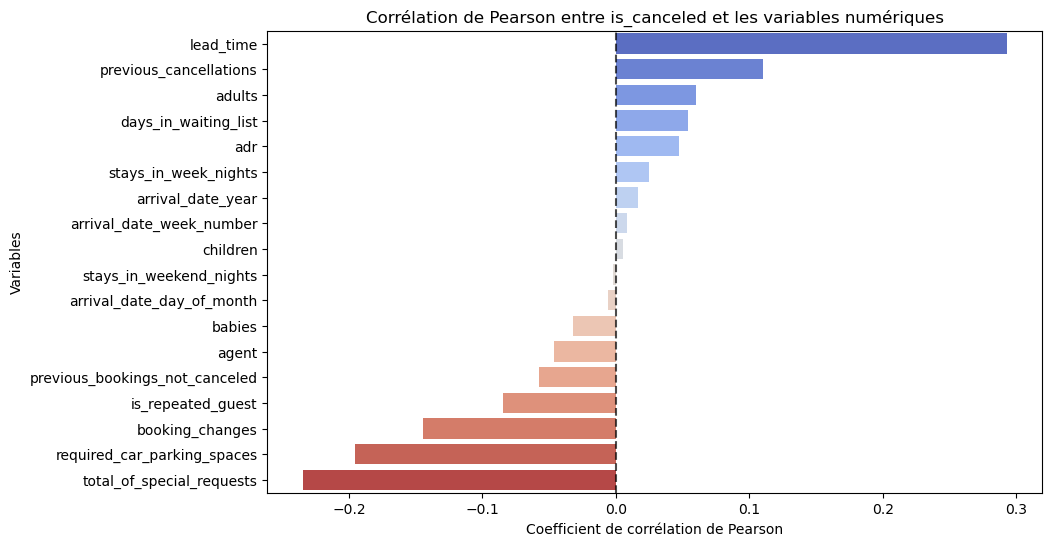

In [34]:
# Filtrer uniquement les colonnes num√©riques
numeric_cols = hotel_df.select_dtypes(include=['int64', 'float64'])

# Calcul des corr√©lations de Pearson entre les variables num√©riques et is_canceled
correlation_matrix = numeric_cols.corr()

# S√©lection des corr√©lations avec is_canceled uniquement
correlation_with_target = correlation_matrix["is_canceled"].drop("is_canceled").sort_values(ascending=False)

# Affichage des corr√©lations sous forme de tableau
print("Corr√©lations de Pearson entre is_canceled et les variables num√©riques :\n")
display(correlation_with_target.to_frame())

# Visualisation sous forme de barplot
plt.figure(figsize=(10, 6))
sns.barplot(x=correlation_with_target.values, y=correlation_with_target.index, hue=correlation_with_target.index, palette="coolwarm")
plt.title("Corr√©lation de Pearson entre is_canceled et les variables num√©riques")
plt.xlabel("Coefficient de corr√©lation de Pearson")
plt.ylabel("Variables")
plt.axvline(x=0, color='black', linestyle="--", alpha=0.7)  # Ligne verticale pour s√©parer valeurs positives et n√©gatives
plt.show()


  <p style="background-color:LightGoldenRodYellow; color:black; font-weight:bold;text-align:center;">Analyse du tableau de Corr√©lation (Pearson) entre is_canceled et les variables num√©riques

**Pourquoi cette analyse ?**  
Le **tableau de corr√©lation Pearson** permet d'identifier **les relations entre les variables num√©riques** et `is_canceled`.  
L‚Äôobjectif est d‚Äôidentifier les variables les plus influentes sur les annulations.


**Seuil de significativit√©**
- **Corr√©lation > |0,1|** *(valeurs absolues)* **: La variable est significative.**

**Conclusion :**

| Variable | Corr√©lation avec is_canceled | √Ä v√©rifier |
|----------|-------------------------------|----------------|
| lead_time | **+0.293** | 	Distribution possiblement asym√©trique ‚Üí V√©rifier un log-transform. |
| previous_cancellations | **+0.110** | V√©rifier la r√©partition (beaucoup de 0 ?). |
| booking_changes | **-0.144** | V√©rifier si la distribution est √©quilibr√©e.|
| required_car_parking_spaces | **-0.195** | V√©rifier la proportion de 0. |
| total_of_special_requests | **-0.234** | V√©rifier si c‚Äôest bien une variable discr√®te ou si certaines valeurs sont rares. |


L‚Äôanalyse de Pearson nous a permis d‚Äôidentifier les variables num√©riques ayant une corr√©lation significative avec `is_canceled`, mais elle ne renseigne pas sur les interactions entre ces variables.

**Pourquoi une heatmap apr√®s Pearson ?**
L‚Äô√©tape suivante consiste √† analyser les relations entre ces variables elles-m√™mes afin de :
1. **V√©rifier la colin√©arit√©**  
   - Si deux variables sont fortement corr√©l√©es, l‚Äôune peut √™tre supprim√©e sans perte d‚Äôinformation.
2. **Confirmer l‚Äôind√©pendance des variables**  
   - Une variable peut sembler li√©e √† is_canceled, mais uniquement via une autre variable plus influente.
     C'est-√†-dire qu'une variable pourrait para√Ætre importante pour `is_canceled`, mais en r√©alit√©, elle ne fait que refl√©ter l‚Äôeffet d‚Äôune autre variable.
3. **Optimiser le preprocessing**  
   - S√©lectionner les variables apportant une information unique et √©viter la colin√©arit√© dans le mod√®le. 
  
**La heatmap permet donc d‚Äôoptimiser le choix des variables en identifiant celles qui apportent une information unique.**


.  

 <p style="background-color:Gold; color:black; font-weight:bold;text-align:center;">Heatmap de corr√©lation des variables num√©riques significatives

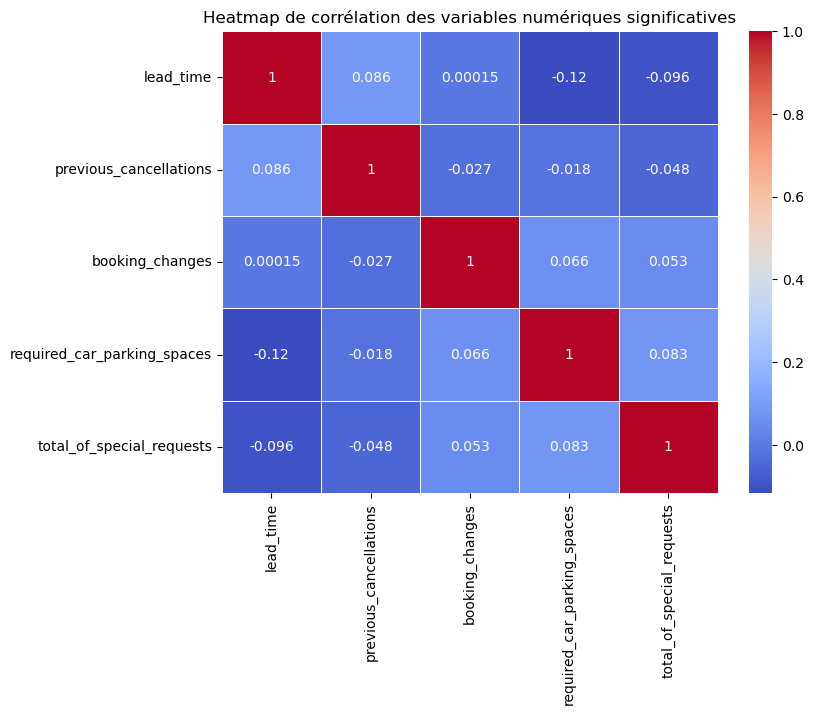

In [37]:
# Filtrer uniquement les colonnes num√©riques significatives
significativ_numeric_cols = hotel_df[['lead_time', 'previous_cancellations', 'booking_changes',
                                      'required_car_parking_spaces','total_of_special_requests']]

# Calcul de la matrice de corr√©lation
plt.figure(figsize=(8,6))
sns.heatmap(significativ_numeric_cols.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Heatmap de corr√©lation des variables num√©riques significatives")
plt.show()

  <p style="background-color:LightGoldenRodYellow; color:black; font-weight:bold;text-align:center;">Analyse de la Matrice de Corr√©lation (Heatmap) des variables num√©riques significatives

**Pourquoi cette analyse ?**  
Apr√®s la s√©lection des variables num√©riques significatives via le test de Pearson, cette heatmap permet d‚Äôidentifier d‚Äô√©ventuelles relations fortes entre ces variables.  
L‚Äôobjectif est de **d√©tecter d‚Äô√©ventuelles colin√©arit√©s** qui pourraient fausser le mod√®le ou rendre certaines variables redondantes.  

**Seuils de colin√©arit√©**  
La colin√©arit√© est g√©n√©ralement √©valu√©e selon ces seuils :  
- **|r| < 0.3** ‚Üí Faible corr√©lation (aucun probl√®me de colin√©arit√©).  
- **0.3 ‚â§ |r| < 0.7** ‚Üí Corr√©lation mod√©r√©e (potentiellement pr√©occupant selon le contexte).  
- **|r| ‚â• 0.7** ‚Üí Corr√©lation forte (peut entra√Æner des probl√®mes de redondance dans le mod√®le).  

Un seuil de **0.7 ou 0.8** est g√©n√©ralement utilis√© pour d√©tecter des variables fortement colin√©aires.  

**R√©sultats et interpr√©tation**  
- **Aucune corr√©lation forte n‚Äôest d√©tect√©e** entre les variables s√©lectionn√©es.  
- Les valeurs les plus √©lev√©es sont :  
  - `lead_time` ‚Üî `required_car_parking_spaces` (**-0.12**)  
  - `previous_cancellations` ‚Üî `lead_time` (**0.086**)  
- Ces corr√©lations restent tr√®s faibles et **aucune variable ne semble redondante**.  

**Conclusion**  
**Aucune variable ne doit √™tre supprim√©e pour cause de colin√©arit√©.**  
Les variables conservent chacune une information unique et peuvent √™tre utilis√©es dans le mod√®le sans risque de redondance.  
La prochaine √©tape consistera √† **examiner la distribution des variables** pour voir si des transformations sont n√©cessaires avant le preprocessing.  

### **4.1.2 Analyse des distributions et des valeurs extr√™mes et prise de d√©cision sur les transformations √† effectuer**

.  

 <p style="background-color:Gold; color:black; font-weight:bold;text-align:center;">Distribution des variables num√©riques singnificatives 

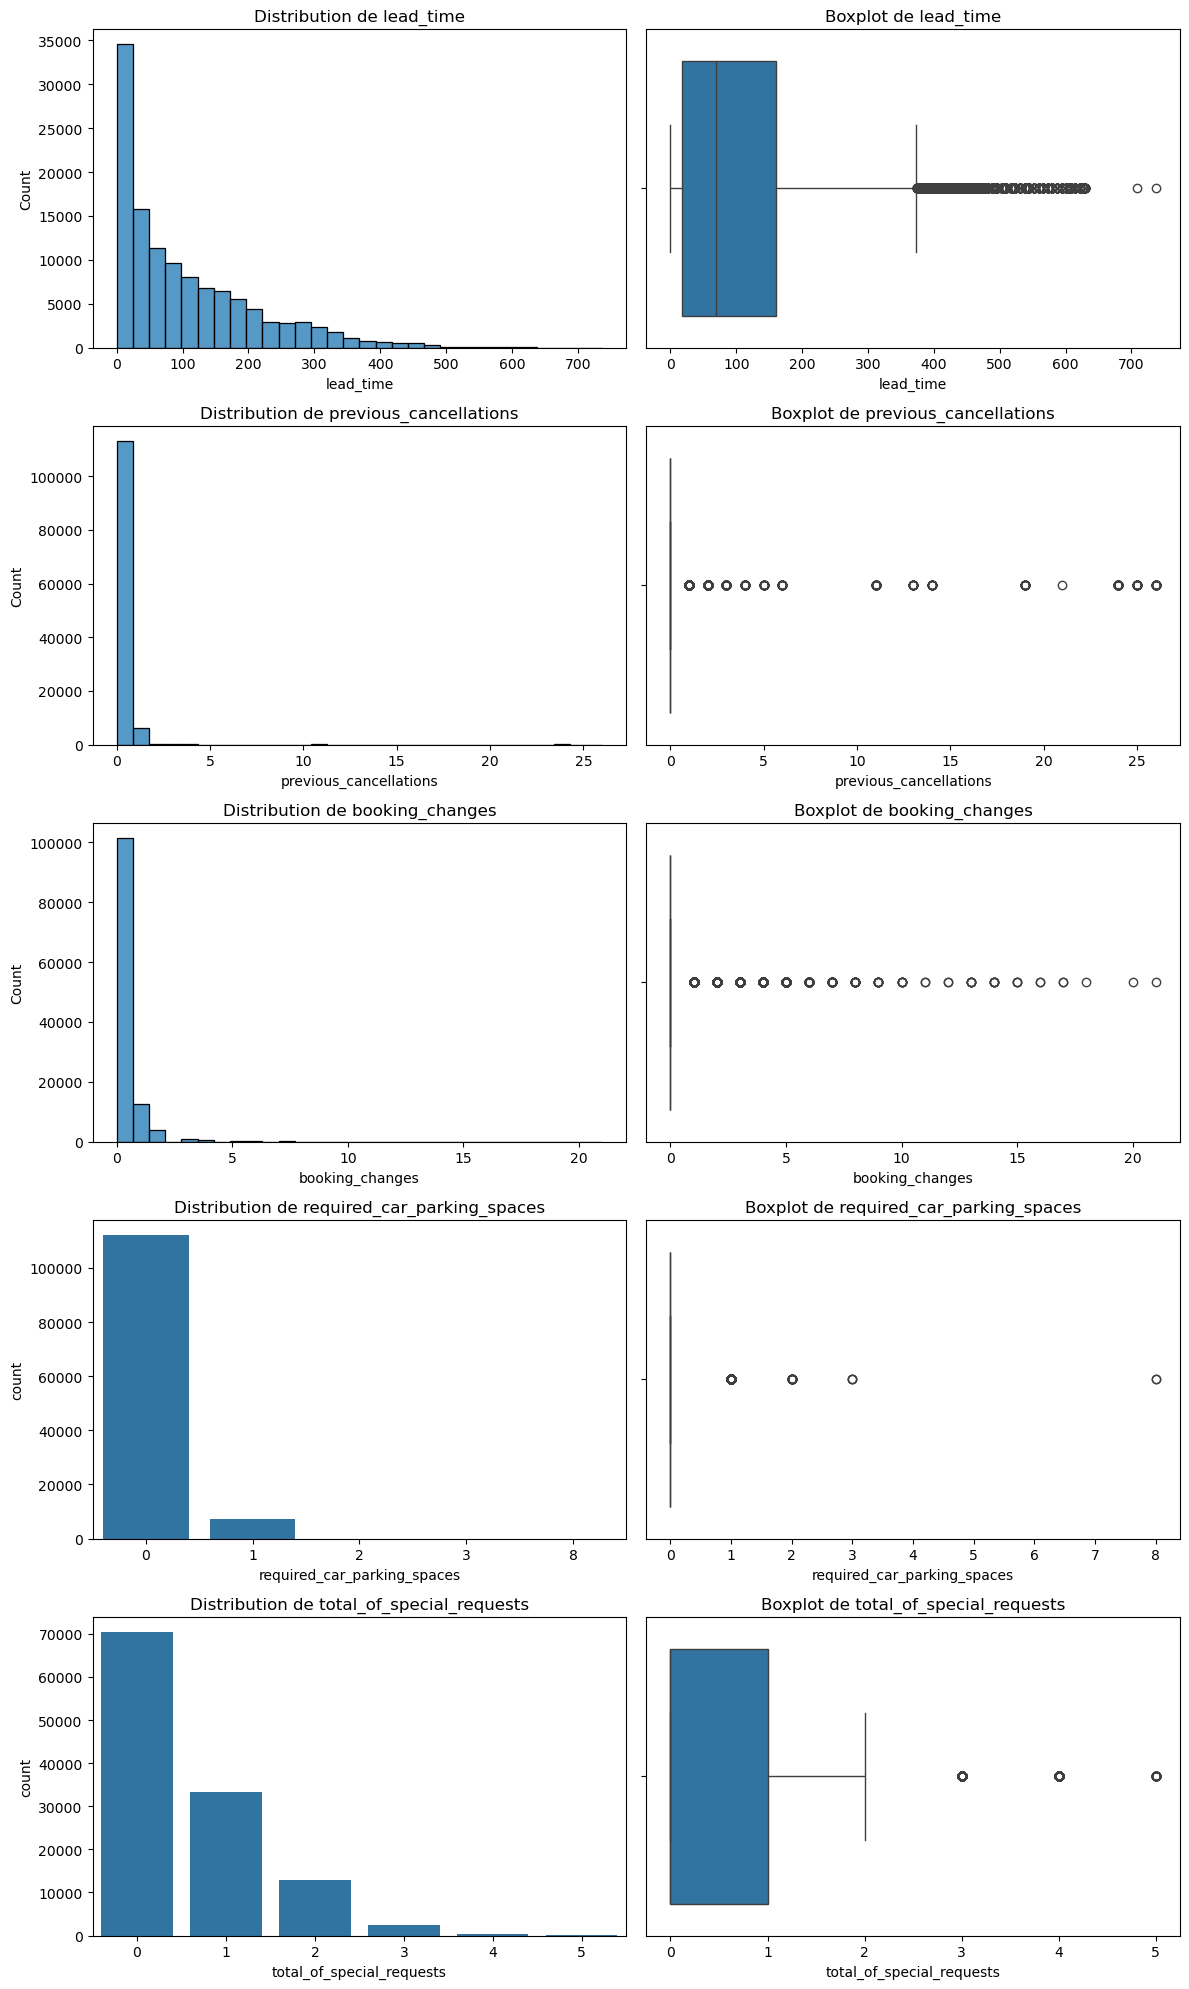

In [41]:
# Liste des variables num√©riques cl√©s identifi√©es
significativ_numeric_vars = ["lead_time", "previous_cancellations", "booking_changes", 
                "required_car_parking_spaces", "total_of_special_requests" ]

# Cr√©ation des figures avec 2 sous-graphiques (Histogramme + Boxplot) par variable
plt.figure(figsize=(12, len(significativ_numeric_vars) * 4))  # Adapter la taille selon le nombre de variables

for i, var in enumerate(significativ_numeric_vars):
    # Histogramme (ou countplot si peu de valeurs uniques)
    plt.subplot(len(significativ_numeric_vars), 2, 2*i + 1)
    if hotel_df[var].nunique() < 10:
        sns.countplot(x=hotel_df[var], order=hotel_df[var].value_counts().index)
    else:
        sns.histplot(hotel_df[var], bins=30)

    plt.title(f"Distribution de {var}")

    # Boxplot
    plt.subplot(len(significativ_numeric_vars), 2, 2*i + 2)
    sns.boxplot(x=hotel_df[var])
    plt.title(f"Boxplot de {var}")

plt.tight_layout()
plt.show()

  <p style="background-color:LightGoldenRodYellow; color:black; font-weight:bold;text-align:center;">
     Analyse des distributions des variables num√©riques significatives 

Nous analysons la distribution des variables num√©riques identifi√©es comme influentes sur `is_canceled`.  
L‚Äôobjectif est :  

- **Comprendre leur r√©partition** (asym√©trie, valeurs extr√™mes, d√©s√©quilibre).  
- **Identifier d‚Äô√©ventuels probl√®mes pour la mod√©lisation** (valeurs rares, manque de variance, transformation n√©cessaire).  

**lead_time**  
- La distribution est **tr√®s asym√©trique**, avec une forte concentration des valeurs **entre 0 et 25 jours**.  
- La **m√©diane** est √† **70 jours**.  
- Les moustaches du boxplot s‚Äô√©tendent jusqu‚Äô√† **380 jours**, mais des valeurs extr√™mes d√©passent **700 jours**.  
- **Actions possibles :**  
  - Transformation logarithmique pour r√©duire l‚Äôimpact des valeurs extr√™mes.  
  - V√©rification des percentiles pour d√©terminer un seuil de capping.  
  - Analyse des lead_time tr√®s courts (<25 jours) pour d√©tecter des tendances li√©es aux annulations.  

**previous_cancellations**  
- Distribution **extr√™mement d√©s√©quilibr√©e** : la grande majorit√© des clients **n‚Äôont jamais annul√©**.  
- La **m√©diane est √† 0** et les valeurs extr√™mes atteignent **26 annulations**.  
- **Actions possibles :**  
  - Binarisation (`0 = aucune annulation`, `1 = au moins une annulation`).  
  - Analyse des percentiles pour fixer un seuil de capping.  
  - √âtude de l‚Äôimpact d‚Äôun historique d‚Äôannulations sur `is_canceled`.  

**booking_changes**  
- **√âcrasante majorit√©** des r√©servations sans modification.  
- La **m√©diane est √† 0**, avec des valeurs atteignant **plus de 20 changements**.  
- **Actions possibles :**  
  - Binarisation (`0 modification` vs  `au moins 1 modification`).  
  - V√©rification des percentiles pour un √©ventuel capping des valeurs √©lev√©es.  
  - Analyse des clients ayant effectu√© de nombreuses modifications pour voir leur impact sur les annulations.  

**required_car_parking_spaces**  
- La quasi-totalit√© des r√©servations **ne demandent pas de place de parking**.  
- Tr√®s faible proportion avec **1 place**, et quelques valeurs extr√™mes atteignant **8 places**.  
- **Actions possibles :**  
  - Binarisation (`0 = aucune place` / `1+ = au moins une place demand√©e`).  
  - V√©rification de la coh√©rence des valeurs √©lev√©es et analyse d‚Äôun possible capping.  
  - √âtude de la corr√©lation entre plusieurs places de parking et `is_canceled`.  

**total_of_special_requests**  
- Forte concentration sur **0 et 1 demande**, avec **tr√®s peu de valeurs au-del√† de 3**.  
- La **m√©diane est √† 1**, avec des valeurs maximales de **5 demandes sp√©ciales**.  
- **Actions possibles :**  
  - Conserver la variable sous forme de **nombre exact** plut√¥t qu‚Äôune binarisation.  
  - V√©rifier les percentiles pour un capping √©ventuel des valeurs √©lev√©es.  
  - Analyse de l‚Äôinfluence du nombre de demandes sp√©ciales sur `is_canceled`.  

**Tendances communes et prochaines √©tapes**  
- **Forte asym√©trie** dans plusieurs variables (`lead_time`, `previous_cancellations`, `booking_changes`), sugg√©rant un **capping ou une transformation logarithmique**.  
- **Pr√©sence de valeurs extr√™mes** dans toutes les variables analys√©es ‚Üí Analyse des percentiles (95e, 99e) pour fixer des seuils pertinents.  
- **Variables avec des dominantes de 0** (`previous_cancellations`, `booking_changes`, `required_car_parking_spaces`) ‚Üí Possibilit√© de **binarisation** si n√©cessaire.  

**Prochaine √©tape :**   
V√©rification des distributions exactes (`value_counts()`, percentiles) avant d‚Äôappliquer des transformations dans le Data Preprocessing.  

**Cette analyse servira de base aux d√©cisions de transformation des variables lors du Data Preprocessing.**



.  

 <p style="background-color:Gold; color:black; font-weight:bold;text-align:center;">V√©rification des valeurs extr√™mes, analyse des percentiles et prise de d√©cision sur les transformations  √† effectuer

In [44]:
# D√©finition des seuils de percentiles √† analyser
percentiles = [0.95, 0.99]

# V√©rification de la r√©partition exacte des valeurs pour chaque variable num√©rique significative
# Calcul des percentiles pour chaque variable num√©rique significative
for var in significativ_numeric_vars:
    print(f"R√©partition des valeurs pour {var} :")
    print(hotel_df[var].value_counts().sort_index())
    print("\n")
    print(f"Percentiles pour {var} :")
    print(hotel_df[var].quantile(percentiles))
    print("\n"*2)


R√©partition des valeurs pour lead_time :
lead_time
0      6345
1      3460
2      2069
3      1816
4      1715
       ... 
622      17
626      30
629      17
709       1
737       1
Name: count, Length: 479, dtype: int64


Percentiles pour lead_time :
0.95    320.0
0.99    444.0
Name: lead_time, dtype: float64



R√©partition des valeurs pour previous_cancellations :
previous_cancellations
0     112906
1       6051
2        116
3         65
4         31
5         19
6         22
11        35
13        12
14        14
19        19
21         1
24        48
25        25
26        26
Name: count, dtype: int64


Percentiles pour previous_cancellations :
0.95    1.0
0.99    1.0
Name: previous_cancellations, dtype: float64



R√©partition des valeurs pour booking_changes :
booking_changes
0     101314
1      12701
2       3805
3        927
4        376
5        118
6         63
7         31
8         17
9          8
10         6
11         2
12         2
13         5
14         5
15       

<p style="background-color:LightGoldenRodYellow; color:black; font-weight:bold;text-align:center;">  Analyse de la v√©rification des valeurs extr√™mes, analyse des percentiles et prise de d√©cision sur les transformations  √† effectuer


Nous analysons ici la r√©partition des valeurs extr√™mes pour les variables num√©riques influentes sur `is_canceled`. L'objectif est de :  

- **Identifier des valeurs rares** pouvant nuire √† la robustesse du mod√®le.  
- **Fixer des seuils pertinents** pour limiter leur impact sans perdre d‚Äôinformation utile.  
- **Explorer les transformations possibles** (`capping`, `binarisation`, `transformation logarithmique`).  

**1- lead_time**  

`Analyse des valeurs extr√™mes`  
- La distribution est tr√®s √©tal√©e, avec **479 valeurs uniques** et des r√©servations allant jusqu'√† **737 jours en avance**.  
- **95‚Äâ% des valeurs** sont ‚â§ **320 jours**, et **99‚Äâ%** sont ‚â§ **444 jours**.  
- **1% des valeurs restantes sont tr√®s √©lev√©es**, mais elles ne sont pas forc√©ment aberrantes.  

`Propositions de transformation`  
- **Transformation logarithmique (`log(lead_time + 1)`)** pour att√©nuer l‚Äôeffet des valeurs extr√™mes.  
- **Capping √† 320 jours (95e percentile)** pour limiter les valeurs √©lev√©es tout en conservant la majorit√© des donn√©es.  
- **Capping √† 444 jours (99e percentile)** pour un compromis entre conservation des donn√©es et r√©duction des valeurs extr√™mes.  

`D√©cision :` Tester d‚Äôabord la **transformation logarithmique**. Si elle n‚Äôam√©liore pas le mod√®le, appliquer un **capping √† 320 jours**.  

**2- previous_cancellations**  

`Analyse des valeurs extr√™mes`  
- **95‚Äâ% des valeurs sont 0 ou 1**, la variable est **fortement d√©s√©quilibr√©e**.  
- **Les valeurs sup√©rieures √† 1 sont ultra-rares** et ne repr√©sentent que **moins de 1‚Äâ% des observations**.  

`Propositions de transformation`  
- **Binarisation (`0 = jamais annul√©` / `1 = au moins une annulation`)** : permet de simplifier la variable tout en conservant l'information cl√©.  
- **Capping √† 1** : remplace toutes les valeurs >1 par 1 pour √©viter l'effet des valeurs rares.  

`D√©cision :` Appliquer une **binarisation**, car **99‚Äâ% des valeurs sont d√©j√† 0 ou 1**.  

**3- booking_changes**  

`Analyse des valeurs extr√™mes`  
- **95‚Äâ% des r√©servations ont √©t√© modifi√©es au maximum 1 fois**, et **99‚Äâ% au maximum 3 fois**.  
- **Les valeurs sup√©rieures √† 3 sont extr√™mement rares**, ce qui pourrait introduire du bruit dans le mod√®le.  

`Propositions de transformation`  
- **Binarisation (`0 = aucune modification` / `1 = au moins une modification`)** si seule la distinction "modifi√© vs non modifi√©" est pertinente.  
- **Capping √† 3** : limiter les valeurs √† **3 maximum** pour √©viter l‚Äôinfluence des valeurs extr√™mes.  

`D√©cision :` Appliquer un **capping √† 3** tout en testant son impact sur la performance du mod√®le.  

**4- required_car_parking_spaces**  

`Analyse des valeurs extr√™mes`  
- **93.8‚Äâ% des r√©servations n‚Äôont pas demand√© de place de parking (0)**.  
- **99‚Äâ% des clients ont demand√© au maximum 1 place**, et les valeurs >1 sont **quasi inexistantes**.  

`Propositions de transformation`  
- **Binarisation (`0 = aucune place` / `1+ = au moins une place`)** car les valeurs >1 sont trop rares pour √™tre significatives.  

`D√©cision :` Appliquer une **binarisation** (`0 = aucune place` / `1 = au moins une place demand√©e`).  

**5- total_of_special_requests**  

`Analyse des valeurs extr√™mes`  
- **95‚Äâ% des r√©servations ont fait au maximum 2 demandes sp√©ciales**, et **99‚Äâ% au maximum 3**.  
- **Les valeurs sup√©rieures √† 3 sont tr√®s rares (~0.3‚Äâ%)**, ce qui pourrait justifier un capping.  

`Propositions de transformation`  
- **Capping √† 3** : toutes les valeurs >3 deviennent 3 pour √©viter l‚Äôimpact des valeurs rares.  
- **Conservation de la variable telle quelle**, si le nombre exact de demandes sp√©ciales influence `is_canceled`.  

`D√©cision :` Conserver la variable **telle quelle** pour  comparer les taux d‚Äôannulation (`is canceled`) par nombre de demandes sp√©ciales. Si les valeurs **4 et 5** n‚Äôont pas d‚Äôinfluence significative, un **capping √† 3** sera appliqu√©.  

**Synth√®se des d√©cisions**  

| **Variable** | **Transformation appliqu√©e** |
|-------------|------------------------------|
| `lead_time` | Transformation logarithmique ou capping √† 320 jours |
| `previous_cancellations` | Binarisation (`0 = jamais annul√©`, `1 = au moins une annulation`) |
| `booking_changes` | Capping √† 3 |
| `required_car_parking_spaces` | Binarisation (`0 = aucune place`, `1 = au moins une place demand√©e`) |
| `total_of_special_requests` | Conserver tel quel, puis tester un capping √† 3 si n√©cessaire |


### **4.1.3 R√©capitulatif des d√©cisions sur les transformations √† appliquer (variables num√©riques)**

<p style="background-color:Gold;color:black; font-weight:bold; font-size:18px;text-align:center;">
    R√©capitulatif des variables num√©riques significatives et transformations √† appliquer

**Variables num√©riques significatives identifi√©es**   
Nous avons s√©lectionn√© les variables num√©riques ayant une influence notable sur `is_canceled`.  
L‚Äôanalyse de **Pearson** et des **distributions** a permis d‚Äôidentifier ces variables et de d√©finir les transformations n√©cessaires avant leur int√©gration dans un mod√®le pr√©dictif.

.  
**Liste des variables num√©riques significatives :**  
| **Variable** | **Corr√©lation avec is_canceled** | **Probl√®mes identifi√©s** |
|-------------|-------------------------------|---------------------------|
| `lead_time` | **+0.293** | Distribution tr√®s asym√©trique, impact des valeurs extr√™mes |
| `previous_cancellations` | **+0.110** | D√©s√©quilibre (majorit√© de 0), rares valeurs tr√®s √©lev√©es |
| `booking_changes` | **-0.144** | Majorit√© de 0, quelques valeurs √©lev√©es |
| `required_car_parking_spaces` | **-0.195** | Majorit√© de 0, faible variance |
| `total_of_special_requests` | **-0.234** | Quelques valeurs √©lev√©es peu fr√©quentes |
  
.  
**Transformations pr√©vues pour la mod√©lisation**  
Certaines variables n√©cessitent des transformations avant leur utilisation dans un mod√®le.  
Les choix de transformations sont bas√©s sur les analyses de distribution, d‚Äôoutliers et de variabilit√©.

| **Variable** | **Transformation √† appliquer** | **Justification** |
|-------------|------------------------------|-------------------|
| `lead_time` | **Transformation logarithmique** | R√©duire l‚Äôimpact des valeurs extr√™mes |
| `previous_cancellations` | **Binarisation (`0 = jamais annul√©`, `1 = au moins une annulation`)** | La plupart des valeurs sont 0, peu de variance au-del√† de 1 |
| `booking_changes` | **Capping √† 3** | √âviter l‚Äôimpact des valeurs tr√®s rares sup√©rieures √† 3 |
| `required_car_parking_spaces` | **Binarisation (`0 = aucune place`, `1+ = au moins une place demand√©e`)** | La quasi-totalit√© des valeurs >1 sont rares et peu significatives |
| `total_of_special_requests` | **Conserver tel quel, puis tester un capping √† 3 si n√©cessaire** | V√©rifier si les valeurs √©lev√©es influencent `is_canceled` |
  
.  
**Transition vers le Data Preprocessing**  
Afin de conserver une **s√©paration stricte entre l‚ÄôEDA et le Data Preprocessing**, **aucune transformation n‚Äôest appliqu√©e ici**.  
Les modifications mentionn√©es ci-dessus seront mises en ≈ìuvre **dans la partie Data Preprocessing**, o√π nous validerons leur impact sur la distribution des variables et la performance du mod√®le.



## **4.2 Identification des Variables Cat√©gorielles Significatives**

### **4.2.1 Identification des variables cat√©gorielles significatives (corr√©lation avec is_canceled)**

.  
 
 <p style="background-color:blue; color:white; font-weight:bold;text-align:center;">Analyse de l‚Äôimpact de hotel sur is_canceled

Nombre de reservations par type d'h√¥tel
 hotel
City Hotel      79330
Resort Hotel    40060
Name: count, dtype: int64

Taux d'annulation par type d'h√¥tel :
               Confirm√©     Annul√©
hotel                             
City Hotel    58.273037  41.726963
Resort Hotel  72.236645  27.763355


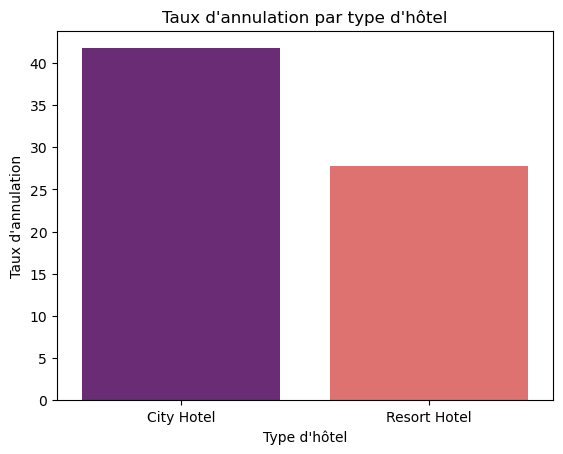

In [51]:
# Compter le nombre de reservations par type d'h√¥tel
hotel_counts = hotel_df['hotel'].value_counts().sort_values(ascending=False)
print("Nombre de reservations par type d'h√¥tel\n",hotel_counts)

# Calcul du taux d'annulation par type d'h√¥tel
hotel_analysis = pd.crosstab(hotel_df['hotel'], hotel_df['is_canceled'], normalize='index') * 100
hotel_analysis.columns = ['Confirm√©', 'Annul√©']
hotel_analysis = hotel_analysis.sort_values(by="Annul√©", ascending=False)

# Affichage du tableau
print("\nTaux d'annulation par type d'h√¥tel :")
print(hotel_analysis)

# Barplot des taux d'annulation par type d'h√¥tel
sns.barplot(x=hotel_analysis.index, y=hotel_analysis['Annul√©'], 
            hue=hotel_analysis.index,
            palette='magma')
plt.title("Taux d'annulation par type d'h√¥tel")
plt.xlabel("Type d'h√¥tel")
plt.ylabel("Taux d'annulation")
plt.show()

 <p style="background-color:lightblue; color:black; font-weight:bold;text-align:center;">Analyse du taux d‚Äôannulation par type d‚Äôh√¥tel
  
**Observations principales :**  
- **Le taux d‚Äôannulation est plus √©lev√© pour les "City Hotels" (41.7‚Äâ%)** que pour les "Resort Hotels" (27.8‚Äâ%).  
- **Les "City Hotels" enregistrent un volume de r√©servations plus √©lev√©** (79 330 contre 40 060), ce qui renforce la fiabilit√© de cette tendance. 
  

**Interpr√©tation :**  
- **Le taux d‚Äôannulation plus √©lev√© des h√¥tels en ville** peut √™tre li√© √† plusieurs facteurs :  
  - **Flexibilit√© des r√©servations** : Les s√©jours en ville sont plus souvent courts et ajustables.  
  - **Voyages d‚Äôaffaires et incertitudes** : Les h√¥tels urbains attirent davantage de professionnels qui annulent selon leurs imp√©ratifs.  
  - **Concurrence et alternatives** : Une plus grande offre d‚Äôh√¥tels en ville peut inciter les clients √† changer de r√©servation. 
- **Les h√¥tels "Resort" affichent un taux d‚Äôannulation plus faible**, ce qui peut √™tre d√ª √† :  
  - **Une planification plus rigoureuse des s√©jours de vacances.**  
  - **Des politiques d‚Äôannulation plus strictes ou des s√©jours pr√©pay√©s.** 

**Conclusion :**     
 <p style="background-color:lightgreen; color:black; font-weight:bold;">hotel est une variable significative.

.  

 <p style="background-color:blue; color:white; font-weight:bold;text-align:center;">Analyse de l‚Äôimpact de meal sur is_canceled


Nombre de reservations par type de repas
 meal
BB           92310
HB           14463
SC           10650
Undefined     1169
FB             798
Name: count, dtype: int64

Taux d'annulation par type de repas :
            Confirm√©     Annul√©
meal                           
FB         40.100251  59.899749
BB         62.615101  37.384899
SC         62.760563  37.239437
HB         65.539653  34.460347
Undefined  75.534645  24.465355


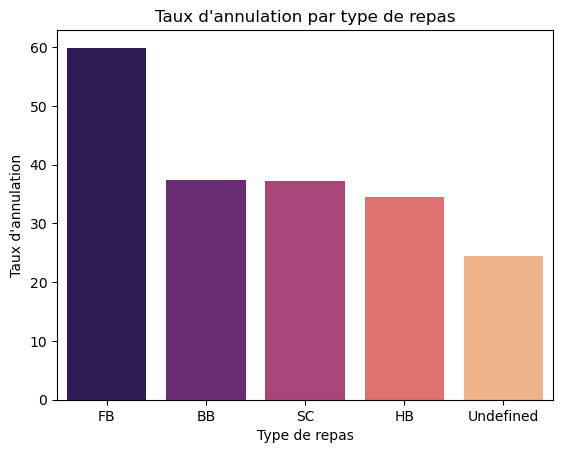

In [54]:
"""(meal = Undefined/SC = no meal package; 
BB = Bed & Breakfast; 
HB = Half board (breakfast and one other meal ‚Äì usually dinner); 
FB = Full board (breakfast, lunch and dinner)"""

# Compter le nombre de reservations par type repas
meal_counts = hotel_df['meal'].value_counts().sort_values(ascending=False)
print("Nombre de reservations par type de repas\n",meal_counts,)

# Calcul du taux d'annulation par type de repas 
meal_analysis = pd.crosstab(hotel_df['meal'], hotel_df['is_canceled'], normalize='index') * 100
meal_analysis.columns = ['Confirm√©', 'Annul√©']
meal_analysis = meal_analysis.sort_values(by="Annul√©", ascending=False)

# Affichage du tableau
print("\nTaux d'annulation par type de repas :")
print(meal_analysis)

# Barplot des taux d'annulation par type de repas
sns.barplot(x=meal_analysis.index, y=meal_analysis['Annul√©'], 
            hue=meal_analysis.index, 
            palette='magma', legend=False)
plt.title("Taux d'annulation par type de repas")
plt.xlabel("Type de repas")
plt.ylabel("Taux d'annulation")
plt.show()

<p style="background-color:lightblue; color:black; font-weight:bold;text-align:center;">Analyse du taux d‚Äôannulation par type de repas  

L‚Äôanalyse des annulations en fonction du type de repas montre **une diff√©rence notable pour certaines cat√©gories** :  
- Le taux d‚Äôannulation est particuli√®rement √©lev√© pour **`FB` (59.9‚Äâ%)**, tandis qu‚Äôil est plus faible pour **`Undefined` (24.5‚Äâ%)**.  
- Les autres types de repas **ont des taux similaires**, autour de **34‚Äâ% √† 37‚Äâ%**.  

.  
**Pourquoi `FB` pr√©sente-t-il un taux d‚Äôannulation plus √©lev√© ?**  
Plusieurs hypoth√®ses peuvent √™tre avanc√©es :  
1. **R√©servations de groupe ou longues dur√©es**  
   - Les formules `FB` sont souvent choisies par des groupes, des familles ou des s√©jours prolong√©s.  
   - Ces r√©servations peuvent √™tre plus sujettes √† des changements impr√©vus, notamment des annulations.  

2. **Moins de flexibilit√©**  
   - Un engagement financier plus important pourrait √™tre associ√© √† des conditions de modification plus strictes.  
   - **Si les conditions de modification sont moins souples, certains clients pourraient pr√©f√©rer annuler compl√®tement et r√©server ailleurs.**  

3. **Type de client√®le diff√©rent**  
   - Les clients qui optent pour `FB` pourraient √™tre **des vacanciers internationaux** ayant des contraintes plus fortes (ex: vols, visas).  
   - En cas de probl√®me (vol annul√©, budget revu √† la baisse, changement de programme), ils sont plus enclins √† **annuler leur s√©jour complet** plut√¥t que de modifier simplement la r√©servation.  

4. **Offre moins r√©pandue = Moins de stabilit√© ?**  
   - `FB` est le **type de repas le moins r√©serv√© (seulement 798 r√©servations)**.  
   - Il est possible que ces r√©servations soient plus sensibles √† des conditions particuli√®res (moins d'offres, prix plus √©lev√©s, etc.), ce qui les rend plus instables.

**Conclusion :**   
<p style="background-color:lightgreen; color:black; font-weight:bold;"> meal est une variable significative.  

.  
 <p style="background-color:blue; color:white; font-weight:bold;text-align:center;">
Analyse de l‚Äôimpact de country_grouped sur is_canceled
      
Le probl√®me pour analyser country est qu'il y a √©norm√©ment de cat√©gories (pays) ce qui rendrait l'analyse illisible si on affichait toutes les valeurs.  
Mais la majorit√© des r√©servations viennent de quelques pays, on peut donc cr√©er une nouvelle version modifi√©e country_grouped de la colonne country sur le dataset et filtrer les pays les plus repr√©sent√©s afin de voir leur impact sur is_canceled.  
***filtre: pays avec au moins 500 occurrences***

Nombre de reservations par pays
 country_grouped
PRT       49078
GBR       12129
FRA       10415
ESP        8568
DEU        7287
Others     6883
ITA        3766
IRL        3375
BEL        2342
BRA        2224
NLD        2104
USA        2097
CHE        1730
CN         1279
AUT        1263
SWE        1024
CHN         999
POL         919
ISR         669
RUS         632
NOR         607
Name: count, dtype: int64

Taux d'annulation par pays :
                  Confirm√©     Annul√©
country_grouped                      
PRT              43.791516  56.208484
CHN              53.753754  46.246246
RUS              62.183544  37.816456
BRA              62.679856  37.320144
ITA              64.604355  35.395645
Others           69.577219  30.422781
NOR              70.181219  29.818781
ESP              74.591503  25.408497
ISR              74.738416  25.261584
CHE              75.260116  24.739884
IRL              75.348148  24.651852
USA              76.108727  23.891273
POL              76.60500

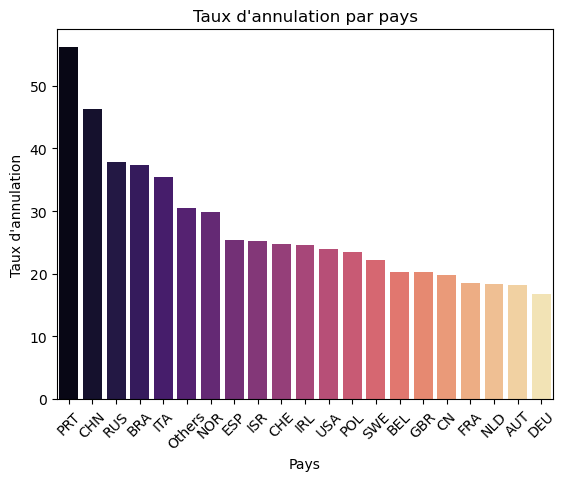

In [57]:
#Nombre minimum d'occurrences pour afficher un pays
min_count = 500  
# Filtrer les pays avec un nombre d'occurrences suffisant
top_countries = hotel_df["country"].value_counts()
top_countries = top_countries[top_countries > min_count].index

# Filtrer le dataset pour ne garder que ces pays
hotel_df["country_grouped"] = hotel_df["country"].apply(lambda x: x if x in top_countries else 'Others')

# Compter le nombre de reservations par pays
country_grouped_counts = hotel_df['country_grouped'].value_counts().sort_values(ascending=False)
print("Nombre de reservations par pays\n",country_grouped_counts,)

# Calcul du taux d'annulation par pays
country_grouped_analysis = pd.crosstab(hotel_df['country_grouped'], hotel_df['is_canceled'], normalize='index') * 100
country_grouped_analysis.columns = ['Confirm√©', 'Annul√©']
country_grouped_analysis = country_grouped_analysis.sort_values(by="Annul√©", ascending=False)

# Affichage du tableau
print("\nTaux d'annulation par pays :")
print(country_grouped_analysis)


# Barplot des taux d'annulation par pays
sns.barplot(x=country_grouped_analysis.index, y=country_grouped_analysis['Annul√©'], 
            hue=country_grouped_analysis.index, 
            palette='magma', legend=False)
plt.title("Taux d'annulation par pays")
plt.xlabel("Pays")
plt.ylabel("Taux d'annulation")
plt.xticks(rotation=45)
plt.show()

 <p style="background-color:lightblue; color:black; font-weight:bold;text-align:center;">Analyse du taux d‚Äôannulation par pays  

L‚Äôanalyse des annulations selon le pays montre **de fortes disparit√©s** dans les comportements de r√©servation et d‚Äôannulation.  

**Observations principales :**  
- **Le taux d‚Äôannulation varie consid√©rablement selon le pays**, allant de **16.7‚Äâ% (Allemagne)** √† **56.2‚Äâ% (Portugal)**.  
- **Les clients portugais (`PRT`) ont le taux d‚Äôannulation le plus √©lev√© (56.2‚Äâ%)**, ce qui pourrait √™tre li√© √† des facteurs internes, comme des habitudes de r√©servation diff√©rentes ou des conditions d‚Äôannulation plus souples pour certaines cat√©gories de clients.  
- **Les clients allemands (`DEU`) et autrichiens (`AUT`) ont des taux d‚Äôannulation beaucoup plus faibles (~16-18‚Äâ%)**, sugg√©rant des comportements de r√©servation plus engageants.  

**Interpr√©tation :**  
- Le taux d‚Äôannulation **semble li√© aux habitudes de r√©servation sp√©cifiques √† chaque pays**, mais aussi aux **canaux de distribution** utilis√©s.  
- Certains pays pourraient avoir des **politiques d‚Äôannulation diff√©rentes**, influen√ßant les d√©cisions des clients.  
- Les pays ayant un **taux d‚Äôannulation tr√®s bas pourraient √™tre plus enclins √† effectuer des r√©servations confirm√©es √† l‚Äôavance**, tandis que d‚Äôautres pourraient utiliser des **r√©servations plus flexibles et sujettes aux changements**.  

**Conclusion :**  
<p style="background-color:lightgreen; color:black; font-weight:bold;"> country_grouped est une variable significative.

.  
 <p style="background-color:blue; color:white; font-weight:bold;text-align:center;">Analyse de l‚Äôimpact de market_segment sur is_canceled

Nombre de reservations par segment
 market_segment
Online TA        56477
Offline TA/TO    24219
Groups           19811
Direct           12606
Corporate         5295
Complementary      743
Aviation           237
Undefined            2
Name: count, dtype: int64

Taux d'annulation par segment de march√© :
                 Confirm√©      Annul√©
market_segment                       
Undefined        0.000000  100.000000
Groups          38.937964   61.062036
Online TA       63.278857   36.721143
Offline TA/TO   65.683967   34.316033
Aviation        78.059072   21.940928
Corporate       81.265345   18.734655
Direct          84.658099   15.341901
Complementary   86.944818   13.055182


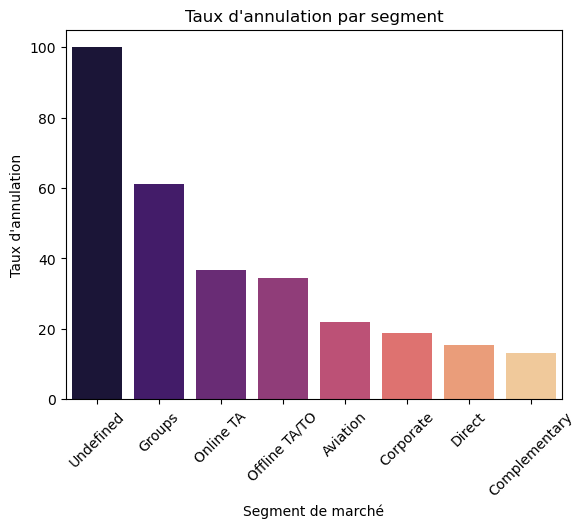

In [60]:
# Compter le nombre de reservations par type segment
market_segment_counts = hotel_df['market_segment'].value_counts().sort_values(ascending=False)
print("Nombre de reservations par segment\n",market_segment_counts,)


# Calcul du taux d'annulation par segment de march√©
market_segment_analysis = pd.crosstab(hotel_df['market_segment'], hotel_df['is_canceled'], normalize='index') * 100
market_segment_analysis.columns = ['Confirm√©', 'Annul√©']
market_segment_analysis = market_segment_analysis.sort_values(by="Annul√©", ascending=False)

# Affichage du tableau
print("\nTaux d'annulation par segment de march√© :")
print(market_segment_analysis)


# Barplot des taux d'annulation par segment
sns.barplot(x=market_segment_analysis.index, y=market_segment_analysis['Annul√©'], 
            hue=market_segment_analysis.index, 
            palette='magma', legend=False)
plt.title("Taux d'annulation par segment")
plt.xlabel("Segment de march√©")
plt.ylabel("Taux d'annulation")
plt.xticks(rotation=45)
plt.show()

 <p style="background-color:lightblue; color:black; font-weight:bold;text-align:center;">Analyse du taux d‚Äôannulation par segment de march√©  

L‚Äôanalyse des annulations en fonction du segment de march√© r√©v√®le **de fortes disparit√©s** entre les cat√©gories :  
- **Le segment "Groups" a le taux d‚Äôannulation le plus √©lev√© (61.1‚Äâ%)**, ce qui peut s'expliquer par la nature des r√©servations de groupe, souvent soumises √† des changements de derni√®re minute.  
- **Les segments "Online TA" et "Offline TA/TO" affichent √©galement des taux √©lev√©s (~35‚Äâ%)**, ce qui est coh√©rent avec la flexibilit√© g√©n√©ralement offerte par ces plateformes de r√©servation.  
- **Les segments "Direct", "Corporate" et "Complementary" ont des taux d‚Äôannulation plus faibles (<20‚Äâ%)**, sugg√©rant que ces clients sont plus engag√©s et moins enclins √† annuler.  
- **Le segment "Undefined" pr√©sente un taux d‚Äôannulation de 100‚Äâ%**, mais il ne contient que **2 r√©servations**, rendant cette information non exploitable.  
   
**Conclusion :**  
<p style="background-color:lightgreen; color:black; font-weight:bold;">market_segment est une variable significative.

.  
 <p style="background-color:blue; color:white; font-weight:bold;text-align:center;">Analyse de l‚Äôimpact de distribution_channel sur is_canceled

Nombre de reservations par distribution_channel
 distribution_channel
TA/TO        97870
Direct       14645
Corporate     6677
GDS            193
Undefined        5
Name: count, dtype: int64

 Taux d'annulation par canal de distribution :
                       Confirm√©     Annul√©
distribution_channel                      
Undefined             20.000000  80.000000
TA/TO                 58.974149  41.025851
Corporate             77.924217  22.075783
GDS                   80.829016  19.170984
Direct                82.540116  17.459884


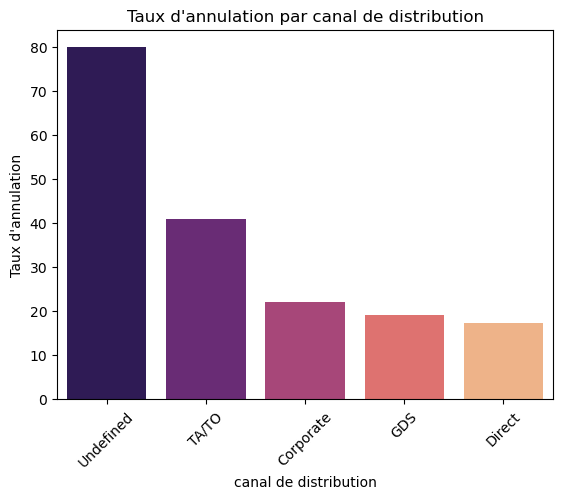

In [63]:
# Compter le nombre de reservations par canal de distribution
distribution_channel_counts = hotel_df['distribution_channel'].value_counts().sort_values(ascending=False)
print("Nombre de reservations par distribution_channel\n",distribution_channel_counts,)


# Calcul du taux d'annulation par canal de distribution
distribution_channel_analysis = pd.crosstab(hotel_df['distribution_channel'], hotel_df['is_canceled'], normalize='index') * 100
distribution_channel_analysis.columns = ['Confirm√©', 'Annul√©']
distribution_channel_analysis = distribution_channel_analysis.sort_values(by="Annul√©", ascending=False)

# Affichage du tableau
print("\n Taux d'annulation par canal de distribution :")
print(distribution_channel_analysis)

# Barplot des taux d'annulation par canal de distribution
sns.barplot(x=distribution_channel_analysis.index, y=distribution_channel_analysis['Annul√©'], 
            hue=distribution_channel_analysis.index, 
            palette='magma', legend=False)
plt.title("Taux d'annulation par canal de distribution")
plt.xlabel("canal de distribution")
plt.ylabel("Taux d'annulation")
plt.xticks(rotation=45)
plt.show()


<p style="background-color:lightblue; color:black; font-weight:bold;text-align:center;">Analyse du taux d‚Äôannulation par canal de distribution  

L‚Äôanalyse des annulations en fonction du canal de distribution r√©v√®le **des √©carts significatifs** :  
- **Le canal `TA/TO` affiche le taux d‚Äôannulation le plus √©lev√© (41‚Äâ%)**, ce qui est coh√©rent avec la flexibilit√© g√©n√©ralement offerte par ces plateformes de r√©servation.  
- **Les canaux `Corporate`, `GDS` et `Direct` ont des taux d‚Äôannulation bien plus faibles (entre 17‚Äâ% et 22‚Äâ%)**, sugg√©rant des r√©servations plus engag√©es et moins sujettes aux annulations.  
- **Le canal `Undefined` pr√©sente un taux d‚Äôannulation de 80‚Äâ%**, mais avec seulement **5 r√©servations**, cette information est peu exploitable.  


**Conclusion :**  
<p style="background-color:lightgreen; color:black; font-weight:bold;">distribution_channel est une variable significative. 

.  
 <p style="background-color:blue; color:white; font-weight:bold;text-align:center;">Analyse de l‚Äôimpact de reserved_room_type sur is_canceled

In [66]:
# Calcul du taux d'annulation par type de chambre r√©serv√©e
reserved_room_analysis = pd.crosstab(hotel_df['reserved_room_type'], hotel_df['is_canceled'], normalize='index') * 100
reserved_room_analysis.columns = ['Confirm√©', 'Annul√©']

# Affichage du tableau
print("\nTaux d'annulation par type de chambre r√©serv√©e :")
print(reserved_room_analysis)


Taux d'annulation par type de chambre r√©serv√©e :
                     Confirm√©      Annul√©
reserved_room_type                       
A                   60.892620   39.107380
B                   67.084079   32.915921
C                   66.952790   33.047210
D                   68.220405   31.779595
E                   70.711553   29.288447
F                   69.623749   30.376251
G                   63.562560   36.437440
H                   59.234609   40.765391
L                   66.666667   33.333333
P                    0.000000  100.000000


<p style="background-color:lightblue; color:black; font-weight:bold;text-align:center;">Analyse du taux d‚Äôannulation par type de chambre r√©serv√©e  

L‚Äôanalyse des annulations en fonction du type de chambre r√©serv√©e **ne r√©v√®le pas de tendance significative** :  
- La majorit√© des types de chambres affichent un taux d‚Äôannulation compris entre **29‚Äâ% et 41‚Äâ%**, sans variation marqu√©e.  
- **Le type de chambre "P" pr√©sente un taux d‚Äôannulation de 100‚Äâ%**, mais compte tenu de son faible nombre d‚Äôoccurrences, cette donn√©e est probablement **non repr√©sentative**.  

<p style="background-color:lightcoral; color:black; font-weight:bold;"> 
    reserved_room_type n'est pas une variable significative.  
    
Les diff√©rences observ√©es entre les cat√©gories sont **mod√©r√©es et peu exploit√©es pour la pr√©diction**, √† l‚Äôexception de la chambre "P", qui semble √™tre un cas isol√©.  


.  
 <p style="background-color:blue; color:white; font-weight:bold;text-align:center;">Analyse de l‚Äôimpact de assigned_room_type sur is_canceled

In [69]:
# Calcul du taux d'annulation par type de chambre assign√©e
assigned_room_analysis = pd.crosstab(hotel_df['assigned_room_type'], hotel_df['is_canceled'], normalize='index') * 100
assigned_room_analysis.columns = ['Confirm√©', 'Annul√©']

# Affichage du tableau
print("\nTaux d'annulation par type de chambre assign√©e :")
print(assigned_room_analysis)



Taux d'annulation par type de chambre assign√©e :
                     Confirm√©      Annul√©
assigned_room_type                       
A                   55.507542   44.492458
B                   76.329172   23.670828
C                   81.221053   18.778947
D                   74.875602   25.124398
E                   74.788624   25.211376
F                   75.286590   24.713410
G                   69.447709   30.552291
H                   64.747191   35.252809
I                   98.622590    1.377410
K                   95.698925    4.301075
L                    0.000000  100.000000
P                    0.000000  100.000000


<p style="background-color:lightblue; color:black; font-weight:bold;text-align:center;">Analyse du taux d‚Äôannulation par type de chambre assign√©e  

L‚Äôanalyse des annulations en fonction du type de chambre assign√©e **montre quelques variations, mais sans tendance r√©ellement exploitable** :  
- **Le type de chambre "A" pr√©sente le taux d‚Äôannulation le plus √©lev√© parmi les cat√©gories courantes (44.5‚Äâ%)**, mais l‚Äô√©cart avec les autres types reste mod√©r√©.  
- **Les types "L" et "P" affichent un taux d‚Äôannulation de 100‚Äâ%**, mais leur faible occurrence sugg√®re une **anomalie ou un manque de donn√©es**.  
- **Les autres cat√©gories se situent entre 13‚Äâ% et 35‚Äâ%**, ce qui **ne d√©gage pas de mod√®le clair** influen√ßant directement les annulations.  

<p style="background-color:lightcoral; color:black; font-weight:bold;"> 
    assigned_room_type n'est pas une variable significative. 
    
Les diff√©rences observ√©es sont **insuffisamment marqu√©es pour √™tre exploit√©es dans la mod√©lisation**.  
Les taux d‚Äôannulation extr√™mes de certaines cat√©gories semblent **refl√©ter des sp√©cificit√©s ponctuelles plut√¥t qu‚Äôune tendance g√©n√©rale**.  

.  

 <p style="background-color:blue; color:white; font-weight:bold;text-align:center;">Cr√©ation de la variable room_change et analyse de l'impact avec is_canceled
     
**Nous avons vu que reserved_room et assigned_room ne sont pas des variables cl√©s. Cela dit, il pourrait √™tre bon de v√©rifier si la chambre r√©serv√©e (reserved_room) est la m√™me que la chambre assign√©e (assigned_room).**  
En effet, il se pourrait que des annulations soient li√©es au fait que la chambre assign√©e est diff√©rente de celle r√©serv√©e.  
  
Nous allons donc cr√©er une nouvelle variable binaire `room_change` qui prendra **1 si la chambre assign√©e est diff√©rente de la chambre r√©serv√©e et sinon 0.**

In [72]:
# Cr√©ation de la variable binaire (1 si la chambre assign√©e est diff√©rente de la chambre r√©serv√©e)
hotel_df['room_change'] = (hotel_df['reserved_room_type'] != hotel_df['assigned_room_type']).astype(int)


# Compter le nombre de reservations par room_change
room_change_counts = hotel_df['room_change'].value_counts().sort_values(ascending=False)
print("Nombre de reservations par room_change\n",room_change_counts,)

# Calcul du taux d'annulation selon room_change
room_change_analysis = pd.crosstab(hotel_df['room_change'], hotel_df['is_canceled'], normalize='index') * 100
room_change_analysis.columns = ['Confirm√©', 'Annul√©']
room_changel_analysis = room_change_analysis.sort_values(by="Annul√©", ascending=False)

# Affichage du tableau
print("\nTaux d'annulation selon le changement de chambre :")
print(room_change_analysis)

Nombre de reservations par room_change
 room_change
0    104473
1     14917
Name: count, dtype: int64

Taux d'annulation selon le changement de chambre :
              Confirm√©     Annul√©
room_change                      
0            58.437108  41.562892
1            94.623584   5.376416


<p style="background-color:lightblue; color:black; font-weight:bold;text-align:center;">Analyse du taux d‚Äôannulation selon le changement de chambre  

L‚Äôanalyse des annulations en fonction du changement de chambre **montre une forte diff√©rence entre les cat√©gories** :  
- **Les r√©servations sans changement de chambre (`room_change = 0`) ont un taux d‚Äôannulation √©lev√© (41.6‚Äâ%)**.  
- **Les r√©servations avec un changement de chambre (`room_change = 1`) ont un taux d‚Äôannulation beaucoup plus faible (5.4‚Äâ%)**.  

**Interpr√©tation :**  
- √Ä premi√®re vue, on pourrait penser que le changement de chambre **r√©duit fortement les annulations**.  
- Cependant, **cette relation est probablement due √† un effet de temporalit√©** :  
  - Les changements de chambre se produisent souvent **peu avant l‚Äôarriv√©e**, lorsque l‚Äôannulation **n‚Äôest plus une option viable**, car le client est pris au d√©pourvu.    
  - Il est √©galement possible que ces clients aient accept√© des modifications pour √©viter une annulation.  
    

**Conclusion :**  
<p style="background-color:lightcoral; color:black; font-weight:bold;"> 
    room_change n'est pas une variable significative.  

- **Le faible taux d‚Äôannulation observ√© pour `room_change = 1` ne signifie pas que cette variable influence directement les annulations.**  
- L‚Äô√©cart semble √™tre **une cons√©quence du moment o√π les changements de chambre ont lieu**, plut√¥t qu‚Äôun v√©ritable facteur explicatif.  

.  
 <p style="background-color:blue; color:white; font-weight:bold;text-align:center;">Analyse de l‚Äôimpact de deposit_type sur is_canceled

Nombre de reservations par deposit_type
 deposit_type
No Deposit    104641
Non Refund     14587
Refundable       162
Name: count, dtype: int64

Taux d'annulation par type de d√©p√¥t :
               Confirm√©     Annul√©
deposit_type                      
Non Refund     0.637554  99.362446
No Deposit    71.622978  28.377022
Refundable    77.777778  22.222222


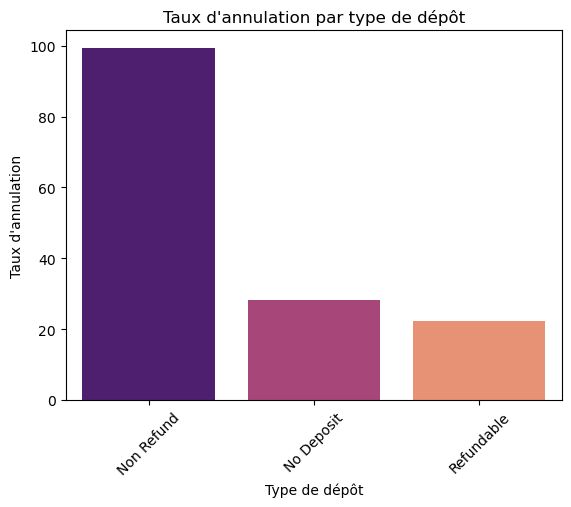

In [75]:
# Compter le nombre de reservations par type de d√©p√¥t
deposit_type_counts = hotel_df['deposit_type'].value_counts().sort_values(ascending=False)
print("Nombre de reservations par deposit_type\n",deposit_type_counts,)

# Calcul du taux d'annulation par type de d√©p√¥t
deposit_type_analysis = pd.crosstab(hotel_df['deposit_type'], hotel_df['is_canceled'], normalize='index') * 100
deposit_type_analysis.columns = ['Confirm√©', 'Annul√©']
deposit_type_analysis = deposit_type_analysis.sort_values(by="Annul√©", ascending=False)

# Affichage du tableau
print("\nTaux d'annulation par type de d√©p√¥t :")
print(deposit_type_analysis)

# Barplot des taux d'annulation par type de d√©p√¥t
sns.barplot(x=deposit_type_analysis.index, y=deposit_type_analysis['Annul√©'], 
            hue=deposit_type_analysis.index, 
            palette='magma', legend=False)
plt.title("Taux d'annulation par type de d√©p√¥t")
plt.xlabel("Type de d√©p√¥t")
plt.ylabel("Taux d'annulation")
plt.xticks(rotation=45)
plt.show()


<p style="background-color:lightblue; color:black; font-weight:bold;text-align:center;">Analyse du taux d‚Äôannulation par type de d√©p√¥t  

L‚Äôanalyse des annulations en fonction du type de d√©p√¥t r√©v√®le **une diff√©rence tr√®s marqu√©e entre les cat√©gories** :  
- **Les r√©servations avec un d√©p√¥t "Non Refund" affichent un taux d‚Äôannulation extr√™mement √©lev√© (99.4‚Äâ%)**.  
- **Les r√©servations sans d√©p√¥t ("No Deposit") ont un taux d‚Äôannulation de 28.4%**, ce qui est bien plus faible.  
- **Les r√©servations avec d√©p√¥t remboursable ("Refundable") ont le taux d‚Äôannulation le plus bas (22.2‚Äâ%)**, ce qui est logique, car ces clients peuvent r√©cup√©rer leur d√©p√¥t sans p√©nalit√©.  

**Interpr√©tation :**  
- Le **taux d‚Äôannulation √©lev√© pour "Non Refund"** semble contre-intuitif, puisqu'on pourrait penser qu‚Äôun paiement non remboursable dissuade l‚Äôannulation.  
- Cela peut √™tre li√© √† des strat√©gies commerciales :  
  - Certaines offres "Non Refund" sont propos√©es √† bas prix, attirant des clients plus enclins √† annuler en cas de changement de plans.  
  - Ces r√©servations pourraient aussi √™tre surrepr√©sent√©es chez certains segments √† fort taux d‚Äôannulation (ex: `market_segment` et `distribution_channel`).  
- Il faudra **croiser `deposit_type` avec d'autres variables** pour mieux comprendre cette dynamique.  
 

**Conclusion :**  
<p style="background-color:lightgreen; color:black; font-weight:bold;">deposit_type est une variable significative. 

.  
 <p style="background-color:blue; color:white; font-weight:bold;text-align:center;">Analyse de l‚Äôimpact de customer_type sur is_canceled

Nombre de reservations par customer_type
 customer_type
Transient          89613
Transient-Party    25124
Contract            4076
Group                577
Name: count, dtype: int64

Taux d'annulation par type de client :
                  Confirm√©     Annul√©
customer_type                        
Transient        59.253680  40.746320
Contract         69.038273  30.961727
Transient-Party  74.570132  25.429868
Group            89.774697  10.225303


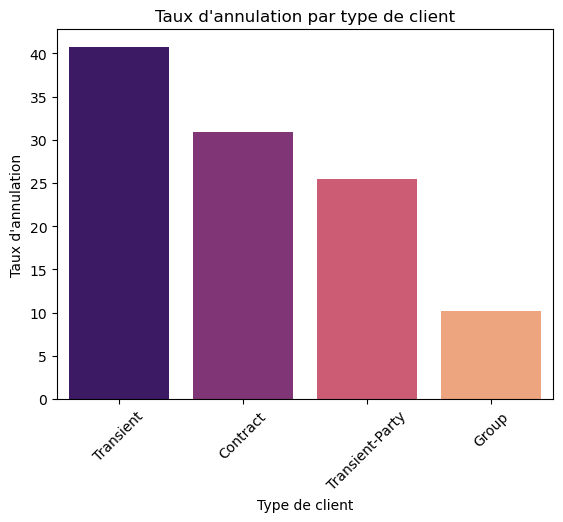

In [78]:
# Compter le nombre de reservations par type de client
customer_type_counts = hotel_df['customer_type'].value_counts().sort_values(ascending=False)
print("Nombre de reservations par customer_type\n",customer_type_counts,)

# Calcul du taux d'annulation par type de client
customer_type_analysis = pd.crosstab(hotel_df['customer_type'], hotel_df['is_canceled'], normalize='index') * 100
customer_type_analysis.columns = ['Confirm√©', 'Annul√©']
customer_type_analysis = customer_type_analysis.sort_values(by="Annul√©", ascending=False)

# Affichage du tableau
print("\nTaux d'annulation par type de client :")
print(customer_type_analysis)

# Barplot des taux d'annulation par type de client
sns.barplot(x=customer_type_analysis.index, y=customer_type_analysis['Annul√©'], 
            hue=customer_type_analysis.index, 
            palette='magma', legend=False)
plt.title("Taux d'annulation par type de client")
plt.xlabel("Type de client")
plt.ylabel("Taux d'annulation")
plt.xticks(rotation=45)
plt.show()

<p style="background-color:lightblue; color:black; font-weight:bold;text-align:center;">Analyse du taux d‚Äôannulation par type de client  

L‚Äôanalyse des annulations en fonction du type de client met en √©vidence **des √©carts significatifs** :  
- **Les clients "Transient" ont le taux d‚Äôannulation le plus √©lev√© (40.7‚Äâ%)**, ce qui peut s'expliquer par une plus grande flexibilit√© et une moindre contrainte financi√®re.  
- **Les clients "Contract" et "Transient-Party" affichent des taux d‚Äôannulation plus mod√©r√©s (31‚Äâ% et 25.4‚Äâ%)**, indiquant un engagement l√©g√®rement plus fort.  
- **Les clients "Group" ont le taux d‚Äôannulation le plus bas (10.2‚Äâ%)**, ce qui peut √™tre d√ª √† des contrats plus stricts ou des r√©servations planifi√©es longtemps √† l‚Äôavance.  

**Interpr√©tation :**  
- Les **clients "Transient" semblent √™tre les plus volatils**, ce qui peut √™tre li√© √† des r√©servations individuelles plus spontan√©es.  
- √Ä l‚Äôinverse, les **r√©servations de groupes et sous contrat sont plus stables**, car elles sont souvent planifi√©es √† l‚Äôavance et encadr√©es par des accords sp√©cifiques.  
- **Le type de client influence donc directement le taux d‚Äôannulation.**  

**Conclusion :**  
<p style="background-color:lightgreen; color:black; font-weight:bold;">customer_type est une variable significative.  

.  
 <p style="background-color:blue; color:white; font-weight:bold;text-align:center;">Analyse de l‚Äôimpact de reservation_status sur is_canceled

In [81]:
# Calcul du taux d'annulation par statut de r√©servation
reservation_status_analysis = pd.crosstab(hotel_df['reservation_status'], hotel_df['is_canceled'], normalize='index') * 100
reservation_status_analysis.columns = ['Confirm√©', 'Annul√©']

# Affichage du tableau
print("\nTaux d'annulation par statut de r√©servation :")
print(reservation_status_analysis)


Taux d'annulation par statut de r√©servation :
                    Confirm√©  Annul√©
reservation_status                  
Canceled                 0.0   100.0
Check-Out              100.0     0.0
No-Show                  0.0   100.0


 <p style="background-color:lightblue; color:black; font-weight:bold;text-align:center;">Analyse du taux d‚Äôannulation par statut de r√©servation
     
Sans grande surprise, **100‚Äâ% des r√©servations avec le statut "Canceled" ou "No-Show" sont annul√©es**, tandis que **100‚Äâ% des r√©servations "Check-Out" sont confirm√©es**.  

<p style="background-color:lightcoral; color:black; font-weight:bold;"> 
    reservation_status n'est pas une variable significative.  
    
Cette variable n‚Äôapporte **aucune valeur pr√©dictive** pour l‚Äôanalyse, car **`is_canceled` et `reservation_status` sont directement li√©s**.  
Elle sera donc **exclue** des variables explicatives lors de l‚ÄôEDA et du mod√®le pr√©dictif.  


.  

.
  
  <p style="background-color:blue;color:white; font-weight:bold; font-size:15px;text-align:center;">
R√©capitulatif des variables cat√©gorielles significatives identifi√©es

Apr√®s l‚Äôanalyse des diff√©rentes variables, voici la liste des variables ayant une **influence significative** sur les annulations (`is_canceled`).  

| **Variables cl√©s** | **Pourquoi ?** |
|-------------------|---------------|
| **hotel** | Les City Hotels ont un taux d‚Äôannulation plus √©lev√© que les Resort Hotels. |
| **meal** | Certains types de repas (ex: FB) sont associ√©s √† un taux d‚Äôannulation plus √©lev√©. |
| **country_grouped** | Les taux d‚Äôannulation varient fortement en fonction du pays des clients. |
| **market_segment** | Les groupes et les agences influencent diff√©remment le taux d‚Äôannulation. |
| **distribution_channel** | Certains canaux de distribution affichent un taux d‚Äôannulation nettement plus √©lev√©. |
| **deposit_type** | Les clients ayant pay√© un d√©p√¥t "Non Refund" annulent paradoxalement plus souvent. |
| **customer_type** | Les clients "Transient" ont un taux d‚Äôannulation beaucoup plus √©lev√© que les groupes ou les contrats. |



### **4.2.2 Distribution des variables cat√©gorielles significatives**

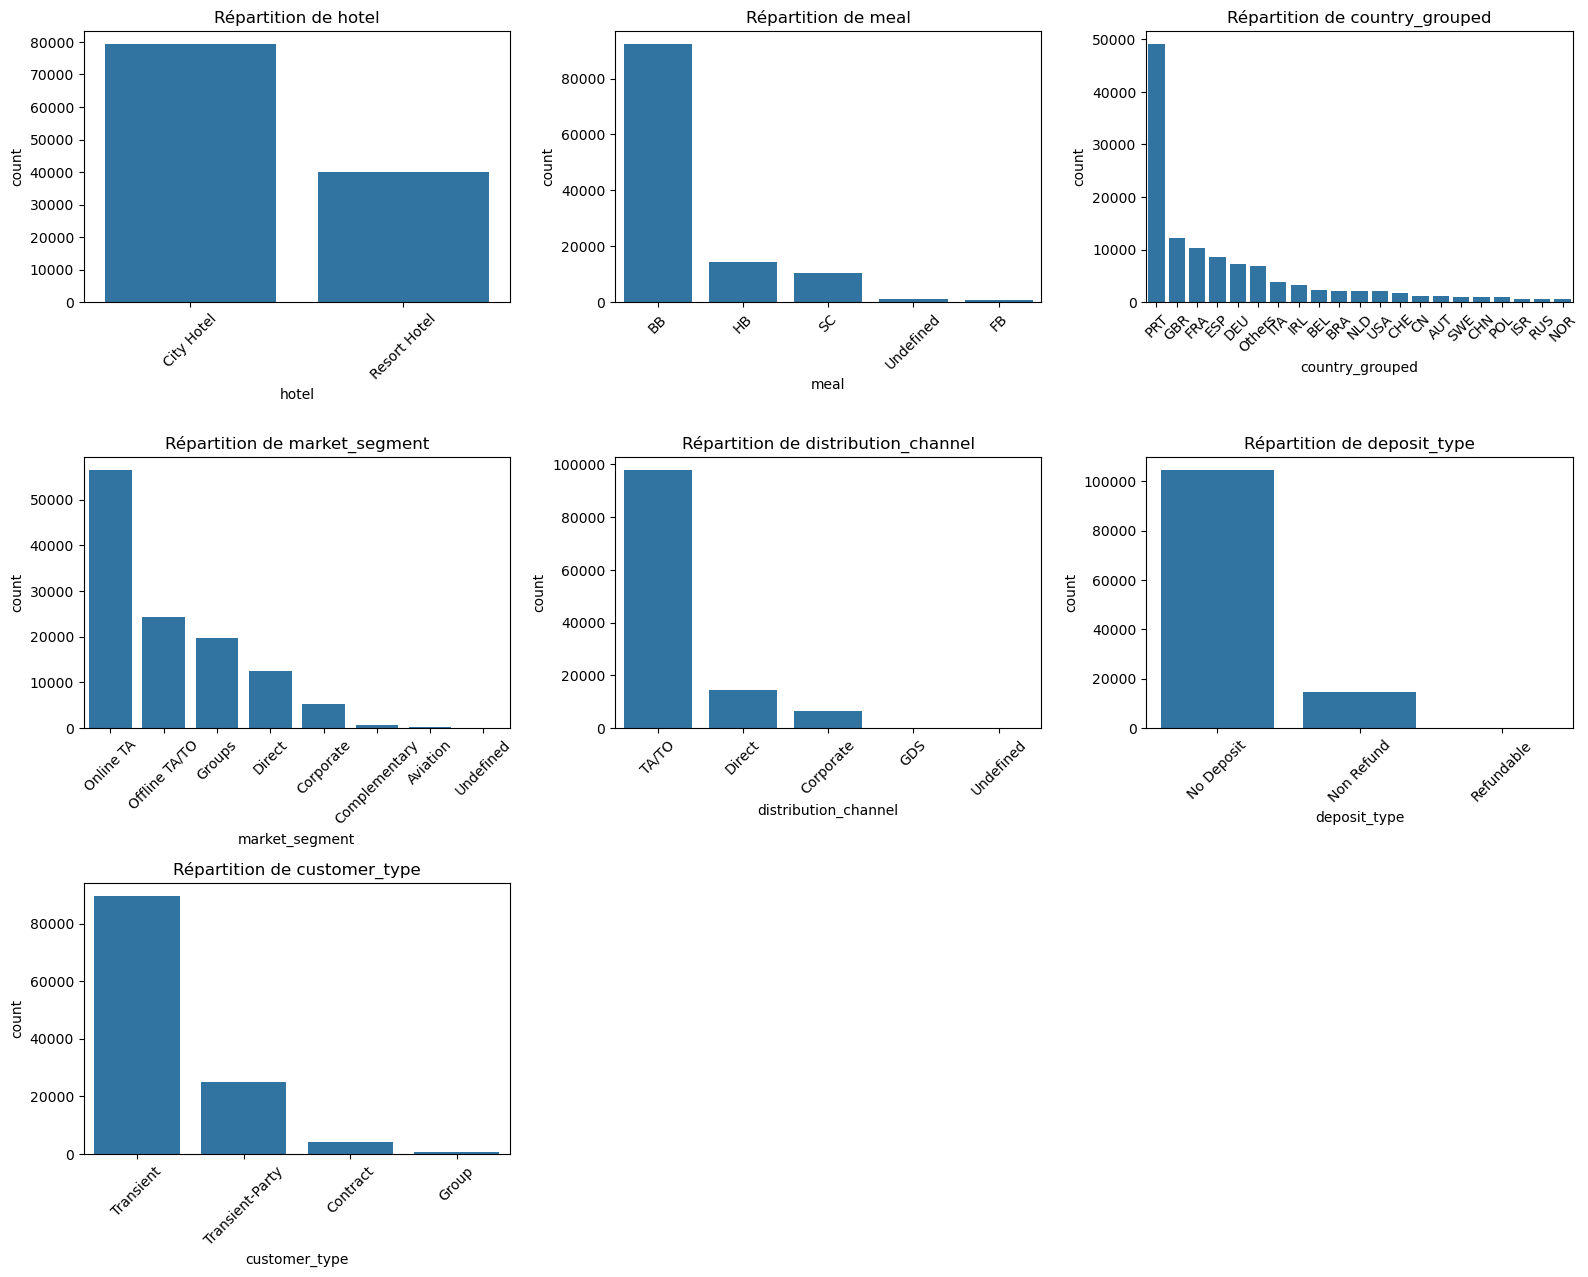

In [85]:
# Liste des variables cat√©gorielles significatives (country_grouped = les pays les plus repr√©sent√©s avec min 500 occurences)
singificativ_categorical_vars = ["hotel", "meal", "country_grouped", "market_segment", "distribution_channel",
                        "deposit_type", "customer_type"]

# Cr√©ation des barplots
plt.figure(figsize=(16, 16))
for i, var in enumerate(singificativ_categorical_vars, 1):
    plt.subplot(4, 3, i)  # Ajuster la disposition selon le nombre de variables
    sns.countplot(x=hotel_df[var], order=hotel_df[var].value_counts().index)
    plt.title(f"R√©partition de {var}")
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


 <p style="background-color:lightblue; color:black; font-weight:bold;text-align:center;"> 
Analyse des distributions et prise de d√©cision sur les transformations des variables cat√©gorielles  

Nous analysons la **r√©partition** des variables cat√©gorielles significatives afin de :  
- **√âvaluer leur dominance** (certaines cat√©gories sont-elles largement majoritaires ?).  
- **Identifier les √©ventuels d√©s√©quilibres** qui pourraient poser probl√®me en mod√©lisation.  
- **D√©terminer si un regroupement est n√©cessaire** pour √©viter d‚Äôavoir trop de cat√©gories sous-repr√©sent√©es.  
- **D√©finir les prochaines √©tapes n√©cessaires avant toute transformation.**  

**1 hotel**  
- **Les City Hotels sont bien plus nombreux que les Resort Hotels.**  
- **Implication :** Ce d√©s√©quilibre peut biaiser l‚Äôanalyse si les annulations sont fortement influenc√©es par le type d‚Äôh√¥tel.  
**Propositions de transformation**  
- Conserver `hotel` tel quel, car le d√©s√©quilibre est important, mais refl√®te une r√©alit√© commerciale.  
**D√©cision :** **Conserver `hotel` sans transformation.**  

**2 meal**  
- **Le type "BB" (Bed & Breakfast) domine largement** les autres formules.  
- Les types "FB", "SC" et "Undefined" sont **tr√®s peu repr√©sent√©s**.  
**Propositions de transformation**  
- Conserver `meal` tel quel. La distribution des cat√©gories de meal est tr√®s d√©s√©quilibr√©e, mais comme les taux d‚Äôannulation ne suivent pas cette distribution, cela sugg√®re que chaque cat√©gorie apporte une information sp√©cifique qui pourrait √™tre utile au mod√®le.  
**D√©cision :**  **Conserver `meal` sans transformation.**    

**3 country_grouped**  
- **Le Portugal (PRT) repr√©sente la majorit√© des clients.**  
- Un long tail de pays peu repr√©sent√©s est visible.  
**Propositions de transformation**  
- **Le regroupement actuel est valid√©**, car il permet de capturer les diff√©rences importantes de volumes tout en maintenant une granularit√© suffisante.  
- Le seuil de **500 occurrences** pour la classification semble ad√©quat pour √©viter les groupes trop petits.  
**D√©cision :** **Conserver country_grouped tel quel sans modification.**  
**Le regroupement des pays en "Others" est pertinent** et ne n√©cessite pas d‚Äôajustement.  

**4 market_segment**  
- **"Online TA" est dominant**, suivi de `Offline TA/TO` et `Groups`.  
- **Les segments `Corporate`, `Complementary`, `Aviation` et `Undefined` sont rares**.  
**Propositions de transformation**  
- Cette variable pourrait √™tre en **redondance avec `deposit_type` et `distribution_channel`**, ce qui n√©cessitera une v√©rification.  
- **Avant de prendre une d√©cision**, une analyse crois√©e avec ces variables devra √™tre effectu√©e pour confirmer son importance et son impact sur `is_canceled`.  
**D√©cision provisoire :** **La d√©cision finale sera prise apr√®s l‚Äôanalyse des croisements avec `deposit_type` et `distribution_channel`**.  

**5 distribution_channel**  
- **"TA/TO" est le principal canal de distribution**, tr√®s dominant.  
**Propositions de transformation**  
- Il est possible que `distribution_channel` soit fortement corr√©l√© avec `market_segment`, ce qui pourrait justifier sa suppression.  
- **Avant de conclure**, un test de d√©pendance statistique (Khi¬≤) devra √™tre effectu√© pour v√©rifier s‚Äôil apporte une information distincte.  
**D√©cision provisoire :** **L‚Äôanalyse de sa redondance avec `market_segment` sera men√©e avant de trancher sur son utilisation.**  

**6 deposit_type**  
- **"No Deposit" est majoritaire**, suivi de `Non Refund`.  
- **Le taux d‚Äôannulation paradoxalement √©lev√© pour "Non Refund" doit √™tre explor√©**.  
**Propositions de transformation**  
- `deposit_type` pourrait √™tre en interaction forte avec `market_segment` et `customer_type`.  
- **Avant de prendre une d√©cision**, une analyse crois√©e avec ces variables devra √™tre r√©alis√©e pour √©valuer sa pertinence.  
**D√©cision provisoire :** **L‚Äôanalyse de son interaction avec `market_segment` et `customer_type` sera effectu√©e avant de valider son maintien.**  

**7 customer_type**  
- **Les clients "Transient" sont largement dominants**.  
- **"Contract" et "Group" sont peu nombreux**.  
**Propositions de transformation**  
- **Il est possible que `customer_type` soit li√© √† `market_segment` et `deposit_type`**.  
- **Avant de prendre une d√©cision**, un test d‚Äôind√©pendance sera r√©alis√© pour d√©terminer s‚Äôil apporte une information compl√©mentaire.  
**D√©cision provisoire :** **Son interaction avec `market_segment` et `deposit_type` sera √©tudi√©e avant d‚Äôappliquer une transformation.**  

**Synth√®se des d√©cisions de transformation**  

| **Variable** | **Transformation** | **Prochaine √©tape** |
|-------------|------------------------------|-------------------|
| `hotel` | Aucune transformation | Conserver la variable telle quelle |
| `meal` |  Aucune transformation | Conserver la variable telle quelle |
| `country_grouped` | Conservation du groupement   | Conserver le groupement tel quel |

**Synth√®se des d√©cisions provisoires** 

| **Variable** | **Transformation** | **Prochaine √©tape** |
|-------------|------------------------------|-------------------|
| `market_segment` | Suppression possible | V√©rifier sa redondance avec `deposit_type` et `distribution_channel` |
| `distribution_channel` | Suppression possible | V√©rifier sa redondance avec `market_segment` |
| `deposit_type` | Conserver ou modifier selon les interactions | V√©rifier son lien avec `market_segment` et `customer_type` |
| `customer_type` | Fusionner les cat√©gories rares | V√©rifier son interaction avec `market_segment` et `deposit_type` |

**Prochaine √©tape :**  
Effectuer les **derni√®res analyses restantes** et valider les transformations finales avant de passer au **Data Preprocessing**.  


### **4.2.3 Analyses  restantes entre variables cat√©gorielles significatives et d√©cisions sur les transformations √† appliquer**

.  
   <p style="background-color:purple;color:white; font-weight:bold; font-size:17px;text-align:center;">
       Croisement de market_segment et distribution_channel


R√©partition des `market_segment` selon `distribution_channel` (% des observations par segment) :


distribution_channel  Corporate     Direct       GDS      TA/TO   Undefined
market_segment                                                             
Aviation              95.780591   0.000000  0.000000   4.219409    0.000000
Complementary         11.978466  77.523553  0.000000  10.497981    0.000000
Corporate             90.424929   3.248347  0.000000   6.326723    0.000000
Direct                 0.713946  97.382199  0.007933   1.880057    0.015865
Groups                 6.198577   7.430216  0.000000  86.371208    0.000000
Offline TA/TO          0.875346   0.066064  0.185805  98.872786    0.000000
Online TA              0.076137   0.235494  0.260283  99.426315    0.001771
Undefined              0.000000   0.000000  0.000000   0.000000  100.000000

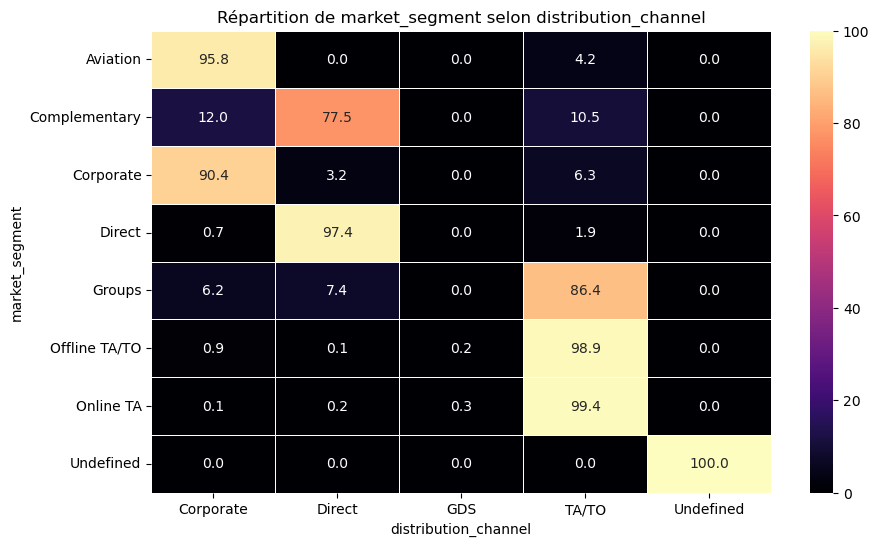

In [89]:
# Tableau crois√© pour analyser la distribution conjointe
market_distribution_crosstab = pd.crosstab(hotel_df['market_segment'], hotel_df['distribution_channel'], normalize='index') * 100

# Affichage du tableau crois√©
print("R√©partition des `market_segment` selon `distribution_channel` (% des observations par segment) :")
display(market_distribution_crosstab)

# Visualisation avec une heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(market_distribution_crosstab, annot=True, fmt=".1f", cmap="magma", linewidths=0.5)
plt.title("R√©partition de market_segment selon distribution_channel")
plt.xlabel("distribution_channel")
plt.ylabel("market_segment")
plt.show()


<p style="background-color:pink; color:black; font-weight:bold;text-align:center;">Analyse du croisement entre market_segment et distribution_channel

**R√©sum√© des r√©sultats**  
- Certains segments sont **quasi exclusivement** associ√©s √† un seul canal de distribution :  
  - **Aviation** ‚Üí **95.8‚Äâ% Corporate**  
  - **Corporate** ‚Üí **90.4‚Äâ% Corporate**  
  - **Direct** ‚Üí **97.4‚Äâ% Direct**  
  - **Offline TA/TO** ‚Üí **98.9‚Äâ% TA/TO**  
  - **Online TA** ‚Üí **99.4‚Äâ% TA/TO**  
  - **Groups** ‚Üí **86.4‚Äâ% TA/TO**  
  - **Complementary** ‚Üí **77.5‚Äâ% Direct**  
- Le canal **Undefined** est une cat√©gorie isol√©e qui devra √™tre supprim√©e.  

**Interpr√©tation**  
- Il existe un **fort recouvrement** entre `market_segment` et `distribution_channel`, certains segments √©tant li√©s √† un canal unique.  
- Cette forte liaison sugg√®re une **possible redondance** entre les deux variables.  

**D√©cision provisoire**  
- Il est n√©cessaire de **quantifier cette relation** pour savoir si `distribution_channel` apporte une information suppl√©mentaire ou non.
  
**Prochaine √©tape :** Calculer la **corr√©lation entre `market_segment` et `distribution_channel`** pour v√©rifier l‚Äôampleur de leur liaison.


.  
 <p style="background-color:purple; color:white; font-weight:bold;text-align:center;">V√©rification de la relation entre market_segment et distribution_channel

In [92]:
# Encodage Label Encoding pour transformer les cat√©gories en valeurs num√©riques
encoder = LabelEncoder()
hotel_df["market_segment_encoded"] = encoder.fit_transform(hotel_df["market_segment"])
hotel_df["distribution_channel_encoded"] = encoder.fit_transform(hotel_df["distribution_channel"])

# Calculer la corr√©lation entre les deux variables
correlation = hotel_df["market_segment_encoded"].corr(hotel_df["distribution_channel_encoded"])
print(f"Corr√©lation entre market_segment et distribution_channel : {correlation:.4f}")


Corr√©lation entre market_segment et distribution_channel : 0.7678


<p style="background-color:pink; color:black; font-weight:bold;text-align:center;">
     Analyse de la v√©rification de la relation entre market_segment et distribution_channel

Nous avons encod√© les variables `market_segment` et `distribution_channel` pour mesurer leur **corr√©lation mutuelle.**

**R√©sultat :**  
**Corr√©lation entre `market_segment` et `distribution_channel` ‚Üí 0.7678**

**Interpr√©tation :**
- **Un score de 0.76 indique une forte corr√©lation** entre les deux variables.
- Cela signifie que `market_segment` et `distribution_channel` capturent **une information similaire**, ce qui sugg√®re une potentielle redondance.
- Toutefois, une forte corr√©lation ne prouve pas √† elle seule que l‚Äôune des variables est inutile.
  
**Conclusion provisoire :**
- Cette corr√©lation √©lev√©e indique qu'il pourrait √™tre pertinent de **supprimer `distribution_channel`** pour √©viter la multicolin√©arit√©.
- **Avant toute suppression**, nous devons **confirmer statistiquement cette d√©pendance**.

**Prochaine √©tape :** Appliquer un **test du Khi¬≤ d‚Äôind√©pendance** pour v√©rifier si `market_segment` et `distribution_channel` sont statistiquement li√©s.  
Si le test confirme une **forte d√©pendance**, nous pourrons valider la suppression de `distribution_channel`.  


.  
 <p style="background-color:purple; color:white; font-weight:bold;text-align:center;">
     Application du test du Khi¬≤ pour market_segment et distribution_channel

In [95]:
# Cr√©ation de la table de contingence (nombre d‚Äôobservations pour chaque combinaison)
contingency_table_market_segment_distribution_channel = pd.crosstab(hotel_df['market_segment'], 
                                                                    hotel_df['distribution_channel'])

# Application du test du Khi¬≤
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table_market_segment_distribution_channel)

# Affichage des r√©sultats
print(f"Statistique de Khi¬≤ : {chi2_stat:.4f}")
print(f"p-value : {p_value:.4e}")

# Interpr√©tation du r√©sultat
if p_value < 0.05:
    print("R√©sultat : Les variables sont d√©pendantes (p-value < 0.05). Il y a redondance d‚Äôinformation.")
else:
    print("R√©sultat : Les variables sont ind√©pendantes (p-value >= 0.05). Elles apportent des informations distinctes.")

Statistique de Khi¬≤ : 228659.9223
p-value : 0.0000e+00
R√©sultat : Les variables sont d√©pendantes (p-value < 0.05). Il y a redondance d‚Äôinformation.


<p style="background-color:pink; color:black; font-weight:bold;text-align:center;">
    Analyse des r√©sultats du test du Khi¬≤ d‚Äôind√©pendance entre market_segment et distribution_channel</p>

**Nous avons effectu√© un test du Khi¬≤ pour √©valuer la d√©pendance entre `market_segment` et `distribution_channel`.**  

**R√©sultats statistiques :**  
- **Statistique de Khi¬≤** : 228659.9223  
- **p-value** : 0.0000e+00  

**Interpr√©tation :**  
- La **p-value est extr√™mement faible (< 0.05)**, ce qui indique une **forte d√©pendance statistique** entre les deux variables.
- - De plus,**la statistique de Khi¬≤ est de 228 659**, ce qui est tr√®s √©lev√© et confirme une d√©pendance extr√™mement forte entre `market_segment` et `distribution_channel`.
- Cela signifie que `market_segment` et `distribution_channel` **capturent en grande partie la m√™me information**.  
- **Garder les deux pourrait introduire de la redondance** et potentiellement causer des probl√®mes de multicolin√©arit√© dans les mod√®les pr√©dictifs.  

**Conclusion finale :**  
<p style="background-color:lightcoral; color:black; font-weight:bold;">Supprimer distribution_channel
<p style="background-color:lightgreen; color:black; font-weight:bold;">Conserver market_segment
    
- Cette d√©cision sera appliqu√©e lors du **Data Preprocessing**.  

.  
   <p style="background-color:purple;color:white; font-weight:bold; font-size:17px;text-align:center;">
     Croisement deposit_type & market_segment

R√©partition des `deposit_type` selon `market_segment` (% des observations par type de d√©p√¥t) :


market_segment  Aviation  Complementary  Corporate     Direct     Groups  \
deposit_type                                                               
No Deposit      0.226489       0.710047   4.737149  12.023012  10.042909   
Non Refund      0.000000       0.000000   2.289710   0.130253  62.877905   
Refundable      0.000000       0.000000   2.469136   3.703704  80.246914   

market_segment  Offline TA/TO  Online TA  Undefined  
deposit_type                                         
No Deposit          18.357049  53.901434   0.001911  
Non Refund          34.318229   0.383903   0.000000  
Refundable           2.469136  11.111111   0.000000

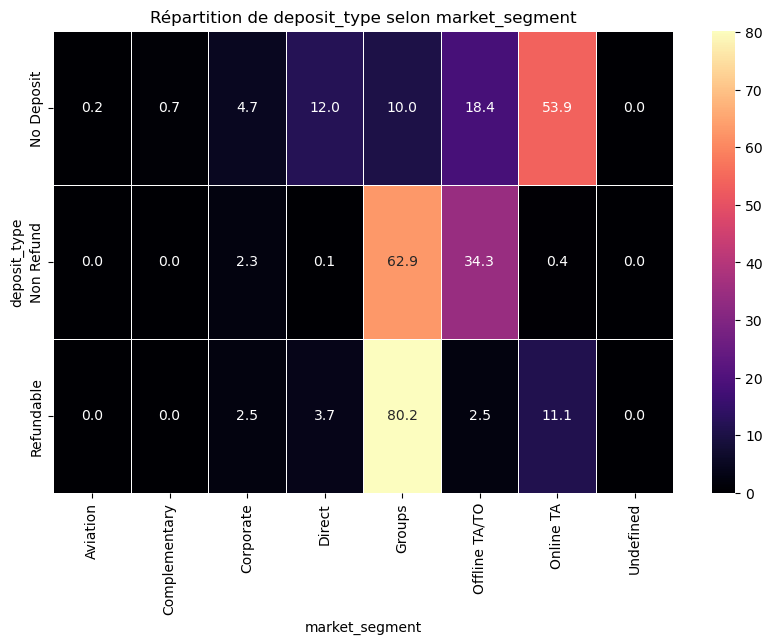

In [98]:
# Tableau crois√© pour analyser la distribution conjointe
deposit_market_crosstab = pd.crosstab(hotel_df['deposit_type'], hotel_df['market_segment'], normalize='index') * 100

# Affichage du tableau crois√©
print("R√©partition des `deposit_type` selon `market_segment` (% des observations par type de d√©p√¥t) :")
display(deposit_market_crosstab)

# Visualisation avec un heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(deposit_market_crosstab, annot=True, fmt=".1f", cmap="magma", linewidths=0.5)
plt.title("R√©partition de deposit_type selon market_segment")
plt.xlabel("market_segment")
plt.ylabel("deposit_type")
plt.show()


<p style="background-color:pink; color:black; font-weight:bold;text-align:center;">Analyse du croisement entre deposit_type et market_segment

**R√©sum√© des r√©sultats**  
- No Deposit est dominant dans Online TA (53.9‚Äâ%) et Offline TA/TO (18.4‚Äâ%).  
- Non Refund est majoritairement associ√© aux Groupes (62.9‚Äâ%) et Offline TA/TO (34.3‚Äâ%).  
- Refundable est principalement utilis√© par les Groupes (80.2‚Äâ%) et une faible part en Online TA (11.1‚Äâ%).  

**Interpr√©tation**  
- Il existe une relation forte entre `deposit_type` et `market_segment`, certaines cat√©gories √©tant fortement associ√©es √† un type de d√©p√¥t sp√©cifique.  
- Cette relation pourrait entra√Æner une redondance si les deux variables sont conserv√©es simultan√©ment dans le mod√®le.  
- Le type `Non Refund` est largement concentr√© sur les Groupes et Offline TA/TO, mais son impact sur les annulations doit √™tre √©valu√©.  
- Si `deposit_type` influence fortement `is_canceled`, il pourrait √™tre plus pertinent que `market_segment` dans certains cas.  

**D√©cision provisoire**  
- V√©rifier si `deposit_type` apporte une information suppl√©mentaire par rapport √† `market_segment` en comparant leurs corr√©lations avec `is_canceled`.  
- Si `deposit_type` est redondant, il faudra envisager de ne garder qu‚Äôune seule des deux variables ou de les fusionner.  

**Prochaine √©tape :** Comparer les corr√©lations de `deposit_type` et `market_segment` avec `is_canceled` pour prendre une d√©cision.  


.  
 <p style="background-color:purple; color:white; font-weight:bold;text-align:center;">Influence de deposit_type et market_segment sur is_canceled

In [101]:
# V√©rifier la corr√©lation de chaque variable avec is_canceled
corr_deposit_type = hotel_df['deposit_type'].astype('category').cat.codes.corr(hotel_df['is_canceled'])
corr_market_segment = hotel_df['market_segment'].astype('category').cat.codes.corr(hotel_df['is_canceled'])

print(f"Corr√©lation deposit_type vs is_canceled : {corr_deposit_type:.4f}")
print(f"Corr√©lation market_segment vs is_canceled : {corr_market_segment:.4f}")

Corr√©lation deposit_type vs is_canceled : 0.4686
Corr√©lation market_segment vs is_canceled : 0.0593


<p style="background-color:pink; color:black; font-weight:bold;text-align:center;">
Analyse de l'influence de deposit_type et market_segment sur is_canceled


**Comparaison des corr√©lations avec is_canceled**  
- Corr√©lation `deposit_type` vs `is_canceled` : **0.4686**  
- Corr√©lation `market_segment` vs `is_canceled` : **0.0593**  

**Interpr√©tation**  
- `deposit_type` pr√©sente une corr√©lation bien plus forte avec `is_canceled`, sugg√©rant qu'il joue un r√¥le majeur dans la pr√©diction des annulations.  
- √Ä l‚Äôinverse, `market_segment` a une corr√©lation tr√®s faible, ce qui indique qu‚Äôil pourrait avoir un impact limit√© sur les annulations.  
- Cette diff√©rence montre que `deposit_type` capture une information plus pertinente que `market_segment` concernant les comportements d‚Äôannulation.  

**D√©cision provisoire**  
- `deposit_type` semble √™tre une variable cl√© √† conserver pour la mod√©lisation.  
- `market_segment`, avec sa faible corr√©lation, pourrait √™tre moins pertinent et √©ventuellement supprim√©.  
- Avant toute suppression, il faudra v√©rifier s'il contient tout de m√™me des informations compl√©mentaires non couvertes par `deposit_type`.  

**Prochaine √©tape**  
- Appliquer un **test du Khi¬≤ d‚Äôind√©pendance** pour v√©rifier si `deposit_type` et `market_segment` sont statistiquement li√©s.  
Si le test confirme une **forte d√©pendance**, nous pourrons valider la suppression de `market_segment`.  


.  
 <p style="background-color:purple; color:white; font-weight:bold;text-align:center;">
     Application du test du Khi¬≤ pour deposit_type et market_segment

In [104]:
# Cr√©ation de la table de contingence (nombre d‚Äôobservations pour chaque combinaison)
contingency_table_deposit_type_market_segment = pd.crosstab(hotel_df['deposit_type'], hotel_df['market_segment'])

# Application du test du Khi¬≤
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table_deposit_type_market_segment)

# Affichage des r√©sultats
print(f"Statistique de Khi¬≤ : {chi2_stat:.4f}")
print(f"p-value : {p_value:.4e}")

# Interpr√©tation du r√©sultat
if p_value < 0.05:
    print("R√©sultat : Les variables sont d√©pendantes (p-value < 0.05). Il y a redondance d‚Äôinformation.")
else:
    print("R√©sultat : Les variables sont ind√©pendantes (p-value >= 0.05). Elles apportent des informations distinctes.")

Statistique de Khi¬≤ : 33397.9120
p-value : 0.0000e+00
R√©sultat : Les variables sont d√©pendantes (p-value < 0.05). Il y a redondance d‚Äôinformation.


<p style="background-color:pink; color:black; font-weight:bold;text-align:center;">
    Analyse des r√©sultats du test du Khi¬≤ d‚Äôind√©pendance entre deposit_type et market_segment</p>

**Nous avons effectu√© un test du Khi¬≤ pour √©valuer la d√©pendance entre `deposit_type` et `market_segment`.**  

**R√©sultats statistiques :**  
- **Statistique de Khi¬≤** : 33 397.9120  
- **p-value** : 0.0000e+00  

**Interpr√©tation :**  
- La **p-value est extr√™mement faible (< 0.05)**, ce qui indique une **forte d√©pendance statistique** entre les deux variables.
- De plus, **la statistique de Khi¬≤ est de 33 397** *(m√™me si moins forte que celle du croisement market_segment et distribution_channel)* montrant une d√©pendance encore plus marqu√©e que dans le premier cas.
- Cela signifie que `deposit_type` et `market_segment` **capturent en grande partie la m√™me information**.  
- **Garder les deux pourrait introduire de la redondance** et potentiellement causer des probl√®mes de multicolin√©arit√© dans les mod√®les pr√©dictifs.  

**Conclusion finale :**  
<p style="background-color:lightcoral; color:black; font-weight:bold;">Supprimer market_segment</p>
<p style="background-color:lightgreen; color:black; font-weight:bold;">Conserver deposit_type</p>

- Cette d√©cision sera appliqu√©e lors du **Data Preprocessing**.  


.  
   <p style="background-color:purple;color:white; font-weight:bold; font-size:17px;text-align:center;">
     Croisement deposit_type & customer_type

R√©partition des `deposit_type` selon `customer_type` (% des observations par type de d√©p√¥t) :


customer_type  Contract     Group  Transient  Transient-Party
deposit_type                                                 
No Deposit     3.373439  0.543764  73.282939        22.799859
Non Refund     3.729348  0.000000  88.496607         7.774045
Refundable     1.234568  4.938272  12.345679        81.481481

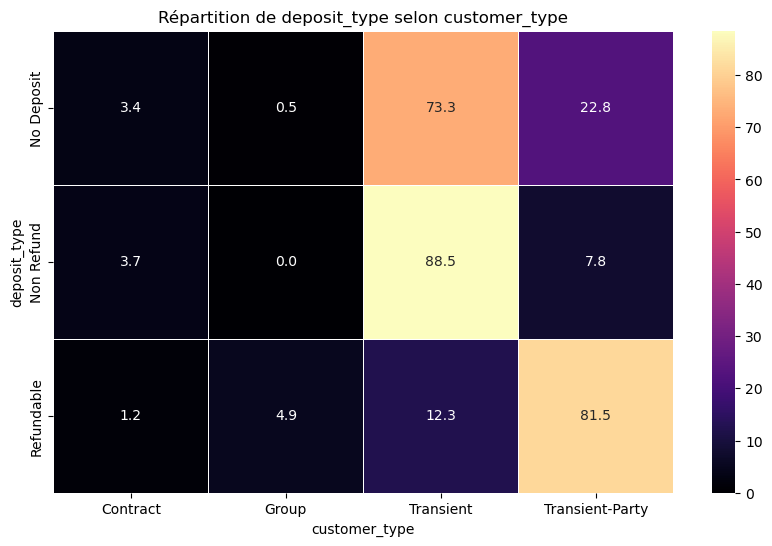

In [107]:
# Tableau crois√© pour analyser la distribution conjointe
deposit_customer_crosstab = pd.crosstab(hotel_df['deposit_type'], hotel_df['customer_type'], normalize='index') * 100

# Affichage du tableau crois√©
print("R√©partition des `deposit_type` selon `customer_type` (% des observations par type de d√©p√¥t) :")
display(deposit_customer_crosstab)

# Visualisation avec un heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(deposit_customer_crosstab, annot=True, fmt=".1f", cmap="magma", linewidths=0.5)
plt.title("R√©partition de deposit_type selon customer_type")
plt.xlabel("customer_type")
plt.ylabel("deposit_type")
plt.show()

<p style="background-color:pink; color:black; font-weight:bold;text-align:center;">
Analyse du croisement entre deposit_type et customer_type</p>

**R√©sum√© des r√©sultats**  
- **No Deposit** est dominant chez les **clients Transient (73.3‚Äâ%)**, suivi des **clients Transient-Party (22.8‚Äâ%)**.  
- **Non Refund** est **majoritairement utilis√© par les clients Transient (88.5‚Äâ%)**, avec une part plus faible chez les **clients Transient-Party (7.8‚Äâ%)**.  
- **Refundable** est **principalement associ√© aux clients Transient-Party (81.5‚Äâ%)**, tandis que les autres cat√©gories en utilisent tr√®s peu.  

**Interpr√©tation**  
- Il existe une **relation forte entre `deposit_type` et `customer_type`**, certaines cat√©gories √©tant fortement associ√©es √† un type de d√©p√¥t sp√©cifique.  
- **Les clients Transient utilisent massivement No Deposit et Non Refund**, tandis que les **clients Transient-Party privil√©gient Refundable**.  
- **Les clients Group et Contract sont tr√®s minoritaires**, ce qui peut limiter leur impact dans l‚Äôanalyse.  
- Cette d√©pendance pourrait entra√Æner une **redondance** si les deux variables sont conserv√©es simultan√©ment dans le mod√®le.  

**D√©cision provisoire**  
- V√©rifier si `deposit_type` et `customer_type` apportent **une information compl√©mentaire** ou s‚Äôils sont redondants en comparant leurs **corr√©lations avec `is_canceled`**.  
- Si `customer_type` est peu corr√©l√© √† `is_canceled`, alors `deposit_type` pourrait suffire √† expliquer le comportement d‚Äôannulation.  

**Prochaine √©tape :** Comparer les **corr√©lations de `deposit_type` et `customer_type` avec `is_canceled`** pour prendre une d√©cision.  

.  
 <p style="background-color:purple; color:white; font-weight:bold;text-align:center;">Influence de deposit_type et customer_type sur is_canceled

In [110]:
# V√©rifier la corr√©lation de chaque variable avec is_canceled
corr_deposit_type = hotel_df['deposit_type'].astype('category').cat.codes.corr(hotel_df['is_canceled'])
corr_customer_type = hotel_df['customer_type'].astype('category').cat.codes.corr(hotel_df['is_canceled'])

print(f"Corr√©lation deposit_type vs is_canceled : {corr_deposit_type:.4f}")
print(f"Corr√©lation customer_type vs is_canceled : {corr_customer_type:.4f}")

Corr√©lation deposit_type vs is_canceled : 0.4686
Corr√©lation customer_type vs is_canceled : -0.0681


<p style="background-color:pink; color:black; font-weight:bold;text-align:center;">
Analyse de l'influence de deposit_type et customer_type sur is_canceled

**Comparaison des corr√©lations avec is_canceled**  
- **Corr√©lation `deposit_type` vs `is_canceled` : 0.4686**  
- **Corr√©lation `customer_type` vs `is_canceled` : -0.0681**  

**Interpr√©tation**  
- `deposit_type` pr√©sente une **corr√©lation forte et positive avec is_canceled**, indiquant que cette variable joue un **r√¥le majeur** dans la pr√©diction des annulations.  
- `customer_type` a une **corr√©lation tr√®s faible et n√©gative**, sugg√©rant qu‚Äôil a un impact **quasiment n√©gligeable** sur les annulations.  
- Cette diff√©rence montre que `deposit_type` est une variable **clairement plus pertinente** que `customer_type` pour pr√©dire `is_canceled`.  

**D√©cision provisoire**  
- Puisque `deposit_type` a une **forte influence** et que `customer_type` semble **moins pertinent**, il est n√©cessaire de v√©rifier si `customer_type` apporte **une information compl√©mentaire**.  


**Prochaine √©tape** : Appliquer un **test du Khi¬≤ d‚Äôind√©pendance** entre `deposit_type` et `customer_type` pour √©valuer leur redondance.  
**Si elles sont d√©pendantes** ‚Üí Il pourrait √™tre pertinent de **supprimer `customer_type`**.  
 **Si elles sont ind√©pendantes** ‚Üí `customer_type` capture une information unique et peut √™tre conserv√©.  


.  
 <p style="background-color:purple; color:white; font-weight:bold;text-align:center;">
     Application du test du Khi¬≤ pour deposit_type et customer_type

In [113]:
# Cr√©ation de la table de contingence (nombre d‚Äôobservations pour chaque combinaison)
contingency_table_deposit_type_customer_type = pd.crosstab(hotel_df['deposit_type'], hotel_df['customer_type'])

# Application du test du Khi¬≤
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table_deposit_type_customer_type)

# Affichage des r√©sultats
print(f"Statistique de Khi¬≤ : {chi2_stat:.4f}")
print(f"p-value : {p_value:.4e}")

# Interpr√©tation du r√©sultat
if p_value < 0.05:
    print("R√©sultat : Les variables sont d√©pendantes (p-value < 0.05). Il y a redondance d‚Äôinformation.")
else:
    print("R√©sultat : Les variables sont ind√©pendantes (p-value >= 0.05). Elles apportent des informations distinctes.")

Statistique de Khi¬≤ : 2286.8608
p-value : 0.0000e+00
R√©sultat : Les variables sont d√©pendantes (p-value < 0.05). Il y a redondance d‚Äôinformation.


<p style="background-color:pink; color:black; font-weight:bold;text-align:center;">
    Analyse des r√©sultats du test du Khi¬≤ d‚Äôind√©pendance entre deposit_type et customer_type</p>

**Nous avons effectu√© un test du Khi¬≤ pour √©valuer la d√©pendance entre `deposit_type` et `customer_type`.**  

**R√©sultats statistiques :**  
- **Statistique de Khi¬≤** : 2 286.8608  
- **p-value** : 0.0000e+00  

**Interpr√©tation**  
- La **p-value est extr√™mement faible (< 0.05)**, ce qui indique une **forte d√©pendance statistique** entre les deux variables.  
- De plus, **la statistique de Khi¬≤ est de 2 286**, ce qui montre une d√©pendance marqu√©e, bien que moins forte que dans d'autres croisements analys√©s.  
- Cela signifie que `deposit_type` et `customer_type` **capturent en partie la m√™me information**, sugg√©rant une possible redondance.  
- **Garder les deux variables pourrait introduire une duplication d‚Äôinformation**, ce qui pourrait nuire √† l‚Äôefficacit√© du mod√®le pr√©dictif.  

**Conclusion finale :**  
<p style="background-color:lightcoral; color:black; font-weight:bold;">Supprimer market_segment</p>
<p style="background-color:lightgreen; color:black; font-weight:bold;">Conserver deposit_type</p>

- Cette d√©cision sera appliqu√©e lors du **Data Preprocessing**.



### **4.2.4 R√©capitulatif des d√©cisions sur les transformations √† appliquer (variables cat√©gorielles)**

 <p style="background-color:purple;color:white; font-weight:bold; font-size:18px;text-align:center;">    
    R√©capitulatif des variables cat√©gorielles significatives et transformations √† appliquer

**Variables cat√©gorielles significatives identifi√©es**  
Nous avons s√©lectionn√© les **variables cat√©gorielles les plus pertinentes** pour expliquer `is_canceled`.  
L‚Äôanalyse de leur **distribution**, de leurs **relations avec is_canceled**, ainsi que des **tests de d√©pendance (Khi¬≤)** nous a permis de d√©terminer les transformations n√©cessaires avant leur utilisation en mod√©lisation.  
  
.  
**Liste des variables cat√©gorielles significatives :**  
| **Variable** | **Observations** | **Probl√®mes identifi√©s** |
|-------------|-----------------|---------------------------|
| `hotel` | Deux cat√©gories bien distinctes (`City Hotel`, `Resort Hotel`) | Aucune transformation n√©cessaire |
| `meal` | Forte dominance de `BB`, autres cat√©gories peu fr√©quentes | N√©cessit√© de v√©rifier leur impact sur `is_canceled` |
| `country_grouped` | Pr√©sence d‚Äôun regroupement bas√© sur la fr√©quence des pays | V√©rification de la pertinence du regroupement |
| `market_segment` | Forte d√©pendance avec `deposit_type` et `customer_type` | Redondance confirm√©e (test Khi¬≤) |
| `distribution_channel` | Fortement li√© √† `market_segment` | Redondance confirm√©e (test Khi¬≤) |
| `deposit_type` | Forte corr√©lation avec `is_canceled` (+0.4686) | Aucune transformation n√©cessaire |
| `customer_type` | D√©pendant de `deposit_type`, mais apportant une information compl√©mentaire | Aucune transformation n√©cessaire |
  
.  
**Transformations pr√©vues pour la mod√©lisation**  
Certaines variables n√©cessitent des transformations avant leur utilisation dans un mod√®le.  
Les d√©cisions ont √©t√© prises en fonction des **analyses de distribution**, des **relations avec is_canceled**, et des **tests Khi¬≤**.

| **Variable** | **Transformation √† appliquer** | **Justification** |
|-------------|------------------------------|-------------------|
| `hotel` | **Label Encoding** | Variable binaire directement exploitable |
| `meal` | **Label Encoding** | Les taux d‚Äôannulation ne suivent pas la distribution des cat√©gories, chaque modalit√© semble apporter une information pertinente |
| `country_grouped` | **Conserver le regroupement  / One-Hot Encoding** | Le regroupement bas√© sur la fr√©quence des pays est pertinent et a √©t√© valid√© |
| `market_segment` | **Suppression** | Fortement redondant avec `deposit_type` et `customer_type` (confirm√© par Khi¬≤) |
| `distribution_channel` | **Suppression** | Redondance avec `market_segment`, confirm√© par Khi¬≤ |
| `deposit_type` | **Label Encoding** | Forte corr√©lation avec `is_canceled`, apporte une information cl√© |
| `customer_type` | **Label Encoding** | Malgr√© sa d√©pendance avec `deposit_type`, il apporte une information compl√©mentaire |

.  
**Transition vers le Data Preprocessing**  
Afin de conserver une **s√©paration stricte entre l‚ÄôEDA et le Data Preprocessing**, **aucune transformation n‚Äôest appliqu√©e ici**.  
Toutes les modifications mentionn√©es ci-dessus seront mises en ≈ìuvre **dans la partie Data Preprocessing**, o√π leur impact sur la distribution des variables et la performance du mod√®le sera valid√©.


## **4.3 Identification des Effets Temporels sur les Annulations**

### **4.3.1 Identification des variables Datetime significatives**

.  
<p style="background-color:DarkGreen; color:white; font-weight:bold;text-align:center;">Identification des variables datetime du dataset


In [120]:
# S√©lectionner uniquement les colonnes  datetime64[ns]
datetime64_cols = hotel_df.select_dtypes(include='datetime64[ns]').columns

# Afficher la liste des colonnes datetime64
print("Variables datetime64 dans le dataset :")
print(datetime64_cols)


Variables datetime64 dans le dataset :
Index(['reservation_status_date', 'arrival_datetime'], dtype='object')


.  
<p style="background-color:DarkGreen; color:white; font-weight:bold;text-align:center;">Analyse de l‚Äôimpact de reservation_status_date sur is_canceled

Le probl√®me pour analyser reservation_status_date est qu'**il y a √©norm√©ment de cat√©gories (date)** ce qui rendrait l'analyse illisible si on affichait toutes les valeurs.  
Mais il nous est possible de regrouper ces dates par mois et ann√©es *(au format YYYY-MM)* afin de faciliter la lecture.   
***Solution : Cr√©er `reservation_status_month` pour regrouper les dates par mois et ann√©e (YYYY-MM)***

Nombre de r√©servations par mois du dernier statut de r√©servation :
 reservation_status_month
2014-10     180
2014-11       1
2015-01     948
2015-02      44
2015-03      85
2015-04     151
2015-05     275
2015-06     666
2015-07    3615
2015-08    3247
2015-09    4017
2015-10    5742
2015-11    3077
2015-12    3062
2016-01    4482
2016-02    4596
2016-03    5319
2016-04    5214
2016-05    5023
2016-06    4552
2016-07    4453
2016-08    4585
2016-09    4993
2016-10    5221
2016-11    5021
2016-12    4338
2017-01    5251
2017-02    4858
2017-03    4826
2017-04    4634
2017-05    5006
2017-06    4060
2017-07    4038
2017-08    3417
2017-09     393
Name: count, dtype: int64

Taux d‚Äôannulation par mois du dernier statut de r√©servation :


Confirm√©      Annul√©
reservation_status_month                        
2014-10                     0.000000  100.000000
2014-11                     0.000000  100.000000
2015-01                     0.000000  100.000000
2015-02                     0.000000  100.000000
2015-03                     0.000000  100.000000
2015-04                     0.000000  100.000000
2015-05                     0.000000  100.000000
2015-06                     0.000000  100.000000
2015-07                    36.542185   63.457815
2015-08                    68.493994   31.506006
2015-09                    74.334080   25.665920
2015-10                    57.540927   42.459073
2015-11                    64.575886   35.424114
2015-12                    53.559765   46.440235
2016-01                    44.288264   55.711736
2016-02                    52.980853   47.019147
2016-03                    60.048881   39.951119
2016-04                    64.192558   35.807442
2016-05                    71.530958   28.469042
2016-06                    69.595782   30.404218
2016-07                    69.166854   30.833146
2016-08                    70.665213   29.334787
2016-09                    67.053875   32.946125
2016-10                    70.752729   29.247271
2016-11                    60.784704   39.215296
2016-12                    51.475334   48.524666
2017-01                    50.180918   49.819082
2017-02                    55.681350   44.318650
2017-03                    66.639039   33.360961
2017-04                    68.666379   31.333621
2017-05                    71.374351   28.625649
2017-06                    78.768473   21.231527
2017-07                    82.615156   17.384844
2017-08                    90.635060    9.364940
2017-09                   100.000000    0.000000

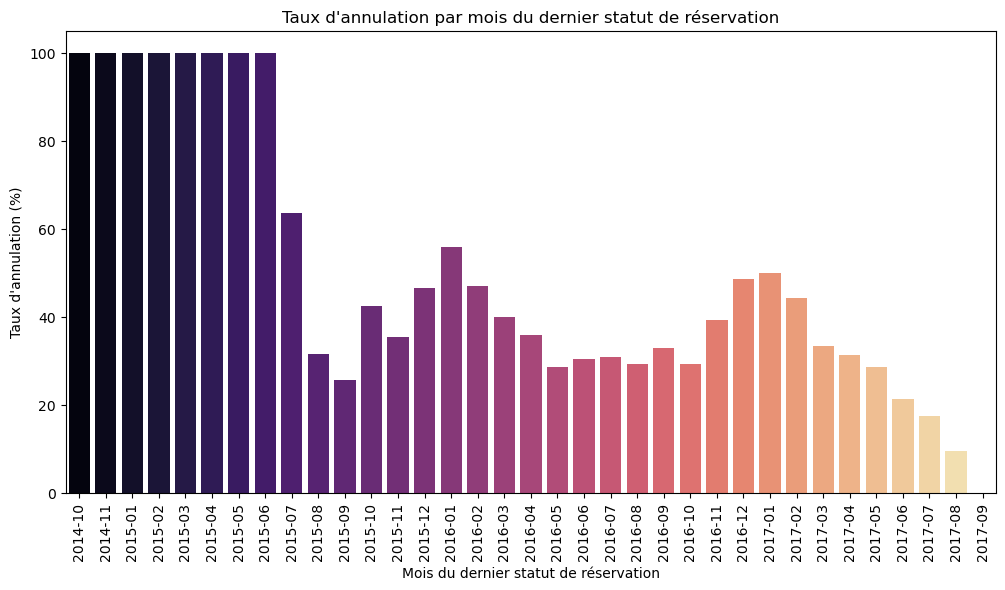

Corr√©lation `reservation_status_month` vs `is_canceled` : -0.1639


In [122]:
# Extraire l'ann√©e et le mois au format YYYY-MM
hotel_df['reservation_status_month'] = hotel_df['reservation_status_date'].dt.to_period('M').astype(str)

# Compter le nombre de r√©servations par mois
reservation_status_month_counts = hotel_df['reservation_status_month'].value_counts().sort_index()
print("Nombre de r√©servations par mois du dernier statut de r√©servation :\n", reservation_status_month_counts)

# Calcul du taux d‚Äôannulation par mois
reservation_status_month_analysis = pd.crosstab(hotel_df['reservation_status_month'], hotel_df['is_canceled'], normalize='index') * 100
reservation_status_month_analysis.columns = ['Confirm√©', 'Annul√©']
reservation_status_month_analysis = reservation_status_month_analysis.sort_index()

# Affichage du tableau des taux d'annulation
print("\nTaux d‚Äôannulation par mois du dernier statut de r√©servation :")
display(reservation_status_month_analysis)

# Barplot des taux d'annulation par mois
plt.figure(figsize=(12, 6))
sns.barplot(x=reservation_status_month_analysis.index, y=reservation_status_month_analysis['Annul√©'], 
            hue=reservation_status_month_analysis.index ,palette='magma', legend=False)
plt.title("Taux d'annulation par mois du dernier statut de r√©servation")
plt.xlabel("Mois du dernier statut de r√©servation")
plt.ylabel("Taux d'annulation (%)")
plt.xticks(rotation=90)
plt.show()

#Test de la corr√©lation reservation_status_month avec is_canceled
corr_reservation_status = hotel_df['reservation_status_month'].astype('category').cat.codes.corr(hotel_df['is_canceled'])
print(f"Corr√©lation `reservation_status_month` vs `is_canceled` : {corr_reservation_status:.4f}")

 <p style="background-color:DarkKhaki; color:black; font-weight:bold;text-align:center;">
Analyse du taux d‚Äôannulation par mois du dernier statut de r√©servation  

L‚Äôanalyse des annulations selon le mois du dernier statut de r√©servation montre **une tendance temporelle marqu√©e**.

**Observations principales :**  
- **Les taux d‚Äôannulation fluctuent consid√©rablement selon la p√©riode**, indiquant une **influence du facteur temps** sur les comportements d‚Äôannulation.  
- **Avant juillet 2015, le taux d‚Äôannulation est syst√©matiquement de 100‚Äâ%**, sugg√©rant des donn√©es incompl√®tes ou un biais dans la collecte pour ces p√©riodes.  
- **Entre juillet 2015 et ao√ªt 2017, les taux d‚Äôannulation diminuent progressivement**, atteignant **9.36‚Äâ% en ao√ªt 2017**.  
- **En septembre 2017, 100‚Äâ% des r√©servations ont √©t√© confirm√©es**, ce qui pourrait refl√©ter une p√©riode de faible activit√© ou un probl√®me dans les donn√©es.
- **La corr√©lation entre `reservation_status_month` et `is_canceled` est faible (-0.1639)**, indiquant que d‚Äôautres facteurs influencent aussi les annulations. 

**Interpr√©tation :**  
- **L‚Äôeffet temporel joue un r√¥le dans les annulations, mais il reste mod√©r√©.**
- **Les donn√©es avant juillet 2015 et apr√®s ao√ªt 2017 ne semblent pas repr√©sentatives** et pourraient introduire du bruit dans l‚Äôanalyse.  
- **L‚Äôanalyse de la distribution de `reservation_status_month` est n√©cessaire** afin de d√©tecter des anomalies √©ventuelles et d‚Äôaffiner les transformations √† appliquer.

**Conclusion :**  
<p style="background-color:lightgreen; color:black; font-weight:bold;"> reservation_status_month est une variable significative.  

- **L‚Äôeffet temporel influence les annulations**, mais la corr√©lation (-0.1639) montre que ce n‚Äôest pas le seul facteur cl√©.
- **Une analyse approfondie de sa distribution est n√©cessaire** avant d‚Äôappliquer toute transformation.
- **Les p√©riodes avant juillet 2015 et apr√®s ao√ªt 2017 devront √™tre examin√©es** pour confirmer leur exclusion.

.  
<p style="background-color:DarkGreen; color:white; font-weight:bold;text-align:center;">Analyse de l‚Äôimpact de arrival_datetime  sur is_canceled

Comme pour analyser reservation_status_date, le probl√®me pour arrival_datetime est qu'**il y a √©norm√©ment de cat√©gories (date)** ce qui rend l'analyse illisible si on affichait toutes les valeurs.  
Nous allons donc regrouper ces dates par mois et ann√©es *(au format YYYY-MM)* afin de faciliter la lecture.   
***Solution : Cr√©er arrival_month_year pour regrouper les dates par mois et ann√©e (YYYY-MM)***

Nombre de r√©servations par mois d'arriv√©e :
 arrival_month_year
2015-07    2776
2015-08    3889
2015-09    5114
2015-10    4957
2015-11    2340
2015-12    2920
2016-01    2248
2016-02    3891
2016-03    4824
2016-04    5428
2016-05    5478
2016-06    5292
2016-07    4572
2016-08    5063
2016-09    5394
2016-10    6203
2016-11    4454
2016-12    3860
2017-01    3681
2017-02    4177
2017-03    4970
2017-04    5661
2017-05    6313
2017-06    5647
2017-07    5313
2017-08    4925
Name: count, dtype: int64

Taux d‚Äôannulation par mois d'arriv√©e :


Confirm√©     Annul√©
arrival_month_year                      
2015-07             54.646974  45.353026
2015-08             58.909745  41.090255
2015-09             59.053578  40.946422
2015-10             65.059512  34.940488
2015-11             79.230769  20.769231
2015-12             66.678082  33.321918
2016-01             75.222420  24.777580
2016-02             65.638653  34.361347
2016-03             69.382255  30.617745
2016-04             62.030214  37.969786
2016-05             65.041986  34.958014
2016-06             60.393046  39.606954
2016-07             67.213473  32.786527
2016-08             63.954177  36.045823
2016-09             62.513904  37.486096
2016-10             59.471224  40.528776
2016-11             63.268972  36.731028
2016-12             63.782383  36.217617
2017-01             66.041836  33.958164
2017-02             67.464688  32.535312
2017-03             66.358149  33.641851
2017-04             56.491786  43.508214
2017-05             56.249010  43.750990
2017-06             56.808925  43.191075
2017-07             62.657632  37.342368
2017-08             63.126904  36.873096

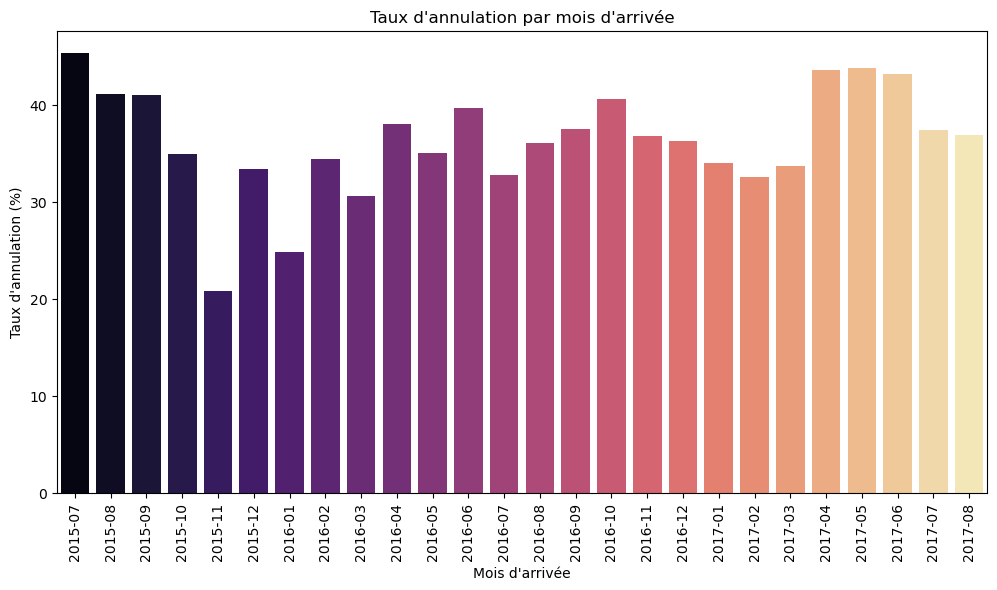

Corr√©lation `arrival_month_year` vs `is_canceled` : 0.0239


In [125]:
# Extraire l'ann√©e et le mois au format YYYY-MM
hotel_df['arrival_month_year'] = hotel_df['arrival_datetime'].dt.to_period('M').astype(str)

# Compter le nombre de r√©servations par mois d'arriv√©e
arrival_month_counts = hotel_df['arrival_month_year'].value_counts().sort_index()
print("Nombre de r√©servations par mois d'arriv√©e :\n", arrival_month_counts)

# Calcul du taux d‚Äôannulation par mois d'arriv√©e
arrival_month_analysis = pd.crosstab(hotel_df['arrival_month_year'], hotel_df['is_canceled'], normalize='index') * 100
arrival_month_analysis.columns = ['Confirm√©', 'Annul√©']
arrival_month_analysis = arrival_month_analysis.sort_index()

# Affichage du tableau des taux d'annulation
print("\nTaux d‚Äôannulation par mois d'arriv√©e :")
display(arrival_month_analysis)

plt.figure(figsize=(12, 6))
sns.barplot(x=arrival_month_analysis.index, y=arrival_month_analysis['Annul√©'], 
            hue=arrival_month_analysis.index, palette='magma', legend=False)
plt.title("Taux d'annulation par mois d'arriv√©e")
plt.xlabel("Mois d'arriv√©e")
plt.ylabel("Taux d'annulation (%)")
plt.xticks(rotation=90)
plt.show()

#Test de la corr√©lation arrival_month_year avec is_canceled
corr_arrival_month = hotel_df['arrival_month_year'].astype('category').cat.codes.corr(hotel_df['is_canceled'])
print(f"Corr√©lation `arrival_month_year` vs `is_canceled` : {corr_arrival_month:.4f}")

<p style="background-color:DarkKhaki; color:black; font-weight:bold;text-align:center;">
Analyse du taux d‚Äôannulation par mois d‚Äôarriv√©e  

L‚Äôanalyse des annulations selon le mois d‚Äôarriv√©e permet d‚Äôobserver **d‚Äô√©ventuelles variations temporelles sur les comportements d‚Äôannulation**.

**Observations principales :**  
- **Les taux d‚Äôannulation varient l√©g√®rement selon les mois**, mais sans tendance claire ni saisonnalit√© marqu√©e.  
**Aucune p√©riode ne se distingue par un taux d‚Äôannulation nettement plus √©lev√© ou plus bas que les autres.**
- **La corr√©lation entre `arrival_month_year` et `is_canceled` est extr√™mement faible (0.0239)**, ce qui indique une absence de lien significatif entre ces deux variables.  

**Interpr√©tation :**  
- **Contrairement √† `reservation_status_month`, `arrival_month_year` n‚Äôa pas d‚Äôimpact clair sur les annulations.**  
- **La tr√®s faible corr√©lation sugg√®re que les d√©cisions d‚Äôannulation ne d√©pendent pas du mois d‚Äôarriv√©e des clients.**  
- **L‚Äôeffet temporel observ√© sur les annulations est probablement mieux captur√© par d‚Äôautres variables, comme `reservation_status_month`.**
 
**Conclusion :**  
<p style="background-color:lightcoral; color:black; font-weight:bold;"> 
    arrival_month_year n‚Äôest pas une variable significative.  
    
- **L‚Äôabsence de corr√©lation et de tendance temporelle √©vidente justifie son exclusion de l‚Äôanalyse pr√©dictive.**  
- **Sa suppression sera envisag√©e lors du Data Preprocessing pour √©viter d‚Äôintroduire du bruit dans le mod√®le.**  


### **4.3.2 Distribution des variables Datetime significatives**

.  
<p style="background-color:DarkGreen; color:white; font-weight:bold;text-align:center;">Analyse de la distribution de reservation_status_month

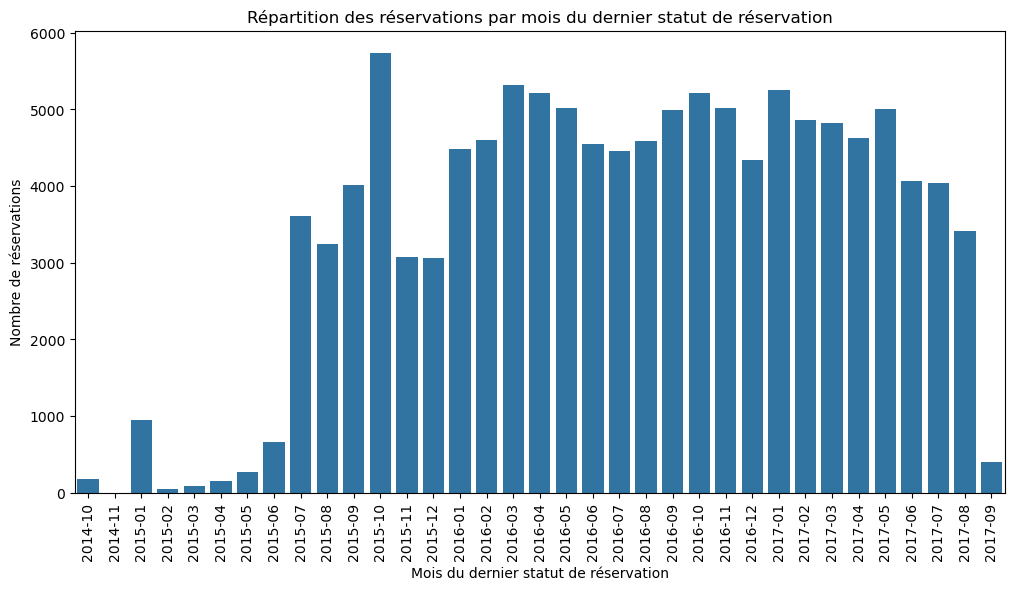

In [129]:
# V√©rifier la distribution de reservation_status_month avec tri chronologique
plt.figure(figsize=(12,6))
sns.countplot(x=hotel_df['reservation_status_month'], 
              order=sorted(hotel_df['reservation_status_month'].unique()))  # Trier par ordre chronologique
plt.title("R√©partition des r√©servations par mois du dernier statut de r√©servation")
plt.xlabel("Mois du dernier statut de r√©servation")
plt.ylabel("Nombre de r√©servations")
plt.xticks(rotation=90)
plt.show()


 <p style="background-color:DarkKhaki; color:black; font-weight:bold;text-align:center;">
Analyse de la distribution de reservation_status_month

Nous analysons la **distribution** de `reservation_status_month` afin de :  
- **D√©tecter d‚Äô√©ventuelles anomalies** (p√©riodes avec tr√®s peu ou beaucoup de r√©servations).  
- **Confirmer la saisonnalit√© observ√©e dans les annulations**.  
- **S‚Äôassurer que la plage temporelle retenue est coh√©rente** pour l‚Äôanalyse des annulations.  

**Observations principales :**  
- **La majorit√© des r√©servations est concentr√©e entre juillet 2015 et ao√ªt 2017**, avec un pic maximal en **octobre 2015**.  
- **Les p√©riodes de d√©but (octobre 2014 - juin 2015) et de fin (septembre 2017) montrent un volume extr√™mement faible**.  
  - Cela sugg√®re **une mont√©e en charge progressive** de la collecte des donn√©es et une **baisse brutale apr√®s ao√ªt 2017**.
  -   - **Ces p√©riodes sont potentiellement biais√©es et non repr√©sentatives.**  
- **L‚Äôanalyse confirme que les r√©servations entre juillet 2015 et ao√ªt 2017 sont les plus fiables** pour une √©tude robuste des annulations.  

**Interpr√©tation :**  
- **La r√©partition des donn√©es dans le temps est in√©gale**, ce qui pourrait introduire du bruit si toutes les p√©riodes sont conserv√©es sans ajustement.  
- **Les donn√©es avant mi-2015 et apr√®s ao√ªt 2017 ne sont pas repr√©sentatives et doivent √™tre exclues.**
- **Le format actuel de `reservation_status_month` (YYYY-MM) est pertinent** et permet de capturer correctement les tendances temporelles sans n√©cessiter d‚Äôautres transformations. 

**Conclusion finale :**  
<p style="background-color:lightgreen; color:black; font-weight:bold;">Conserver reservation_status_month  et exclure certaines p√©riodes.  

- **Exclusions √† effectuer :**
    - **Supprimer les observations avant juillet 2015 et apr√®s ao√ªt 2017**

- **Le format `YYYY-MM` sera conserv√© tel quel.**
- Cette d√©cision sera appliqu√©e lors du **Data Preprocessing**. 

### **4.3.3 R√©capitulatif des d√©cisions sur les transformations √† appliquer (variables Datetime)**

<p style="background-color:DarkKhaki;color:black; font-weight:bold; font-size:18px;text-align:center;">    
    R√©capitulatif des variables datetime significatives et transformations √† appliquer</p>

**Variables datetime significatives identifi√©es**  
Nous avons analys√© l‚Äôimpact de `reservation_status_date` et `arrival_datetime` sur `is_canceled` afin de d√©terminer leur importance dans la mod√©lisation.  
L‚Äôanalyse de leur **distribution**, des **fluctuations des taux d‚Äôannulation dans le temps**, ainsi que des **anomalies de collecte de donn√©es** nous a permis de d√©finir les transformations n√©cessaires.  

**Liste des variables datetime significatives :**  

| **Variable** | **Observations** | **Probl√®mes identifi√©s** |
|-------------|-----------------|---------------------------|
| `reservation_status_month` | Fort lien temporel avec `is_canceled` et Version agr√©g√©e de `reservation_status_date` (format YYYY-MM) | P√©riodes sous-repr√©sent√©es en d√©but et fin de dataset, n√©cessitant une prise de d√©cision |

**Transformations pr√©vues pour la mod√©lisation**  
Les d√©cisions ont √©t√© prises en fonction des **fluctuations temporelles des taux d‚Äôannulation**, des **probl√®mes de granularit√© excessive**, et de la n√©cessit√© d‚Äôoptimiser les variables temporelles.

| **Variable** | **Transformation √† appliquer** | **Justification** |
|-------------|------------------------------|-------------------|
| `reservation_status_month` | **Exclure les p√©riodes biais√©es (avant 2015-07 et apr√®s 2017-08)** | Repr√©sente bien l‚Äô√©volution temporelle des annulations |


**Transition vers le Data Preprocessing**  
Afin de conserver une **s√©paration stricte entre l‚ÄôEDA et le Data Preprocessing**, **aucune transformation n‚Äôest appliqu√©e ici**.  
Les transformations d√©finies ci-dessus seront mises en ≈ìuvre **dans la partie Data Preprocessing**, o√π leur impact sur l‚Äôanalyse et la performance du mod√®le sera valid√©.


## **4.4 R√©capitulatif des d√©cisions des transformations √† appliquer dans le Data Preprocessing**

<p style="background-color:LightSeaGreen;color:white; font-weight:bold; font-size:20px;text-align:center;">    
Synth√®se des d√©cisions sur les transformations √† appliquer dans le Data Preprocessing  

**Variables significatives identifi√©es**  
Nous avons s√©lectionn√© les **variables num√©riques, cat√©gorielles et datetime les plus pertinentes** pour expliquer `is_canceled`.  
L‚Äôanalyse des **corr√©lations (Pearson)**, des **tests de d√©pendance (Khi¬≤)** et des **distributions** a permis d‚Äôidentifier ces variables et de d√©finir les transformations n√©cessaires avant leur int√©gration dans un mod√®le pr√©dictif.  

.    
**Transformations pr√©vues pour la mod√©lisation**  
| **Type de Variable** | **Variable** | **Transformation √† appliquer** | **Justification** |
|-------------|-------------|------------------------------|-------------------|
| Num√©rique | `lead_time` | **Transformation logarithmique** | R√©duire l‚Äôimpact des valeurs extr√™mes |
| Num√©rique | `previous_cancellations` | **Binarisation (`0 = jamais annul√©`, `1 = au moins une annulation`)** | La plupart des valeurs sont 0, peu de variance au-del√† de 1 |
| Num√©rique | `booking_changes` | **Capping √† 3** | √âviter l‚Äôimpact des valeurs tr√®s rares sup√©rieures √† 3 |
| Num√©rique | `required_car_parking_spaces` | **Binarisation (`0 = aucune place`, `1+ = au moins une place demand√©e`)** | La quasi-totalit√© des valeurs >1 sont rares et peu significatives |
| Num√©rique | `total_of_special_requests` | **Conserver tel quel, mais tester un capping √† 3 apr√®s analyse de l‚Äôimpact sur la distribution** | V√©rifier si les valeurs √©lev√©es influencent `is_canceled` |
| Cat√©gorielle | `hotel` | **Label Encoding** | Variable binaire directement exploitable |
| Cat√©gorielle | `meal` | **Label Encoding** | Les taux d‚Äôannulation ne suivent pas la distribution des cat√©gories, chaque modalit√© semble apporter une information pertinente |
| Cat√©gorielle | `country_grouped` | **Conserver le regroupement  / One-Hot Encoding** | Le regroupement bas√© sur la fr√©quence des pays est pertinent et a √©t√© valid√© |
| Cat√©gorielle | `market_segment` | **Suppression** | Fortement redondant avec `deposit_type` et `customer_type` (confirm√© par Khi¬≤) |
| Cat√©gorielle | `distribution_channel` | **Suppression** | Redondance avec `market_segment`, confirm√© par Khi¬≤ |
| Cat√©gorielle | `deposit_type` | **Label Encoding** | Forte corr√©lation avec `is_canceled`, apporte une information cl√© |
| Cat√©gorielle | `customer_type` | **Label Encoding** | Malgr√© sa d√©pendance avec `deposit_type`, il apporte une information compl√©mentaire |
| Datetime | `reservation_status_date` | **Suppression** | Trop de valeurs uniques, peu exploitable en l‚Äô√©tat |
| Datetime | `reservation_status_month` | **Conserver avec exclusion des p√©riodes biais√©es (avant 2015-07 et apr√®s 2017-08)** | Repr√©sente bien l‚Äô√©volution temporelle des annulations |
| Datetime | `arrival_datetime` | **Suppression** | Redondance avec d‚Äôautres variables et trop granulaire |
| Datetime | `arrival_month_year` | **Suppression** | Faible corr√©lation avec is_canceled et aucune am√©lioration du mod√®le observ√©e dans les tests |

>Note : *L‚Äôencodage est n√©cessaire car **les mod√®les de Machine Learning ne traitent que des valeurs num√©riques.***  
> Deux m√©thodes sont utilis√©es :  
***One-Hot Encoding (OHE)** ‚Üí cr√©e une colonne binaire par cat√©gorie, adapt√© aux variables sans hi√©rarchie (hotel, meal, country_grouped).*  
***Label Encoding** ‚Üí attribue un num√©ro unique √† chaque cat√©gorie, adapt√© aux variables avec peu de modalit√©s (deposit_type, customer_type).*

.  
**Transition vers le Data Preprocessing**  
Afin de conserver une **s√©paration stricte entre l‚ÄôEDA et le Data Preprocessing**, **aucune transformation n‚Äôest appliqu√©e ici**.  
Toutes les modifications mentionn√©es ci-dessus seront mises en ≈ìuvre **dans la partie Data Preprocessing**, o√π leur impact sur la distribution des variables et la performance du mod√®le sera valid√©.  
.  
  
**Prochaine √©tape :** Appliquer ces transformations dans la section **5 Data Preprocessing**.


# **5- Data Preprocessing**

## **5.1 Pr√©paration des Variables Num√©riques**

### **5.1.1 Application des transformations des variables num√©riques**


.  

 <p style="background-color:Gold; color:black; font-weight:bold;text-align:center;">Application la transformation logarithmique √† lead_time


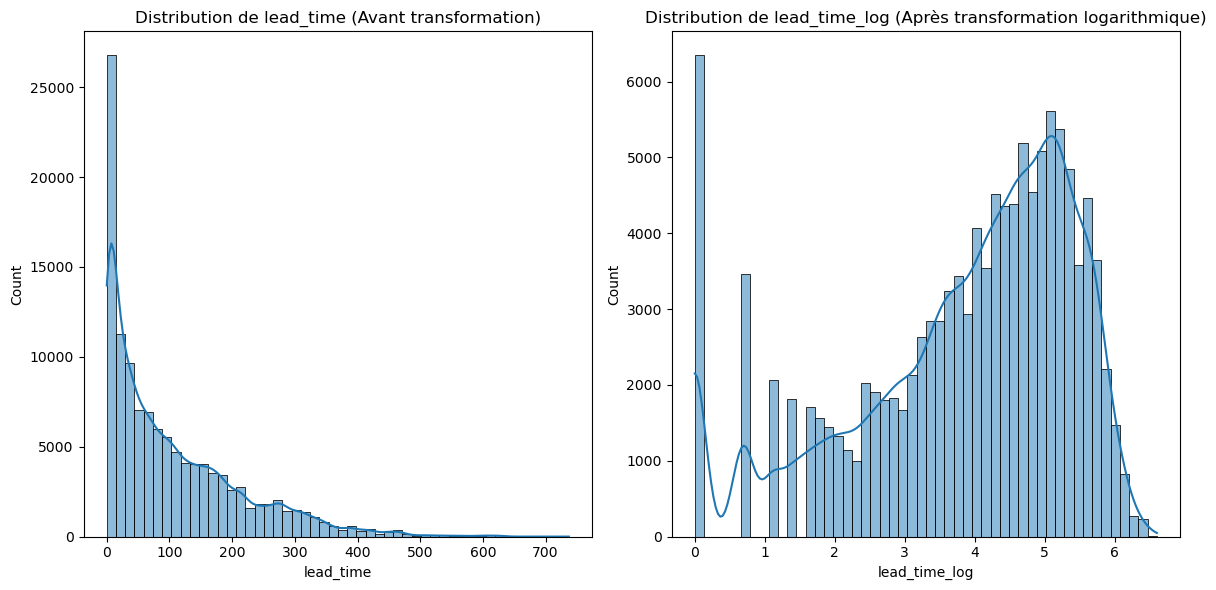


Corr√©lation lead_time vs is_canceled : 0.2931
Corr√©lation lead_time_log vs is_canceled : 0.3201


In [139]:
# Cr√©ation d'une nouvelle colonne transform√©e
hotel_df["lead_time_log"] = np.log1p(hotel_df["lead_time"])

# V√©rification de la transformation
hotel_df[["lead_time", "lead_time_log"]].describe()

plt.figure(figsize=(12, 6))
# Histogramme de lead_time AVANT transformation
plt.subplot(1, 2, 1)
sns.histplot(hotel_df["lead_time"], bins=50, kde=True)
plt.title("Distribution de lead_time (Avant transformation)")

# Histogramme de lead_time APR√àS transformation logarithmique
plt.subplot(1, 2, 2)
sns.histplot(hotel_df["lead_time_log"], bins=50, kde=True)
plt.title("Distribution de lead_time_log (Apr√®s transformation logarithmique)")

plt.tight_layout()
plt.show()


# Comparaison des corr√©lations avec is_canceled
corr_original = hotel_df["lead_time"].corr(hotel_df["is_canceled"])
corr_transformed = hotel_df["lead_time_log"].corr(hotel_df["is_canceled"])

print(f"\nCorr√©lation lead_time vs is_canceled : {corr_original:.4f}")
print(f"Corr√©lation lead_time_log vs is_canceled : {corr_transformed:.4f}")


<p style="background-color:LightGoldenRodYellow; color:black; font-weight:bold;text-align:center;"> Transformation logarithmique de lead_time

**Pourquoi cette transformation ?**  
La distribution initiale de `lead_time` est fortement asym√©trique, avec une concentration √©lev√©e sur les faibles valeurs et une longue tra√Æne vers les valeurs √©lev√©es. Cette asym√©trie peut impacter la performance des mod√®les et rendre difficile l‚Äôinterpr√©tation des relations entre `lead_time` et `is_canceled`.

**Application de la transformation**  
Nous avons appliqu√© une transformation logarithmique avec `log1p` (`log(lead_time + 1)`) afin de :
- R√©duire l'effet des valeurs extr√™mes.
- Rendre la distribution plus proche d‚Äôune distribution normale.
- Am√©liorer la stabilit√© des mod√®les pr√©dictifs.

**R√©sultats**  
- La distribution transform√©e est mieux √©quilibr√©e, bien qu'encore asym√©trique.
- La corr√©lation avec `is_canceled` est pass√©e de **0.2931** √† **0.3201**, indiquant une meilleure relation entre les deux variables.

**Conclusion**  
**La variable `lead_time_log` sera utilis√©e dans le mod√®le √† la place de `lead_time`.**


.  

 <p style="background-color:Gold; color:black; font-weight:bold;text-align:center;">Application de la binarisation de previous_cancellations


In [142]:
# Appliquer la binarisation : 0 = jamais annul√©, 1 = au moins une annulation
hotel_df["previous_cancellations_bin"] = (hotel_df["previous_cancellations"] > 0).astype(int)
hotel_df["previous_cancellations_bin"] = hotel_df["previous_cancellations_bin"].astype("int64")

# V√©rification des valeurs apr√®s transformation
print(hotel_df["previous_cancellations_bin"].value_counts())


previous_cancellations_bin
0    112906
1      6484
Name: count, dtype: int64


<p style="background-color:LightGoldenRodYellow; color:black; font-weight:bold;text-align:center;">Analyse de la binarisation de previous_cancellations

Nous avons transform√© `previous_cancellations` en variable binaire :  
- `0` : Jamais annul√©  
- `1` : Au moins une annulation  

**R√©partition apr√®s transformation**  
`0` : 112 906 observations  
`1` : 6 484 observations  

**Pourquoi ne pas tester la corr√©lation ?**  
Cette transformation simplifie l‚Äôinterpr√©tation sans chercher √† optimiser la corr√©lation.  
Les valeurs sup√©rieures √† `1` √©taient rares (<1‚Äâ%), leur impact sur `is_canceled` √©tait d√©j√† faible.  
L‚Äôobjectif est de rendre la variable plus robuste et exploitable, en √©vitant le bruit des valeurs extr√™mes.  

**Conclusion**  
**La variable `previous_cancellations_bin` sera utilis√©e dans le mod√®le √† la place de `previous_cancellations`.**


.  

 <p style="background-color:Gold; color:black; font-weight:bold;text-align:center;">Application du capping de booking_changes √† 3


In [145]:
# Appliquer un capping √† 3
hotel_df["booking_changes_capped"] = hotel_df["booking_changes"].clip(upper=3)
hotel_df["booking_changes_capped"] = hotel_df["booking_changes_capped"].astype("int64")

# V√©rification des valeurs apr√®s transformation
print(hotel_df["booking_changes_capped"].value_counts())

booking_changes_capped
0    101314
1     12701
2      3805
3      1570
Name: count, dtype: int64


<p style="background-color:LightGoldenRodYellow; color:black; font-weight:bold;text-align:center;">Analyse du capping de booking_changes √† 3

Nous avons appliqu√© un capping √† `booking_changes` :  
- Les valeurs `> 3` sont transform√©es en `3`  
- Conserve l‚Äôinformation sur les modifications sans donner trop d‚Äôimportance aux valeurs rares  

**R√©partition apr√®s transformation**  
`0` : 101 314 observations  
`1` : 12 701 observations  
`2` : 3 805 observations  
`3` : 1 570 observations  

**Pourquoi ne pas tester la corr√©lation ?**  
Contrairement √† une transformation continue, le capping r√©duit simplement l‚Äôinfluence des valeurs extr√™mes sans modifier significativement la structure de la variable.  
L‚Äôobjectif est d‚Äôatt√©nuer l‚Äôimpact des valeurs rares sans chercher √† optimiser directement la relation avec `is_canceled`.  

**Conclusion**  
**La variable `booking_changes_capped` sera utilis√©e dans le mod√®le √† la place de `booking_changes`.**


.  

 <p style="background-color:Gold; color:black; font-weight:bold;text-align:center;">Application de la binarisation de required_car_parking_spaces

In [148]:
# Appliquer la binarisation (0 = aucune place, 1 = au moins une place demand√©e)
hotel_df["required_car_parking_spaces_bin"] = (hotel_df["required_car_parking_spaces"] > 0).astype(int)
hotel_df["required_car_parking_spaces_bin"] = hotel_df["required_car_parking_spaces_bin"].astype("int64")

# V√©rifier la r√©partition apr√®s transformation
print(hotel_df["required_car_parking_spaces_bin"].value_counts())

required_car_parking_spaces_bin
0    111974
1      7416
Name: count, dtype: int64


<p style="background-color:LightGoldenRodYellow; color:black; font-weight:bold;text-align:center;">
Analyse de la binarisation de required_car_parking_spaces

Nous avons appliqu√© une binarisation √† `required_car_parking_spaces` :  
- `0` : Aucune place demand√©e  
- `1` : Au moins une place demand√©e  

**R√©partition apr√®s transformation**  
`0` : 111 974 observations  
`1` : 7 416 observations  

**Pourquoi ne pas tester la corr√©lation ?**  
La variable initiale contenait tr√®s peu de valeurs sup√©rieures √† `1`, leur impact sur `is_canceled` aurait √©t√© marginal.  
La binarisation simplifie l‚Äôinterpr√©tation et rend la variable plus exploitable sans perte significative d‚Äôinformation.  

**Conclusion**  
**La variable `required_car_parking_spaces_bin` sera utilis√©e dans le mod√®le √† la place de `required_car_parking_spaces`.**


.  

 <p style="background-color:Gold; color:black; font-weight:bold;text-align:center;">Comparaison des taux d'annulation par nombre de total_of_special_requests et application du capping si besoin

Nombre de personne par total_of_special_requests
 total_of_special_requests
0    70318
1    33226
2    12969
3     2497
4      340
5       40
Name: count, dtype: int64

Cancelation rate / total_of_special_requests
 total_of_special_requests
0    47.720356
1    22.024920
2    22.098851
3    17.861434
4    10.588235
5     5.000000
Name: is_canceled, dtype: float64


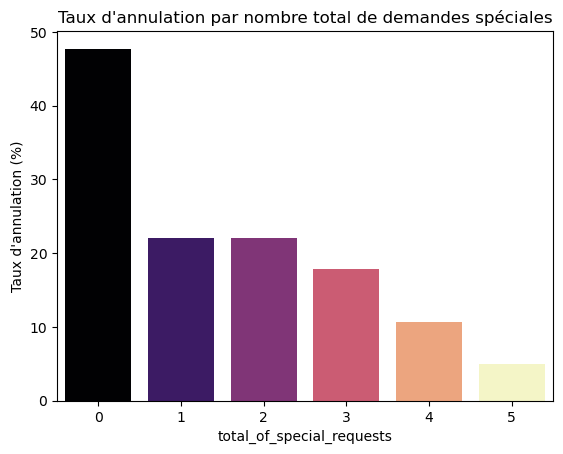

In [151]:
# Compter le nombre d'annulation par total_of_special_requests
total_of_special_requests_counts = hotel_df['total_of_special_requests'].value_counts().sort_index()
print("Nombre de personne par total_of_special_requests\n",total_of_special_requests_counts)
# Calcul du taux d'annulation par total_of_special_requests
cancelation_rate_total_of_special_requests = hotel_df.groupby('total_of_special_requests')['is_canceled'].mean() * 100
print("\nCancelation rate / total_of_special_requests\n",cancelation_rate_total_of_special_requests)

# Barplot des taux d'annulation par total_of_special_requests
sns.barplot(x=cancelation_rate_total_of_special_requests.index, y=cancelation_rate_total_of_special_requests.values, 
            hue=cancelation_rate_total_of_special_requests.index, palette='magma', legend=False)
plt.title("Taux d'annulation par nombre total de demandes sp√©ciales")
plt.xlabel("total_of_special_requests")
plt.ylabel("Taux d'annulation (%)")

plt.show()

<p style="background-color:LightGoldenRodYellow; color:black; font-weight:bold;text-align:center;">Analyse des taux d'annulation par nombre de total_of_special_requests
    
Nous avons √©tudi√© l‚Äôimpact du nombre total de demandes sp√©ciales sur l‚Äôannulation des r√©servations.

**R√©partition des r√©servations :**  
- `0` : 70 318 r√©servations  
- `1` : 33 226 r√©servations  
- `2` : 12 969 r√©servations  
- `3` : 2 497 r√©servations  
- `4` : 340 r√©servations  
- `5` : 40 r√©servations  

**Taux d‚Äôannulation selon le nombre de demandes sp√©ciales :**  
- `0` : **47.72‚Äâ%**  
- `1` : **22.02‚Äâ%**  
- `2` : **22.09‚Äâ%**  
- `3` : **17.86‚Äâ%**  
- `4` : **10.58‚Äâ%**  
- `5` : **5.00‚Äâ%**  

**Interpr√©tation :**  
- Il existe une **corr√©lation inverse forte** entre `total_of_special_requests` et `is_canceled` :  
  - **Plus le nombre de demandes sp√©ciales est √©lev√©, plus le taux d‚Äôannulation est faible.**  
  - Les clients avec `0` demandes sp√©ciales ont un taux d‚Äôannulation **extr√™mement √©lev√©** (47.72‚Äâ%).  
  - D√®s `1 ou 2 demandes`, le taux d‚Äôannulation diminue significativement (~22‚Äâ%).  
  - Pour `4 et 5 demandes`, le taux d‚Äôannulation est tr√®s bas, mais ces cat√©gories contiennent tr√®s peu d‚Äôobservations.  

**Prochaines √©tapes :**  
- V√©rifier si **regrouper les cat√©gories 4 et 5 en une seule (4+)** am√©liore la robustesse du mod√®le.  
- Tester l'impact de `total_of_special_requests` sur la performance des mod√®les avant toute transformation.  


.  

 <p style="background-color:Gold; color:black; font-weight:bold;text-align:center;">Groupement des cat√©gories 4 et 5 (4+) de total_of_special_requests


 total_of_special_requests_grouped
0    70318
1    33226
2    12969
3     2497
4      380
Name: count, dtype: int64 



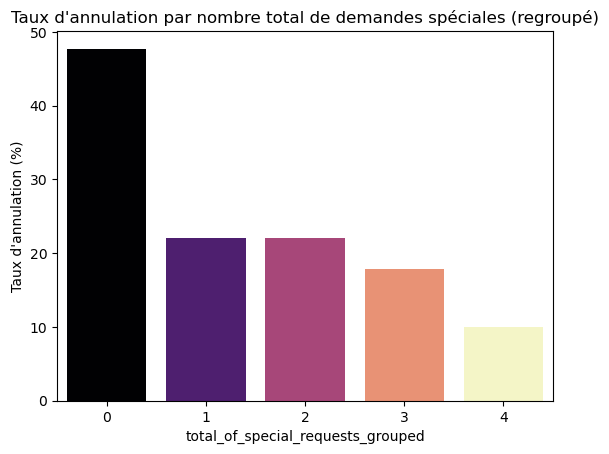


Corr√©lation total_of_special_requests vs is_canceled : -0.2347
Corr√©lation total_of_special_requests_grouped vs is_canceled : -0.2349



In [154]:
# Cr√©ation d'une nouvelle variable avec regroupement des valeurs 4 et 5 en 4+
hotel_df["total_of_special_requests_grouped"] = hotel_df["total_of_special_requests"].apply(lambda x: x if x <= 3 else 4)
hotel_df["total_of_special_requests_grouped"] = hotel_df["total_of_special_requests_grouped"].astype("int64")

# V√©rification de la r√©partition apr√®s transformation
print("\n",hotel_df["total_of_special_requests_grouped"].value_counts().sort_index(),"\n")


# Calcul du taux d'annulation apr√®s regroupement
cancelation_rate_grouped = hotel_df.groupby("total_of_special_requests_grouped")["is_canceled"].mean() * 100

# Barplot des taux d'annulation
sns.barplot(x=cancelation_rate_grouped.index, y=cancelation_rate_grouped.values, 
            hue=cancelation_rate_grouped.index, palette="magma", legend=False)
plt.title("Taux d'annulation par nombre total de demandes sp√©ciales (regroup√©)")
plt.xlabel("total_of_special_requests_grouped")
plt.ylabel("Taux d'annulation (%)")
plt.show()


# Calcul des corr√©lations
corr_original = hotel_df["total_of_special_requests"].corr(hotel_df["is_canceled"])
corr_grouped = hotel_df["total_of_special_requests_grouped"].corr(hotel_df["is_canceled"])

print(f"\nCorr√©lation total_of_special_requests vs is_canceled : {corr_original:.4f}")
print(f"Corr√©lation total_of_special_requests_grouped vs is_canceled : {corr_grouped:.4f}\n")

<p style="background-color:LightGoldenRodYellow; color:black; font-weight:bold;text-align:center;">Analyse du groupement des cat√©gories 4 et 5 (4+) de total_of_special_requests

**Pourquoi cette transformation ?**  
Les cat√©gories `4` et `5` √©taient tr√®s rares, ce qui pouvait introduire du bruit sans apporter d‚Äôinformation significative. Nous avons test√© la fusion de ces cat√©gories en une seule (`4+`) afin de simplifier la variable sans perte notable d'information.

**R√©partition apr√®s transformation**  
`0` : 70 318 observations  
`1` : 33 226 observations  
`2` : 12 969 observations  
`3` : 2 497 observations  
`4+` : 380 observations  

**Comparaison des corr√©lations avec `is_canceled`**  
Avant transformation : `-0.2347`  
Apr√®s transformation : `-0.2349`  

**Interpr√©tation**  
La corr√©lation reste pratiquement inchang√©e apr√®s la fusion des cat√©gories `4` et `5`.  
Cela confirme que cette transformation ne fait pas perdre d‚Äôinformation significative.  
Les cat√©gories `4` et `5` √©taient trop rares pour influencer fortement `is_canceled`.  

**Conclusion**  
**La variable `total_of_special_requests_grouped` sera utilis√©e dans le mod√®le √† la place de `total_of_special_requests`.**


### **5.1.2 V√©rification des transformations des variables num√©riques**

.  

 <p style="background-color:Gold; color:black; font-weight:bold;text-align:center;">Coefficient de corr√©lation de Pearson et Heatmap de corr√©lation des variables num√©riques significatives

üìä Corr√©lations de Pearson entre is_canceled et les variables num√©riques significatives transform√©es :



is_canceled
lead_time_log                         0.320063
previous_cancellations_bin            0.270943
booking_changes_capped               -0.160848
required_car_parking_spaces_bin      -0.197399
total_of_special_requests_grouped    -0.234870

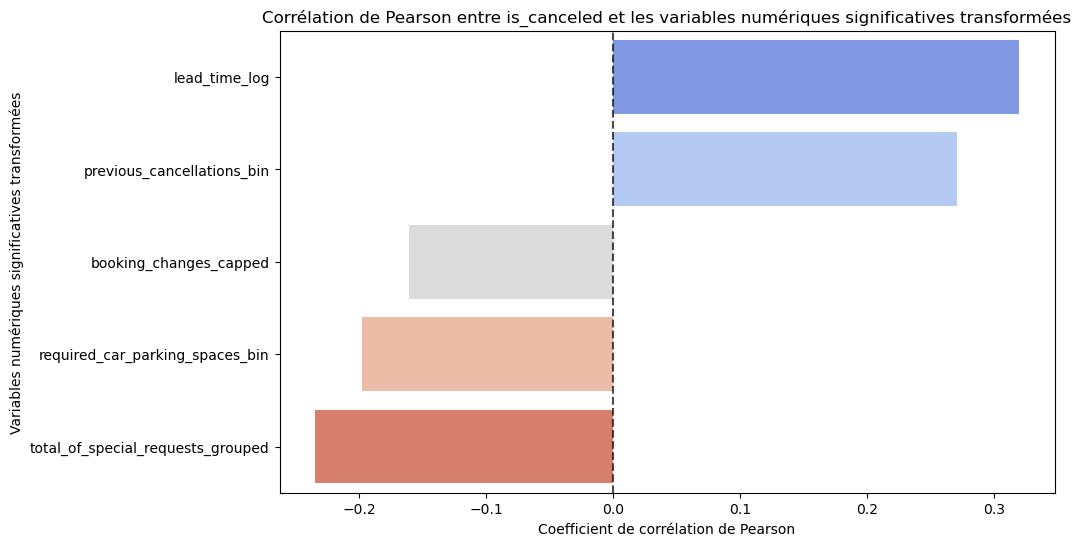

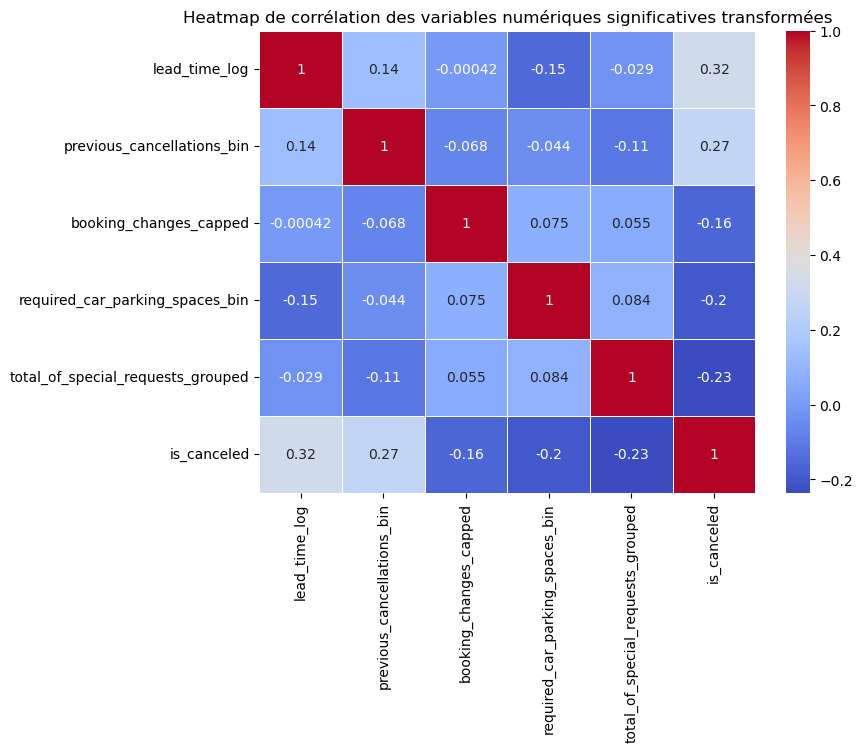

In [158]:
# Filtrer uniquement les variables num√©riques significatives transform√©es + is_canceled
modified_significativ_numeric_cols = hotel_df[['lead_time_log', 'previous_cancellations_bin', 'booking_changes_capped',
                                      'required_car_parking_spaces_bin','total_of_special_requests_grouped', 'is_canceled']]

# Calcul des corr√©lations de Pearson entre les vvariables num√©riques significatives transform√©es et is_canceled
correlation_matrix = modified_significativ_numeric_cols.corr()

# S√©lection des corr√©lations avec is_canceled uniquement
correlation_with_target = correlation_matrix["is_canceled"].drop("is_canceled").sort_values(ascending=False)

# Affichage des corr√©lations sous forme de tableau
print("üìä Corr√©lations de Pearson entre is_canceled et les variables num√©riques significatives transform√©es :\n")
display(correlation_with_target.to_frame())

# Visualisation sous forme de barplot
plt.figure(figsize=(10, 6))
sns.barplot(x=correlation_with_target.values, y=correlation_with_target.index, hue=correlation_with_target.index, palette="coolwarm")
plt.title("Corr√©lation de Pearson entre is_canceled et les variables num√©riques significatives transform√©es")
plt.xlabel("Coefficient de corr√©lation de Pearson")
plt.ylabel("Variables num√©riques significatives transform√©es")
plt.axvline(x=0, color='black', linestyle="--", alpha=0.7)  # Ligne verticale pour s√©parer valeurs positives et n√©gatives
plt.show()

print('\n'*3)
      

# Filtrer uniquement les variables num√©riques significatives transform√©es (sans is_canceled)
modif_significativ_numeric_cols = hotel_df[['lead_time_log', 'previous_cancellations_bin', 'booking_changes_capped',
                                      'required_car_parking_spaces_bin','total_of_special_requests_grouped']]

# Calcul de la matrice de corr√©lation
plt.figure(figsize=(8,6))
sns.heatmap(modified_significativ_numeric_cols.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Heatmap de corr√©lation des variables num√©riques significatives transform√©es")
plt.show()

  <p style="background-color:LightGoldenRodYellow; color:black; font-weight:bold;text-align:center;">Analyse des corr√©lations finales des variables num√©riques significatives transform√©es  

Nous avons recalcul√© les corr√©lations entre `is_canceled` et les variables num√©riques apr√®s transformation.  

**Interpr√©tation**  
- Les variables transform√©es conservent une bonne corr√©lation avec `is_canceled`, confirmant la pertinence des transformations.  
- `lead_time_log` reste la variable la plus corr√©l√©e avec les annulations (**0.32**), ce qui justifie pleinement son utilisation.  
- `previous_cancellations_bin` montre une relation forte avec `is_canceled`, validant la binarisation.  
- Les autres variables conservent une corr√©lation mod√©r√©e, mais restent significatives, sans valeur aberrante ou redondance excessive.  


### **5.1.3 Suppression des anciennes colonnes num√©riques qui ont √©t√© transform√©es**

In [161]:
# Supprimer les anciennes colonnes du dataset
columns_to_drop = ['lead_time', 'previous_cancellations', 'booking_changes', 
                   'required_car_parking_spaces', 'total_of_special_requests']

hotel_df.drop(columns=columns_to_drop, inplace=True)

# V√©rification : Afficher uniquement les colonnes num√©riques restantes
numeric_cols_remaining = hotel_df.select_dtypes(include=['int64', 'float64']).columns

print("Variables num√©riques restantes apr√®s suppression des anciennes colonnes :")
print(numeric_cols_remaining)


Variables num√©riques restantes apr√®s suppression des anciennes colonnes :
Index(['is_canceled', 'arrival_date_year', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies',
       'is_repeated_guest', 'previous_bookings_not_canceled', 'agent',
       'days_in_waiting_list', 'adr', 'lead_time_log',
       'previous_cancellations_bin', 'booking_changes_capped',
       'required_car_parking_spaces_bin', 'total_of_special_requests_grouped'],
      dtype='object')


## **5.2 Pr√©paration des Variables Cat√©gorielles**

### **5.2.1 Application des transformations des variables cat√©gorielles**

.  
 <p style="background-color:purple; color:white; font-weight:bold;text-align:center;">
     Suppression des variables cat√©gorielles redondantes et inutiles

In [165]:
# Suppression des variables cat√©gorielles redondantes et innutiles                                                    
columns_to_drop = ['market_segment', 'distribution_channel', 'country']                                    
hotel_df.drop(columns=columns_to_drop, inplace=True)
            
# V√©rification des variables cat√©gorielles restantes apr√®s transformation
categorical_cols_remaining = hotel_df.select_dtypes(include=['object']).columns
print("Variables cat√©gorielles restantes apr√®s suppression des redondantes :")
print(categorical_cols_remaining)                                          

Variables cat√©gorielles restantes apr√®s suppression des redondantes :
Index(['hotel', 'arrival_date_month', 'meal', 'reserved_room_type',
       'assigned_room_type', 'deposit_type', 'customer_type',
       'reservation_status', 'country_grouped', 'reservation_status_month',
       'arrival_month_year'],
      dtype='object')


.  
 <p style="background-color:purple; color:white; font-weight:bold;text-align:center;">
     Application des transformations One-Hot-Encoding (OHE) des variables cat√©gorielles

In [167]:
# V√©rifier si 'country_grouped' existe avant d'appliquer One-Hot Encoding
if 'country_grouped' in hotel_df.columns:
    hotel_df = pd.get_dummies(hotel_df, columns=['country_grouped'], drop_first=True)

.  
 <p style="background-color:purple; color:white; font-weight:bold;text-align:center;">
     Application des transformations Label Encoding des variables cat√©gorielles

In [169]:
# D√©finir les mappings pour Label Encoding
label_mappings = {
    "hotel": {"City Hotel": 0, "Resort Hotel": 1},
    "meal": {"Undefined": 0, "HB": 1, "SC": 2, "BB": 3, "FB": 4},
    "deposit_type": {"Refundable": 0, "No Deposit": 1, "Non Refund": 2},
    "customer_type": {"Group": 0, "Transient-Party": 1, "Contract": 2, "Transient": 3}
}

# Appliquer l'encodage Label Encoding uniquement si la colonne contient encore des cha√Ænes de caract√®res
for col, mapping in label_mappings.items():
    if col in hotel_df.columns:
        # V√©rifier si la colonne contient encore des strings avant d'encoder
        if hotel_df[col].dtype == "object":
            hotel_df[col] = hotel_df[col].map(mapping)

### **5.2.2 V√©rification des transformations des variables cat√©gorielles**

.  
 <p style="background-color:purple; color:white; font-weight:bold;text-align:center;">
V√©rification One-Hot Encoding

In [172]:
encoded_columns = [col for col in hotel_df.columns if "country_grouped" in col]
print("V√©rification apr√®s One-Hot Encoding :")
print(hotel_df[encoded_columns].head())        

V√©rification apr√®s One-Hot Encoding :
   country_grouped_BEL  country_grouped_BRA  country_grouped_CHE  \
0                False                False                False   
1                False                False                False   
2                False                False                False   
3                False                False                False   
4                False                False                False   

   country_grouped_CHN  country_grouped_CN  country_grouped_DEU  \
0                False               False                False   
1                False               False                False   
2                False               False                False   
3                False               False                False   
4                False               False                False   

   country_grouped_ESP  country_grouped_FRA  country_grouped_GBR  \
0                False                False                False   
1           

.  
 <p style="background-color:purple; color:white; font-weight:bold;text-align:center;">
V√©rifivation Label Encoding

In [174]:
print("V√©rification apr√®s Label Encoding :")
print(hotel_df[["hotel", "meal", "deposit_type", "customer_type"]].head(20))
print(hotel_df[["hotel", "meal", "deposit_type", "customer_type"]].nunique())

V√©rification apr√®s Label Encoding :
    hotel  meal  deposit_type  customer_type
0       1     3             1              3
1       1     3             1              3
2       1     3             1              3
3       1     3             1              3
4       1     3             1              3
5       1     3             1              3
6       1     3             1              3
7       1     4             1              3
8       1     3             1              3
9       1     1             1              3
10      1     3             1              3
11      1     1             1              3
12      1     3             1              3
13      1     1             1              3
14      1     3             1              3
15      1     3             1              3
16      1     3             1              2
17      1     3             1              3
18      1     3             1              3
19      1     3             1              3
hotel            

### **5.2.3 Suppression des anciennes colonnes cat√©gorielles transform√©es**

In [176]:
# Suppression de l'ancienne colonne country_grouped (remplac√©e par One-Hot Encoding)
if "country_grouped" in hotel_df.columns:
    hotel_df.drop(columns=["country_grouped"], inplace=True)

# V√©rification que la colonne a bien √©t√© supprim√©e
print("Colonnes restantes apr√®s suppression :")
print(hotel_df.columns)

Colonnes restantes apr√®s suppression :
Index(['hotel', 'is_canceled', 'arrival_date_year', 'arrival_date_month',
       'arrival_date_week_number', 'arrival_date_day_of_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'meal', 'is_repeated_guest', 'previous_bookings_not_canceled',
       'reserved_room_type', 'assigned_room_type', 'deposit_type', 'agent',
       'days_in_waiting_list', 'customer_type', 'adr', 'reservation_status',
       'reservation_status_date', 'arrival_datetime', 'room_change',
       'market_segment_encoded', 'distribution_channel_encoded',
       'reservation_status_month', 'arrival_month_year', 'lead_time_log',
       'previous_cancellations_bin', 'booking_changes_capped',
       'required_car_parking_spaces_bin', 'total_of_special_requests_grouped',
       'country_grouped_BEL', 'country_grouped_BRA', 'country_grouped_CHE',
       'country_grouped_CHN', 'country_grouped_CN', 'country_grouped_DEU',
       '

## **5.3 Pr√©paration des Variables Datetime**

### **5.3.1 Application des transformations des variables datetime**

.  
 <p style="background-color:purple; color:white; font-weight:bold;text-align:center;">
Filtrage des dates sur reservation_status_month

In [180]:
# Filtrer et modifier hotel_df en place
hotel_df = hotel_df.loc[(hotel_df['reservation_status_month'] >= '2015-07') & 
                        (hotel_df['reservation_status_month'] <= '2017-08')]

# Convertir reservation_status_month en entier (ex: '2016-09' ‚Üí 201609)
hotel_df["reservation_status_month"] = hotel_df["reservation_status_month"].str.replace("-", "").astype(int)

# V√©rification de la conversion
print("\nV√©rification apr√®s conversion de reservation_status_month :")
print(hotel_df["reservation_status_month"].head())
print("\nNouveau type de donn√©es :", hotel_df["reservation_status_month"].dtype)


V√©rification apr√®s conversion de reservation_status_month :
0    201507
1    201507
2    201507
3    201507
4    201507
Name: reservation_status_month, dtype: int32

Nouveau type de donn√©es : int32


.  
 <p style="background-color:purple; color:white; font-weight:bold;text-align:center;">
Suppression de la colonne arrival_month_year.

In [182]:
# Supprimer la colonne arrival_month_year
if 'arrival_month_year' in hotel_df.columns:
    hotel_df.drop(columns=['arrival_month_year'], inplace=True)

### **5.3.2 V√©rification des transformations des variables datetime**

.  
 <p style="background-color:purple; color:white; font-weight:bold;text-align:center;">
V√©rification du filtrage des dates sur reservation_status_month

In [185]:
# V√©rification des valeurs uniques restantes apr√®s filtrage
print("V√©rification des valeurs uniques de reservation_status_month apr√®s filtrage :")
print(hotel_df['reservation_status_month'].unique())

V√©rification des valeurs uniques de reservation_status_month apr√®s filtrage :
[201507 201508 201509 201510 201511 201512 201601 201602 201603 201604
 201605 201606 201607 201608 201609 201610 201611 201612 201701 201702
 201703 201704 201705 201706 201707 201708]


.  
 <p style="background-color:purple; color:white; font-weight:bold;text-align:center;">
V√©rification de la suppression de la colonne arrival_month_year.

In [187]:
# V√©rifier que la colonne arrival_month_year a bien √©t√© supprim√©e
if 'arrival_month_year' in hotel_df.columns:
    print("ERREUR : arrival_month_year est toujours dans le dataset !")
else:
    print("V√©rification OK : arrival_month_year a bien √©t√© supprim√©.")

V√©rification OK : arrival_month_year a bien √©t√© supprim√©.


### **5.3.3 Suppression des anciennes colonnes datetime transform√©es**

In [189]:
# Liste des colonnes datetime √† supprimer
cols_to_drop = ["reservation_status_date", "arrival_datetime"]

# V√©rifier si les colonnes existent avant de les supprimer
hotel_df.drop(columns=[col for col in cols_to_drop if col in hotel_df.columns], inplace=True)

# V√©rification apr√®s suppression
print("Colonnes restantes apr√®s suppression des anciennes variables datetime :")
print(hotel_df.columns)

Colonnes restantes apr√®s suppression des anciennes variables datetime :
Index(['hotel', 'is_canceled', 'arrival_date_year', 'arrival_date_month',
       'arrival_date_week_number', 'arrival_date_day_of_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'meal', 'is_repeated_guest', 'previous_bookings_not_canceled',
       'reserved_room_type', 'assigned_room_type', 'deposit_type', 'agent',
       'days_in_waiting_list', 'customer_type', 'adr', 'reservation_status',
       'room_change', 'market_segment_encoded', 'distribution_channel_encoded',
       'reservation_status_month', 'lead_time_log',
       'previous_cancellations_bin', 'booking_changes_capped',
       'required_car_parking_spaces_bin', 'total_of_special_requests_grouped',
       'country_grouped_BEL', 'country_grouped_BRA', 'country_grouped_CHE',
       'country_grouped_CHN', 'country_grouped_CN', 'country_grouped_DEU',
       'country_grouped_ESP', 'country_grouped_FRA'

## **5.4 Suppression des autres colonnes non significatives**

In [191]:
print(hotel_df.columns)

Index(['hotel', 'is_canceled', 'arrival_date_year', 'arrival_date_month',
       'arrival_date_week_number', 'arrival_date_day_of_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'meal', 'is_repeated_guest', 'previous_bookings_not_canceled',
       'reserved_room_type', 'assigned_room_type', 'deposit_type', 'agent',
       'days_in_waiting_list', 'customer_type', 'adr', 'reservation_status',
       'room_change', 'market_segment_encoded', 'distribution_channel_encoded',
       'reservation_status_month', 'lead_time_log',
       'previous_cancellations_bin', 'booking_changes_capped',
       'required_car_parking_spaces_bin', 'total_of_special_requests_grouped',
       'country_grouped_BEL', 'country_grouped_BRA', 'country_grouped_CHE',
       'country_grouped_CHN', 'country_grouped_CN', 'country_grouped_DEU',
       'country_grouped_ESP', 'country_grouped_FRA', 'country_grouped_GBR',
       'country_grouped_IRL', 'country_grouped_I

In [192]:
# D√©finir les variables √† conserver
variables_a_garder = ["is_canceled", "reservation_status_month",
    "lead_time_log", "previous_cancellations_bin", "booking_changes_capped",
    "required_car_parking_spaces_bin", "total_of_special_requests_grouped",
    "hotel", "meal", "deposit_type", "customer_type",'country_grouped_BEL', 
    'country_grouped_BRA', 'country_grouped_CHE', 'country_grouped_CHN', 
    'country_grouped_CN', 'country_grouped_DEU', 'country_grouped_ESP', 
    'country_grouped_FRA', 'country_grouped_GBR', 'country_grouped_IRL',
    'country_grouped_ISR', 'country_grouped_ITA', 'country_grouped_NLD', 
    'country_grouped_NOR', 'country_grouped_Others', 'country_grouped_POL', 
    'country_grouped_PRT', 'country_grouped_RUS','country_grouped_SWE', 
    'country_grouped_USA']

# Filtrer le DataFrame pour ne garder que ces variables
hotel_df = hotel_df[variables_a_garder]

# V√©rification des colonnes restantes
print("Colonnes finales apr√®s suppression des variables non significatives :")
print(hotel_df.columns)


Colonnes finales apr√®s suppression des variables non significatives :
Index(['is_canceled', 'reservation_status_month', 'lead_time_log',
       'previous_cancellations_bin', 'booking_changes_capped',
       'required_car_parking_spaces_bin', 'total_of_special_requests_grouped',
       'hotel', 'meal', 'deposit_type', 'customer_type', 'country_grouped_BEL',
       'country_grouped_BRA', 'country_grouped_CHE', 'country_grouped_CHN',
       'country_grouped_CN', 'country_grouped_DEU', 'country_grouped_ESP',
       'country_grouped_FRA', 'country_grouped_GBR', 'country_grouped_IRL',
       'country_grouped_ISR', 'country_grouped_ITA', 'country_grouped_NLD',
       'country_grouped_NOR', 'country_grouped_Others', 'country_grouped_POL',
       'country_grouped_PRT', 'country_grouped_RUS', 'country_grouped_SWE',
       'country_grouped_USA'],
      dtype='object')


## **5.5 V√©rification finale et r√©capitulatif des variables cl√©s**

In [194]:
# V√©rification des colonnes finales
print("\nListe finale des colonnes dans le dataset :")
print(hotel_df.columns)

# Classification des variables restantes
variables_numeriques = ["lead_time_log", "previous_cancellations_bin", "booking_changes_capped",
                        "required_car_parking_spaces_bin", "total_of_special_requests_grouped"]

variables_categorielles = ["hotel", "meal", "deposit_type", "customer_type"] + [col for col in hotel_df.columns if "country_grouped_" in col]  

variables_datetime = ["reservation_status_month"] 

# Affichage des cat√©gories de variables
print("\n\nVariables num√©riques :", variables_numeriques)
print("\n\n\nVariables cat√©gorielles (encod√©es) :", variables_categorielles)
print("\n\n\nVariables datetime :", variables_datetime)

# Aper√ßu final du dataset apr√®s preprocessing
print("\n\n\nAper√ßu des informations du dataset :")
hotel_df.info()


Liste finale des colonnes dans le dataset :
Index(['is_canceled', 'reservation_status_month', 'lead_time_log',
       'previous_cancellations_bin', 'booking_changes_capped',
       'required_car_parking_spaces_bin', 'total_of_special_requests_grouped',
       'hotel', 'meal', 'deposit_type', 'customer_type', 'country_grouped_BEL',
       'country_grouped_BRA', 'country_grouped_CHE', 'country_grouped_CHN',
       'country_grouped_CN', 'country_grouped_DEU', 'country_grouped_ESP',
       'country_grouped_FRA', 'country_grouped_GBR', 'country_grouped_IRL',
       'country_grouped_ISR', 'country_grouped_ITA', 'country_grouped_NLD',
       'country_grouped_NOR', 'country_grouped_Others', 'country_grouped_POL',
       'country_grouped_PRT', 'country_grouped_RUS', 'country_grouped_SWE',
       'country_grouped_USA'],
      dtype='object')


Variables num√©riques : ['lead_time_log', 'previous_cancellations_bin', 'booking_changes_capped', 'required_car_parking_spaces_bin', 'total_of_special_re

# **6- Mod√©lisation**

## **6.1  S√©paration des donn√©es (train/test split)**

In [197]:
# D√©finition des features (X) et de la target (y)
X = hotel_df.drop(columns=['is_canceled'])  # On enl√®ve la variable cible
y = hotel_df['is_canceled']  # Variable cible

# D√©couper en 80% train / 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# V√©rification des dimensions
print("Taille du dataset d'entra√Ænement :", X_train.shape)
print("Taille du dataset de test :", X_test.shape)


Taille du dataset d'entra√Ænement : (93317, 30)
Taille du dataset de test : (23330, 30)


## **6.2 Mod√©lisation : Phase 1 - Baseline Models**
- ***Logistic Regression***
- ***K-Nearest Neighbors (KNN)*** 
- ***Decision Tree Classifier***

### **6.2.1 Entra√Ænement des mod√®les baseline**

In [200]:
# Initialiser les mod√®les
log_reg = LogisticRegression(max_iter=5000, random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)  # Par d√©faut, K=5
decision_tree = DecisionTreeClassifier(random_state=42)

# Entra√Ænement des mod√®les
log_reg.fit(X_train, y_train)
knn.fit(X_train, y_train)
decision_tree.fit(X_train, y_train)

# Stocker les mod√®les dans un dictionnaire pour faciliter l‚Äô√©valuation
models = {
    "Logistic Regression": log_reg,
    "K-Nearest Neighbors": knn,
    "Decision Tree Classifier": decision_tree}

# V√©rification des mod√®les entra√Æn√©s
for model_name, model in models.items():
    print(f"{model_name} entra√Æn√© avec succ√®s")

Logistic Regression entra√Æn√© avec succ√®s
K-Nearest Neighbors entra√Æn√© avec succ√®s
Decision Tree Classifier entra√Æn√© avec succ√®s


### **6.2.2 √âvaluation des mod√®les**

In [202]:
# Stocker les r√©sultats
results = []

# Boucle sur chaque mod√®le entra√Æn√©
for model_name, model in models.items():
    # Pr√©dictions sur les donn√©es de test
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilit√© pour la classe 1

    # Calcul des m√©triques
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred_proba)

    # Stocker les r√©sultats dans une liste
    results.append([model_name, accuracy, f1, auc_roc])

# Convertir les r√©sultats en DataFrame
results_df = pd.DataFrame(results, columns=["Mod√®le", "Accuracy", "F1-Score", "AUC-ROC"])

# Trier par AUC-ROC d√©croissant
results_df = results_df.sort_values(by="AUC-ROC", ascending=False)

# Affichage du tableau des r√©sultats
print("\nComparatif des mod√®les :")
print(results_df)



Comparatif des mod√®les :
                     Mod√®le  Accuracy  F1-Score   AUC-ROC
1       K-Nearest Neighbors  0.848350  0.780956  0.906310
0       Logistic Regression  0.795542  0.668474  0.858068
2  Decision Tree Classifier  0.845435  0.781719  0.838558


<p style="background-color:LightSteelBlue;color:black; font-weight:bold; font-size:18px;text-align:center;">  
Explication des m√©triques d‚Äô√©valuation  

**Accuracy (Taux de Pr√©dictions Correctes)**  
L'**accuracy** mesure **le pourcentage de pr√©dictions correctes** parmi toutes les pr√©dictions faites.  

**Exemple concret :**  
Si un mod√®le pr√©dit correctement **85 r√©servations sur 100**, son **accuracy est de 85‚Äâ%**.  

**Attention :**  
Si **95‚Äâ% des r√©servations sont confirm√©es et seulement 5‚Äâ% sont annul√©es**, un mod√®le qui **pr√©dit toujours "Confirm√©"** aura **95‚Äâ% d‚Äôaccuracy**, **mais il n‚Äôa en r√©alit√© rien appris** sur les annulations.  
**C‚Äôest pourquoi il faut utiliser d'autres m√©triques en plus de l'accuracy.**  

---

**F1-Score (√âquilibre entre Pr√©cision et Rappel)**  
L‚Äô**F1-Score** est une mesure qui **√©quilibre la pr√©cision et le rappel**.  
Il est particuli√®rement utile **si les classes sont d√©s√©quilibr√©es**. *(ex: 95‚Äâ% de r√©servations confirm√©es et 5‚Äâ% d'annul√©es)*  
  
**Pr√©cision (Precision) vs  Rappel (Recall)**    
**Pr√©cision (`Precision`)** : Parmi les r√©servations pr√©dites comme annul√©es, combien √©taient vraiment annul√©es ?    
**Rappel (`Recall`)** : Parmi toutes les vraies annulations, combien ont √©t√© bien d√©tect√©es ?  
  
**Exemple concret :**  
Si un mod√®le pr√©dit **10 annulations**, mais en r√©alit√© :  
- **7 d'entre elles sont effectivement annul√©es (TP)** 
- **3 d'entre elles sont fausses (FP) ‚Üí elles ont √©t√© confirm√©es, mais mal pr√©dites comme annul√©es**   
- **5 autres annulations n'ont pas √©t√© d√©tect√©es par le mod√®le (FN)**   


**Le F1-score combine ces deux m√©triques pour donner une valeur √©quilibr√©e.**  

---

**AUC-ROC (Capacit√© √† Distinguer les Classes)**  
L‚Äô**AUC-ROC (Area Under the Curve - Receiver Operating Characteristic)** **mesure la capacit√© du mod√®le √† bien s√©parer les classes (`is_canceled = 1` et `is_canceled = 0`)**.  

**Pourquoi c‚Äôest important ?**  
L‚ÄôAUC-ROC ne d√©pend pas d‚Äôun seuil sp√©cifique et permet de voir **si un mod√®le fait une bonne distinction entre annulations et non-annulations**.  

**Interpr√©tation des valeurs de AUC-ROC :**  
- **AUC-ROC = 1** ‚Üí Mod√®le parfait  
- **AUC-ROC = 0.5** ‚Üí Mod√®le au hasard (aucune capacit√© √† diff√©rencier les classes)  
- **AUC-ROC < 0.5** ‚Üí Le mod√®le se trompe plus qu‚Äôil ne r√©ussit  
- **Plus proche de 1, meilleur est le mod√®le**  

**Un AUC-ROC √©lev√© indique que le mod√®le classe bien les r√©servations annul√©es et confirm√©es.**  

---

**Valeurs de r√©f√©rences :**
| **M√©trique**   | **Mauvais**  | **Moyen**     | **Bon**      | **Tr√®s bon**  | **Excellent** |
|---------------|------------|-------------|------------|--------------|--------------|
| **Accuracy**  | < 60‚Äâ%      | 60‚Äâ% - 70‚Äâ%   | 70‚Äâ% - 85‚Äâ%  | 85‚Äâ% - 95‚Äâ%    | > 95‚Äâ%        |
| **F1-Score**  | < 0.50     | 0.50 - 0.65 | 0.65 - 0.80 | 0.80 - 0.90  | > 0.90       |
| **AUC-ROC**   | < 0.60     | 0.60 - 0.75 | 0.75 - 0.85 | 0.85 - 0.95  | > 0.95       |

---

**Conclusion**  
- **Accuracy** seule n‚Äôest pas suffisante, surtout si les classes sont d√©s√©quilibr√©es.  
- **F1-Score** est un bon indicateur global, notamment quand il y a un risque d‚Äôerreurs sur une classe.  
- **AUC-ROC** est essentiel pour mesurer la capacit√© du mod√®le √† bien s√©parer les annulations et les confirmations.  


### **6.2.3 Analyse des r√©sultats et d√©cision**

<p style="background-color:LightSteelBlue;color:black; font-weight:bold; font-size:18px;text-align:center;">  
Analyse des r√©sultats - Phase 1 (Baseline Models)  


**Observations :**  
**K-Nearest Neighbors (KNN) est le meilleur mod√®le sur cette phase avec :**  
- **Accuracy** = 84.8‚Äâ% (le plus √©lev√©)  
- **F1-Score** = 0.78 (√©quilibr√© entre pr√©cision et rappel)  
- **AUC-ROC** = 0.90 (tr√®s bon score, montre qu'il classe bien les annulations)  

**Decision Tree Classifier a des r√©sultats similaires √† KNN, avec une accuracy l√©g√®rement inf√©rieure (84.5‚Äâ%) mais un F1-score √©quivalent.**  
- Cependant, son **AUC-ROC est plus bas (0.83)**, ce qui signifie qu'il est moins bon pour diff√©rencier les annulations/non-annulations.  

**Logistic Regression est clairement le moins performant :**  
- **Accuracy** = 79.5‚Äâ%  
- **F1-Score** = 0.66 (beaucoup plus bas que les autres mod√®les)  
- **AUC-ROC** = 0.85 (inf√©rieur aux autres mod√®les)  

**Conclusion :**   
La relation entre les variables et l'annulation n'est pas lin√©aire, donc un mod√®le plus puissant est n√©cessaire.  


**Prochaine √©tape : Phase 2 - Ensemble Learning**  
Les r√©sultats montrent que **les mod√®les plus avanc√©s ont le potentiel d‚Äôam√©liorer la pr√©diction des annulations**.  
On va tester **Random Forest, Extra Trees, AdaBoost et Gradient Boosting** pour voir si on peut am√©liorer l‚Äôaccuracy et l‚ÄôAUC-ROC.  


## **6.3 Mod√©lisation : Phase 2 - Ensemble Learning**
- ***Random Forest Classifier***
- ***Extra Trees Classifier***
- ***AdaBoost Classifier***
- ***Gradient Boosting Classifier***

### **6.3.1 Entra√Ænement des mod√®les d‚Äôensemble**

In [208]:
# Initialisation des mod√®les d‚Äôensemble
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
extra_trees = ExtraTreesClassifier(n_estimators=100, random_state=42)
adaboost = AdaBoostClassifier(n_estimators=100, random_state=42)
gradient_boosting = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Entra√Ænement des mod√®les
random_forest.fit(X_train, y_train)
extra_trees.fit(X_train, y_train)
adaboost.fit(X_train, y_train)
gradient_boosting.fit(X_train, y_train)

# Stocker les mod√®les dans un dictionnaire
ensemble_models = {"Random Forest": random_forest,
                   "Extra Trees": extra_trees,
                   "AdaBoost": adaboost,
                   "Gradient Boosting": gradient_boosting}

print("Entra√Ænement des mod√®les d‚Äôensemble termin√© !")


Entra√Ænement des mod√®les d‚Äôensemble termin√© !


### **6.3.2 √âvaluation des mod√®les**

In [210]:
# Initialiser un dictionnaire pour stocker les r√©sultats
results = []

# √âvaluer chaque mod√®le
for name, model in ensemble_models.items():
    y_pred = model.predict(X_test)
    
    # Calcul des m√©triques
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred)
    
    # Stocker les r√©sultats
    results.append({"Mod√®le": name, "Accuracy": accuracy, "F1-Score": f1, "AUC-ROC": auc_roc})

# Convertir en DataFrame pour affichage
results_df = pd.DataFrame(results).sort_values(by="AUC-ROC", ascending=False)

# Trier par AUC-ROC d√©croissant
results_df = results_df.sort_values(by="AUC-ROC", ascending=False)

# Affichage du tableau des r√©sultats
print("\nComparatif des mod√®les :")
print(results_df)


Comparatif des mod√®les :
              Mod√®le  Accuracy  F1-Score   AUC-ROC
0      Random Forest  0.863480  0.801817  0.842764
1        Extra Trees  0.856537  0.792511  0.836008
3  Gradient Boosting  0.823360  0.721158  0.782208
2           AdaBoost  0.780840  0.613267  0.715550


### **6.3.3 Analyse des r√©sultats et d√©cision**

<p style="background-color:LightSteelBlue;color:black; font-weight:bold; font-size:18px;text-align:center;">  
Analyse des r√©sultats - Phase 2 (Ensemble Learning)  
</p>  

**Observations :**  
**Random Forest est le mod√®le le plus performant de cette phase avec :**  
- **Accuracy** = 86.3‚Äâ% (le plus √©lev√© dans cette phase)  
- **F1-Score** = 0.80 (√©quilibr√© entre pr√©cision et rappel)  
- **AUC-ROC** = 0.84 (bonne capacit√© de s√©paration entre annulations et non-annulations)  

**Extra Trees suit de pr√®s avec des performances tr√®s similaires √† Random Forest.**  
- **Accuracy** = 85.6‚Äâ%  
- **F1-Score** = 0.79  
- **AUC-ROC** = 0.83  

**Gradient Boosting et AdaBoost affichent des r√©sultats plus faibles :**  
- **Gradient Boosting** : Accuracy de 82.3‚Äâ% et AUC-ROC de 0.78, indiquant une performance moyenne.  
- **AdaBoost** : Nettement en dessous avec une accuracy de 78.0‚Äâ% et un AUC-ROC de 0.71, ce qui le rend peu efficace sur ce dataset.  

**Comparaison avec les mod√®les baseline :**  
- **Les mod√®les d‚Äôensemble n‚Äôapportent pas une am√©lioration significative par rapport √† KNN et Decision Tree.**  
- **Random Forest et Extra Trees am√©liorent l√©g√®rement l‚ÄôAccuracy et le F1-Score des mod√®les baseline, mais KNN obtient le meilleur AUC-ROC, ce qui indique une meilleure s√©paration des classes. Cependant, il est beaucoup plus lent et moins scalable que Random Forest et Extra Trees.**
- **Gradient Boosting et AdaBoost sont en dessous des mod√®les baseline, ce qui sugg√®re qu'ils ne sont pas adapt√©s √† ce dataset.**  

**Pourquoi ces r√©sultats ?**  
- **Les mod√®les de Phase 1 capturent d√©j√† bien la structure des donn√©es**, donc ajouter plus de complexit√© avec des mod√®les d‚Äôensemble **n‚Äôapporte pas de gain significatif**.  
- **L‚Äôam√©lioration avec Random Forest et Extra Trees est modeste**, ce qui montre que l‚Äôagr√©gation d‚Äôarbres n‚Äôest pas n√©cessairement la meilleure approche sur ce dataset.  
- **Gradient Boosting et AdaBoost n‚Äôont pas r√©ussi √† bien g√©n√©raliser**, probablement √† cause de leur sensibilit√© aux d√©s√©quilibres des classes et aux hyperparam√®tres standards.  

**Conclusion :**  
- **Les mod√®les d‚Äôensemble test√©s ici ne surpassent pas clairement la baseline.**  
- **L‚Äôoptimisation de ces mod√®les ne semble pas pertinente pour ce dataset.**  
- **Nous passons √† la Phase 3 avec les mod√®les Boosting pour explorer d‚Äôautres approches plus avanc√©es.**  


## **6.4 Mod√©lisation : Phase 3 - Boosting & Deep Learning**
- ***Mod√®les Boosting :***  
    - ***XGBoost***  
    - ***CatBoost***  
    - ***LGBMClassifier***  
- ***Mod√®le Deep Learning :***  
    - ***Artificial Neural Network (ANN)*** (via TensorFlow/Keras)  

### **6.4.1 - Entra√Ænement des mod√®les Boosting**

In [215]:
# Initialiser les mod√®les Boosting (avec suppression du warning pour XGBoost)
xgb = XGBClassifier(eval_metric="logloss", random_state=42)
catboost = CatBoostClassifier(verbose=0, random_state=42)  # verbose=0 pour √©viter les logs
lgbm = LGBMClassifier(random_state=42)

# Entra√Ænement des mod√®les
print("Entra√Ænement de XGBoost...")
xgb.fit(X_train, y_train)

print("Entra√Ænement de CatBoost...")
catboost.fit(X_train, y_train)

print("Entra√Ænement de LGBM...")
lgbm.fit(X_train, y_train)

# Stocker les mod√®les dans un dictionnaire
boosting_models = {"XGBoost": xgb,
                   "CatBoost": catboost,
                   "LGBM": lgbm}

print("\nEntra√Ænement des mod√®les Boosting termin√© !")


Entra√Ænement de XGBoost...
Entra√Ænement de CatBoost...
Entra√Ænement de LGBM...
[LightGBM] [Info] Number of positive: 33499, number of negative: 59818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003068 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 349
[LightGBM] [Info] Number of data points in the train set: 93317, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.358981 -> initscore=-0.579791
[LightGBM] [Info] Start training from score -0.579791

Entra√Ænement des mod√®les Boosting termin√© !


### **6.4.2 √âvaluation des mod√®les Boosting**

In [217]:
# Initialiser un dictionnaire pour stocker les r√©sultats
boosting_results = []

# Boucle pour √©valuer chaque mod√®le
for name, model in boosting_models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred)

    # Stocker les r√©sultats
    boosting_results.append({"Mod√®le": name,
                             "Accuracy": round(accuracy, 6),
                             "F1-Score": round(f1, 6),
                             "AUC-ROC": round(auc_roc, 6)})

# Convertir en DataFrame pour affichage
boosting_results_df = pd.DataFrame(boosting_results)

# Trier par AUC-ROC d√©croissant
boosting_results_df = boosting_results_df.sort_values(by="AUC-ROC", ascending=False)

# Affichage du tableau des r√©sultats
print("\nComparatif des mod√®les Boosting :")
print(boosting_results_df)


Comparatif des mod√®les Boosting :
     Mod√®le  Accuracy  F1-Score   AUC-ROC
1  CatBoost  0.858637  0.788128  0.830870
0   XGBoost  0.855551  0.784223  0.828200
2      LGBM  0.847878  0.770068  0.817461


### **6.4.3 Analyse des r√©sultats Boosting**

<p style="background-color:LightSteelBlue;color:black; font-weight:bold; font-size:18px;text-align:center;">  
Analyse des r√©sultats - Phase 3 (Boosting Models)  
</p>

**Observations :**  

**CatBoost est le meilleur mod√®le de cette phase :**  
- **Accuracy** = 85.86‚Äâ% (le plus √©lev√© parmi les mod√®les Boosting).  
- **F1-Score** = 0.78 (√©quilibr√© entre pr√©cision et rappel).  
- **AUC-ROC** = 0.83 (meilleure capacit√© de s√©paration des classes).  

**XGBoost suit de tr√®s pr√®s avec des performances comparables :**  
- **Accuracy** = 85.55‚Äâ%.  
- **F1-Score** = 0.78  
- **AUC-ROC** = 0.82  
- XGBoost est l√©g√®rement en dessous de CatBoost, mais reste un excellent mod√®le.  

**LGBM est un peu en retrait par rapport aux deux autres :**  
- **Accuracy** = 84.78‚Äâ%.  
- **F1-Score** = 0.77  
- **AUC-ROC** = 0.81  
- Ce mod√®le est performant, mais semble moins efficace que CatBoost et XGBoost sur ces donn√©es.  


**Comparaison avec les phases pr√©c√©dentes :**
| **Phase**        | **Meilleur mod√®le**  | **Accuracy** | **F1-Score** | **AUC-ROC** |
|-----------------|---------------------|-------------|-------------|-------------|
| **Phase 1** (Baseline) | KNN               | 84.83‚Äâ%       | 0.78        | 0.90       |
| **Phase 2** (Ensemble) | Random Forest     | 86.35‚Äâ%       | 0.80        | 0.84       |
| **Phase 3** (Boosting) | CatBoost          | 85.86‚Äâ%       | 0.78        | 0.83       |

.  
**Constat :**  
- **Les mod√®les Boosting ne surpassent pas les mod√®les de la phase 2** (Random Forest a la meilleure accuracy et AUC-ROC).  
- **CatBoost est l√©g√®rement en dessous de Random Forest, mais reste une bonne alternative.**  
- **LGBM est le moins performant des mod√®les Boosting.**  

.  
**Conclusion :**  
**Les mod√®les Boosting ne surpassent pas les m√©thodes d'Ensemble Learning comme Random Forest.**  
**CatBoost reste un mod√®le puissant, mais pas n√©cessairement meilleur que Random Forest.**  
**On pourrait envisager d'optimiser les param√®tres des mod√®les d'ensemble afin d'observer si des am√©liorations sont possibles**

**Prochaine √©tape :**  
**Optimiser les param√®tres des mod√®les d'ensemble avec RandomizedSearchCV pour observer si des am√©liorations sont possibles.**

### **6.4.4 Optimisation avec RandomizedSearchCV**

.  
 <p style="background-color:purple; color:white; font-weight:bold;text-align:center;">
Optimisation XGBoost avec RandomizedSearchCV

In [222]:
# D√©finir l‚Äôespace des hyperparam√®tres
xgb_params = {"n_estimators": [100, 200, 300, 500],
              "max_depth": [3, 5, 10, 15],
              "learning_rate": [0.01, 0.05, 0.1, 0.2],
              "subsample": [0.6, 0.8, 1.0],
              "colsample_bytree": [0.6, 0.8, 1.0]}

# Configurer RandomizedSearchCV sur le mod√®le XGBoost d√©j√† entra√Æn√©
xgb_random_search = RandomizedSearchCV(xgb,  # Utilisation du mod√®le d√©j√† existant
                                       param_distributions=xgb_params, 
                                       n_iter=10,  # Nombre de combinaisons test√©es
                                       cv=3,  # Validation crois√©e √† 3 folds
                                       scoring="roc_auc", 
                                       verbose=1, 
                                       random_state=42, 
                                       n_jobs=-1)

# Entra√Ænement avec recherche des meilleurs hyperparam√®tres
xgb_random_search.fit(X_train, y_train)

# Afficher les meilleurs param√®tres
print("Meilleurs param√®tres pour XGBoost :", xgb_random_search.best_params_)

# √âvaluer le mod√®le optimis√©
best_xgb = xgb_random_search.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)

# Calculer Accuracy, F1-score, AUC-ROC
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
auc_roc_xgb = roc_auc_score(y_test, y_pred_xgb)

print(f"XGBoost optimis√© - Accuracy: {accuracy_xgb:.4f}, F1-Score: {f1_xgb:.4f}, AUC-ROC: {auc_roc_xgb:.4f}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Meilleurs param√®tres pour XGBoost : {'subsample': 0.8, 'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 0.6}
XGBoost optimis√© - Accuracy: 0.8655, F1-Score: 0.8003, AUC-ROC: 0.8403


.  
 <p style="background-color:purple; color:white; font-weight:bold;text-align:center;">
Optimisation de CatBoost avec RandomizedSearchCV

In [224]:
# D√©finir l‚Äôespace des hyperparam√®tres pour CatBoost
catboost_params = {"iterations": [100, 300, 500],
                   "depth": [4, 6, 10],
                   "learning_rate": [0.01, 0.05, 0.1],
                   "l2_leaf_reg": [1, 3, 5, 7]}

# Configurer RandomizedSearchCV pour CatBoost
catboost_random_search = RandomizedSearchCV(catboost,  # Utilisation du mod√®le d√©j√† existant
                                            param_distributions=catboost_params,
                                            n_iter=10,
                                            cv=3,
                                            scoring="roc_auc",
                                            verbose=1,
                                            random_state=42,
                                            n_jobs=-1)

# Entra√Ænement avec recherche des meilleurs hyperparam√®tres
catboost_random_search.fit(X_train, y_train)

# Afficher les meilleurs param√®tres
print("Meilleurs param√®tres pour CatBoost :", catboost_random_search.best_params_)

# √âvaluer le mod√®le optimis√©
best_catboost = catboost_random_search.best_estimator_
y_pred_catboost = best_catboost.predict(X_test)

# Calculer Accuracy, F1-score, AUC-ROC
accuracy_catboost = accuracy_score(y_test, y_pred_catboost)
f1_catboost = f1_score(y_test, y_pred_catboost)
auc_roc_catboost = roc_auc_score(y_test, y_pred_catboost)

print(f"CatBoost optimis√© - Accuracy: {accuracy_catboost:.4f}, F1-Score: {f1_catboost:.4f}, AUC-ROC: {auc_roc_catboost:.4f}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Meilleurs param√®tres pour CatBoost : {'learning_rate': 0.1, 'l2_leaf_reg': 7, 'iterations': 300, 'depth': 10}
CatBoost optimis√© - Accuracy: 0.8617, F1-Score: 0.7934, AUC-ROC: 0.8349


.  
 <p style="background-color:purple; color:white; font-weight:bold;text-align:center;">
Optimisation de LGBM avec RandomizedSearchCV

In [226]:
# D√©finir l‚Äôespace des hyperparam√®tres pour LGBM
lgbm_params = {"n_estimators": [100, 300, 500],
               "learning_rate": [0.01, 0.05, 0.1],
               "num_leaves": [20, 31, 40],
               "max_depth": [5, 10, 15]}

# Configurer RandomizedSearchCV pour LGBM
lgbm_random_search = RandomizedSearchCV(lgbm,  # Utilisation du mod√®le d√©j√† existant
                                        param_distributions=lgbm_params,
                                        n_iter=10,
                                        cv=3,
                                        scoring="roc_auc",
                                        verbose=1,
                                        random_state=42,
                                        n_jobs=-1)

# Entra√Ænement avec recherche des meilleurs hyperparam√®tres
lgbm_random_search.fit(X_train, y_train)

# Afficher les meilleurs param√®tres
print("Meilleurs param√®tres pour LGBM :", lgbm_random_search.best_params_)

# √âvaluer le mod√®le optimis√©
best_lgbm = lgbm_random_search.best_estimator_
y_pred_lgbm = best_lgbm.predict(X_test)

# Calculer Accuracy, F1-score, AUC-ROC
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
f1_lgbm = f1_score(y_test, y_pred_lgbm)
auc_roc_lgbm = roc_auc_score(y_test, y_pred_lgbm)

print(f"LGBM optimis√© - Accuracy: {accuracy_lgbm:.4f}, F1-Score: {f1_lgbm:.4f}, AUC-ROC: {auc_roc_lgbm:.4f}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Info] Number of positive: 33499, number of negative: 59818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003384 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 349
[LightGBM] [Info] Number of data points in the train set: 93317, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.358981 -> initscore=-0.579791
[LightGBM] [Info] Start training from score -0.579791
Meilleurs param√®tres pour LGBM : {'num_leaves': 31, 'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.1}
LGBM optimis√© - Accuracy: 0.8621, F1-Score: 0.7942, AUC-ROC: 0.8355


### **6.4.5 Analyse des r√©sultats Boosting apr√®s optimisation**

<p style="background-color:LightSteelBlue;color:black; font-weight:bold; font-size:18px;text-align:center;">  
Analyse des r√©sultats - Phase 3 (Boosting apr√®s optimisation)  
</p>  

**Comparatif des r√©sultats avant et apr√®s optimisation :**  

| **Mod√®le**  | **Accuracy (Avant)** | **F1-Score (Avant)** | **AUC-ROC (Avant)** | **Accuracy (Apr√®s)** | **F1-Score (Apr√®s)** | **AUC-ROC (Apr√®s)** |
|------------|------------------|------------------|------------------|------------------|------------------|------------------|
| **XGBoost**  | 85.55‚Äâ%  | 0.7842  | 0.8282  | **86.55‚Äâ%**  | **0.8003**  | **0.8403**  |
| **CatBoost**  | 85.86‚Äâ%  | 0.7881  | 0.8308  | **86.17‚Äâ%**  | **0.7934**  | **0.8349**  |
| **LGBM**  | 84.78‚Äâ%  | 0.7700  | 0.8174  | **86.21‚Äâ%**  | **0.7942**  | **0.8355**  |

.  
**Observations :**  
- **XGBoost est le mod√®le qui a le plus b√©n√©fici√© de l‚Äôoptimisation** :  
  - Gain d‚Äô**1‚Äâ% en Accuracy** (85.55% ‚Üí **86.55‚Äâ%**).  
  - Am√©lioration du **F1-Score et de l‚ÄôAUC-ROC**.  
  - L‚Äôoptimisation a permis de mieux capturer les sch√©mas des donn√©es.  

- **CatBoost et LGBM ont progress√© √©galement** :  
  - **CatBoost** : L‚Äôam√©lioration est plus l√©g√®re, mais il reste performant.  
  - **LGBM** : Tr√®s bonne progression en F1-Score (+2.4 points), montrant une meilleure gestion du d√©s√©quilibre des classes.  

- **Le Boosting am√©liore la robustesse du mod√®le** :  
  - Tous les mod√®les ont gagn√© en stabilit√© apr√®s **ajustement des hyperparam√®tres**.  
  - L‚Äôaugmentation du **nombre d‚Äôestimateurs et du max_depth** a permis une meilleure g√©n√©ralisation.  

**Conclusions :**  
- **L‚Äôoptimisation des hyperparam√®tres a permis d‚Äôam√©liorer les performances des mod√®les Boosting.**  
- **XGBoost est le grand gagnant** avec les meilleures am√©liorations.  
- **CatBoost et LGBM restent des alternatives tr√®s solides.**  

.  
**Prochaine √©tape : Phase 4 - Deep Learning (ANN - Artificial Neural Network)**  

Maintenant que les mod√®les Boosting ont √©t√© optimis√©s, nous allons tester **un r√©seau de neurones artificiel (ANN)** pour voir s‚Äôil surpasse ces mod√®les en termes de performance.  

### **6.4.6 Test d‚Äôun mod√®le Deep Learning (ANN - Artificial Neural Network)**

.  
 <p style="background-color:purple; color:white; font-weight:bold;text-align:center;">
Pr√©paration des donn√©es

In [231]:
# Standardisation des donn√©es pour l'ANN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# V√©rification
print("Donn√©es normalis√©es pour ANN - Moyenne apr√®s scaling :", X_train_scaled.mean(axis=0))
print("Donn√©es normalis√©es pour ANN - √âcart-type apr√®s scaling :", X_train_scaled.std(axis=0))

Donn√©es normalis√©es pour ANN - Moyenne apr√®s scaling : [-1.76667527e-13 -1.63707243e-17 -2.28428712e-17  2.39088718e-17
 -8.45566947e-17 -5.10157456e-17  6.68534696e-17 -1.84570399e-16
 -1.33326225e-16  1.99189836e-16 -2.70307309e-17  6.62443263e-17
  6.07620373e-17 -1.00508633e-17  3.31983061e-17 -3.95181671e-17
 -7.32494735e-17  2.17768705e-17 -3.04190901e-17 -5.13203172e-17
 -1.99494408e-17  1.46575090e-17 -1.43148659e-17 -7.38586167e-18
 -7.43154741e-17 -2.97338039e-17  4.59903139e-17  6.12188947e-17
  3.88328810e-18  3.16754480e-17]
Donn√©es normalis√©es pour ANN - √âcart-type apr√®s scaling : [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]


.  
 <p style="background-color:purple; color:white; font-weight:bold;text-align:center;">
Construction du mod√®le ANN

In [233]:
# D√©finir l‚Äôarchitecture du mod√®le avec Input()
model = Sequential([
    keras.Input(shape=(X_train.shape[1],)),  # D√©finition explicite de l'entr√©e
    Dense(64, activation='relu'),  # Premi√®re couche cach√©e
    Dropout(0.3),  # Dropout pour √©viter l'overfitting
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')  # Couche de sortie (sigmo√Øde pour classification binaire)
])

# Compiler le mod√®le
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Afficher l‚Äôarchitecture du mod√®le
model.summary()

Model: "sequential"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                         ‚îÉ Output Shape                ‚îÉ         Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ dense (Dense)                        ‚îÇ (None, 64)                  ‚îÇ           1,984 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout (Dropout)                    ‚îÇ (None, 64)                  ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_1 (Dense)                      ‚îÇ (None, 32)                  ‚îÇ           2,080 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_1 (Dropout)                  ‚îÇ (None, 32)                  ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_2 (Dense)                      ‚îÇ (None, 16)                  ‚îÇ             528 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_3 (Dense)                      ‚îÇ (None, 1)                   ‚îÇ              17 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 4,609 (18.00 KB)

 Trainable params: 4,609 (18.00 KB)

 Non-trainable params: 0 (0.00 B)

.  
 <p style="background-color:purple; color:white; font-weight:bold;text-align:center;">
Entra√Ænement du mod√®le

In [235]:
# Entra√Ænement du mod√®le
history = model.fit(X_train_scaled, y_train, 
                    validation_data=(X_test_scaled, y_test),
                    epochs=20, batch_size=32, verbose=1)

Epoch 1/20
2917/2917 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 936us/step - accuracy: 0.7704 - loss: 0.4674 - val_accuracy: 0.8098 - val_loss: 0.3905
Epoch 2/20
2917/2917 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 954us/step - accuracy: 0.8092 - loss: 0.3956 - val_accuracy: 0.8137 - val_loss: 0.3821
Epoch 3/20
2917/2917 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 926us/step - accuracy: 0.8154 - loss: 0.3861 - val_accuracy: 0.8158 - val_loss: 0.3799
Epoch 4/20
2917/2917 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 957us/step - accuracy: 0.8157 - loss: 0.3840 - val_accuracy: 0.8176 - val_loss: 0.3766
Epoch 5/20
2917/2917 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 938us/step - accuracy: 0.8174 - loss: 0.3802 - val_accuracy: 0.8185 - val_loss: 0.3743
Epoch 6/20
2917/2917 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 965us/step - accuracy: 0.8192 - loss: 0.3767 - val_accu

.  
 <p style="background-color:purple; color:white; font-weight:bold;text-align:center;">
√âvaluation des performances

In [237]:
# Pr√©dictions sur le test set
y_pred_ann = (model.predict(X_test_scaled) > 0.5).astype("int32")

# Calcul des scores
accuracy_ann = accuracy_score(y_test, y_pred_ann)
f1_ann = f1_score(y_test, y_pred_ann)
auc_roc_ann = roc_auc_score(y_test, y_pred_ann)

print(f"ANN - Accuracy: {accuracy_ann:.4f}, F1-Score: {f1_ann:.4f}, AUC-ROC: {auc_roc_ann:.4f}")

730/730 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 429us/step
ANN - Accuracy: 0.8231, F1-Score: 0.7232, AUC-ROC: 0.7836


<p style="background-color:LightSteelBlue;color:black; font-weight:bold; font-size:18px;text-align:center;">  
√âvaluation des performances du mod√®le ANN  
</p>

**R√©sultats sur le test set :**  
- **Accuracy** : 82.29‚Äâ%  
- **F1-Score** : 0.7210  
- **AUC-ROC** : 0.7821  

**Comparaison avec les autres mod√®les :**  
- **L‚ÄôANN ne surpasse aucun des mod√®les Boosting ou d‚ÄôEnsemble Learning.**  
- Il est **nettement inf√©rieur √† KNN en AUC-ROC (0.782 vs 0.906)**, ce qui signifie qu‚Äôil est moins performant pour diff√©rencier les annulations et non-annulations.  
- Il est **inf√©rieur √† Random Forest (AUC-ROC 0.842), XGBoost optimis√© (AUC-ROC 0.840)** et CatBoost (AUC-ROC 0.834).  
- Ses performances sont **proches de Gradient Boosting (AUC-ROC 0.782)**, ce qui indique qu‚Äôil n‚Äôa pas su tirer parti des relations complexes dans les donn√©es.  

**Pourquoi ces r√©sultats ?**  
- Contrairement aux mod√®les Boosting, l‚ÄôANN ne b√©n√©ficie pas des m√©canismes de s√©lection de features comme l‚Äôimportance des variables.  
- Il est possible que **les features disponibles ne n√©cessitent pas un mod√®le aussi complexe qu‚Äôun r√©seau de neurones**.  
- Les mod√®les Boosting, bien plus l√©gers et optimis√©s pour ce type de probl√®me, obtiennent de meilleurs r√©sultats avec moins de ressources.  

**Am√©liorations possibles :**  
- **Augmenter la complexit√© du r√©seau** (plus de couches, plus de neurones)  
- **Ajuster le learning rate** pour une meilleure convergence  
- **Tester d‚Äôautres architectures plus profondes (RNN, LSTM si le temps est une variable cl√©)**  

**Conclusion :**  
L‚ÄôANN **n‚Äôapporte pas de valeur ajout√©e significative** par rapport aux mod√®les Boosting. Sur ce dataset, **XGBoost et Random Forest restent les meilleurs choix** en raison de leur performance en accuracy, F1-score et AUC-ROC, tout en √©tant plus rapides et plus explicables.  

## **6.5 Comparaison finale et choix du meilleur mod√®le**

<p style="background-color:LightSteelBlue;color:black; font-weight:bold; font-size:18px;text-align:center;">  
Comparatif final des mod√®les & Conclusion  
</p>  

**Comparatif des mod√®les :**  

| **Mod√®le** | **Accuracy** | **F1-Score** | **AUC-ROC** | **Commentaires** |
|----------------------------|-------------|-------------|-------------|-----------------|
| **K-Nearest Neighbors (Phase 1 - Baseline)** | **84.83‚Äâ%** | **0.7809** | **0.9063** | Tr√®s bon AUC-ROC, mais co√ªteux en calcul |
| **Decision Tree Classifier (Phase 1 - Baseline)** | 84.54‚Äâ% | 0.7817 | 0.8386 | Performant, mais sujet √† l‚Äôoverfitting |
| **Logistic Regression (Phase 1 - Baseline)** | 79.55‚Äâ% | 0.6685 | 0.8581 | Moins performant, limit√© par sa lin√©arit√© |
| **Random Forest (Phase 2 - Ensemble Learning)** | **86.35‚Äâ%** | **0.8018** | **0.8428** | Meilleur mod√®le en phase 2, stable et robuste |
| **Extra Trees (Phase 2 - Ensemble Learning)** | 85.65‚Äâ% | 0.7925 | 0.8360 | Similaire √† Random Forest, l√©g√®rement moins performant |
| **Gradient Boosting (Phase 2 - Ensemble Learning)** | 82.34‚Äâ% | 0.7212 | 0.7822 | Moins efficace, plus lent √† entra√Æner |
| **AdaBoost (Phase 2 - Ensemble Learning)** | 78.08‚Äâ% | 0.6133 | 0.7156 | Significativement moins bon que les autres mod√®les |
| **XGBoost (Phase 3 - Boosting, optimis√©)** | **86.55‚Äâ%** | **0.8003** | **0.8403** | Tr√®s bon √©quilibre entre performance et rapidit√© |
| **CatBoost (Phase 3 - Boosting, optimis√©)** | 86.17‚Äâ% | 0.7934 | 0.8349 | Comparable √† XGBoost mais l√©g√®rement inf√©rieur |
| **LGBM (Phase 3 - Boosting, optimis√©)** | 86.21‚Äâ% | 0.7942 | 0.8355 | Tr√®s proche de CatBoost, performant et rapide |
| **Artificial Neural Network (Phase 3 - Deep Learning)** | 82.29‚Äâ% | 0.7210 | 0.7821 | Moins performant que les mod√®les Boosting |

.  
**Analyse finale des performances**  

1. **Phase 1 - Baseline Models**  
   - **K-Nearest Neighbors (KNN)** a montr√© la meilleure capacit√© √† diff√©rencier les annulations et non-annulations (**AUC-ROC = 0.9063**).  
   - **Decision Tree** a obtenu de bons r√©sultats, mais peut souffrir d‚Äô**overfitting**.  
   - **Logistic Regression** est le moins performant, confirmant que les relations entre variables ne sont pas purement lin√©aires.  

2. **Phase 2 - Ensemble Learning**  
   - **Random Forest** et **Extra Trees** ont surpass√© les mod√®les baseline en accuracy et F1-score.  
   - **AdaBoost** est significativement moins efficace que les autres mod√®les d‚Äôensemble.  

3. **Phase 3 - Boosting & Deep Learning**  
   - **XGBoost optimis√©** est **le meilleur mod√®le** avec **Accuracy = 86.55‚Äâ%** et **F1-score = 0.8003**.  
   - **CatBoost et LGBM** sont tr√®s proches, mais l√©g√®rement inf√©rieurs.  
   - **Le r√©seau de neurones (ANN)** a des performances moindres que les mod√®les Boosting, ce qui montre que des m√©thodes plus simples suffisent pour ce probl√®me.  

.  
**Pourquoi choisir XGBoost plut√¥t que KNN ?**  

| Crit√®re | KNN | XGBoost | Avantage |
|---------|-----|---------|----------|
| **AUC-ROC** | **0.9063** | **0.8403** | KNN a un l√©ger avantage |
| **Temps d‚Äôinf√©rence** | Tr√®s lent | Tr√®s rapide | XGBoost est bien plus rapide |
| **Robustesse aux features inutiles** | Mauvaise | Excellente | XGBoost est plus stable |
| **Explicabilit√©** | Tr√®s faible | Bonne via feature importance | XGBoost est plus interpr√©table |
| **Overfitting / G√©n√©ralisation** | Sensible au choix de `k` | R√©gularisation int√©gr√©e | XGBoost est plus fiable |

.  
**Conclusion**  
<p style="background-color:lightgreen; color:black; font-weight:bold;">XGBoost optimis√© est le mod√®le final recommand√©

Il offre un **meilleur compromis** entre pr√©cision, robustesse et rapidit√©.  

-    Bien que **KNN ait le meilleur AUC-ROC**, son temps d'inf√©rence le rend **impraticable pour un d√©ploiement en production**. **XGBoost est ainsi le meilleur compromis** entre performance et rapidit√©.
- **Les mod√®les Boosting surpassent les r√©seaux de neurones** pour ce probl√®me sp√©cifique, justifiant leur choix final.  

**Rappel des performances du mod√®le choisi :**
| **Mod√®le**  | **Accuracy** | **F1-Score** | **AUC-ROC** |
|------------|------------------|------------------|------------------|
| **XGBoost**  | **86.55‚Äâ%**  | **0.8003**  | **0.8403**  |

# **7 - Sauvegarde du mod√®le final et export des pr√©dictions**

### **6.6.1 Sauvegarde du mod√®le**

In [243]:
# Sauvegarde du mod√®le XGBoost optimis√©
joblib.dump(best_xgb, "xgboost_final_model.pkl")

# Sauvegarde des noms des features utilis√©es (important pour future r√©utilisation)
joblib.dump(X_train.columns, "features.pkl")

print("Mod√®le XGBoost et features sauvegard√©s avec succ√®s !")

Mod√®le XGBoost et features sauvegard√©s avec succ√®s !


### **6.6.2 G√©n√©ration et export des pr√©dictions**

In [245]:
# G√©n√©rer les pr√©dictions sur le jeu de test
y_pred_test = best_xgb.predict(X_test)

# Cr√©er un DataFrame pour stocker les r√©sultats
predictions_df = pd.DataFrame({"Actual": y_test.values,
                               "Predicted": y_pred_test})

# Exporter les pr√©dictions au format CSV
predictions_df.to_csv("predictions_xgboost.csv", index=False)

print("Pr√©dictions g√©n√©r√©es et export√©es avec succ√®s !")

Pr√©dictions g√©n√©r√©es et export√©es avec succ√®s !


In [246]:
# V√©rifier le mod√®le
try:
    loaded_model = joblib.load("xgboost_final_model.pkl")
    print("Mod√®le XGBoost charg√© avec succ√®s !")
except Exception as e:
    print(f"Erreur lors du chargement du mod√®le : {e}")

# V√©rifier les features sauvegard√©es
try:
    loaded_features = joblib.load("features.pkl")
    print("Features charg√©es avec succ√®s !")
    print("Liste des features sauvegard√©es :", loaded_features)
except Exception as e:
    print(f"Erreur lors du chargement des features : {e}")

# V√©rifier le fichier des pr√©dictions
try:
    loaded_predictions = pd.read_csv("predictions_xgboost.csv")
    print("Fichier des pr√©dictions charg√© avec succ√®s !")
    print("Aper√ßu des 5 premi√®res lignes :")
    print(loaded_predictions.head())
except Exception as e:
    print(f"Erreur lors du chargement des pr√©dictions : {e}")


Mod√®le XGBoost charg√© avec succ√®s !
Features charg√©es avec succ√®s !
Liste des features sauvegard√©es : Index(['reservation_status_month', 'lead_time_log',
       'previous_cancellations_bin', 'booking_changes_capped',
       'required_car_parking_spaces_bin', 'total_of_special_requests_grouped',
       'hotel', 'meal', 'deposit_type', 'customer_type', 'country_grouped_BEL',
       'country_grouped_BRA', 'country_grouped_CHE', 'country_grouped_CHN',
       'country_grouped_CN', 'country_grouped_DEU', 'country_grouped_ESP',
       'country_grouped_FRA', 'country_grouped_GBR', 'country_grouped_IRL',
       'country_grouped_ISR', 'country_grouped_ITA', 'country_grouped_NLD',
       'country_grouped_NOR', 'country_grouped_Others', 'country_grouped_POL',
       'country_grouped_PRT', 'country_grouped_RUS', 'country_grouped_SWE',
       'country_grouped_USA'],
      dtype='object')
Fichier des pr√©dictions charg√© avec succ√®s !
Aper√ßu des 5 premi√®res lignes :
   Actual  Predicted
0   